# 2022-02 Simple Sinusoid

See: https://github.com/cbfinn/maml

## 1. Setup (imports, etc)

In the first code cell below we will define the packages we need.

Note I'm currently using the following versions of these packages:
```
name: meta-learning-playground
channels:
  - pytorch
  - defaults
dependencies:
  - python=3.9
  - cudatoolkit=11.3
  - cudnn
  - ipython
  - jupyter
  - jupyterlab
  - jupyterlab_widgets
  - matplotlib
  - numpy
  - pandas
  - pandocfilters
  - pip
  - pytorch=1.11
  - scipy
  - seaborn
  - torchaudio
  - torchvision
  - tqdm
  - pip:
    - --find-links https://storage.googleapis.com/jax-releases/jax_releases.html
    - jax[cuda11_cudnn82]
    - optax==0.1.2
    - flax==0.4.1
```

In [1]:
import typing
from dataclasses import dataclass

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import tqdm
from tqdm import tqdm as tqdm_n

import jax.numpy as jnp
import jax
from jax import random
from torch.utils import data
import flax
import optax
from flax import linen as nn
from flax.training import train_state

/Users/john/mambaforge/envs/2022-jax-maml/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


Setup the random seeds:

In [2]:
rng = np.random.RandomState(76324)
jxkey = random.PRNGKey(0)


And finally, we will also define our experimental hyperparameters in a dataclass, which we shall refer to throughout the code later. So adjust these if you want to change the settings.

In [3]:
@dataclass
class Params:
    # Task setup
    num_training_tasks = 100
    num_data_points_per_task: int = 5
    amplitude_limits = (0.1, 5.0)
    phase_limits = (0, np.pi)
    x_limits = (-5, 5)
    
    # Model setup
    nn_num_units: int = 40

    # Training setup
    ## inner loop parameters
    il_num_steps: int = 1
    il_lr: float = 0.01  # p. 5

    ## outer loop parameters
    ol_lr = 3e-4
    num_epochs = 1000
    num_tasks_per_batch = 5

run_params = Params()

## 2. Create a Dataset Generator

We now move on to setting up a set of tasks to train a (meta-)learner on. Roughly following Finn et al. these will be different sinusoids. We start off defining a dataset class that holds an individual sinusoid. Note that our data will be in numpy arrays.

In [4]:
class SinusoidData(data.Dataset):
    def __init__(self, rng, amplitude, phase, x_limits, K=5):
        self.amplitude = amplitude
        self.phase = phase
        self.x_limits = x_limits

        self.x = rng.uniform(*x_limits, K)
        self.y = self.evaluate_anywhere(self.x)
        self._rng = rng

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return (x, y)

    def __len__(self):
        return len(self.x)

    def evaluate_anywhere(self, x_locations: np.array):
        """
        Return the function output for all x_locations. 
        (useful for plotting on a grid).
        """
        return self.amplitude * np.sin(x_locations + self.phase)

    @classmethod
    def create_dataset_generator(cls, rng, amplitude_limits, phase_limits, x_limits, K=5):
        """
        Convenience method to generate a series of sinusiod tasks within the limits imposed.
        (useful for meta-learning).
        """
        while True:
            amplitude = rng.uniform(*amplitude_limits)
            phase = rng.uniform(*phase_limits)
            yield cls(rng, amplitude, phase, x_limits, K)

    def create_equiv_dataset(self, **kwargs):
        """
        Create new sinusoid with phase/amplitude etc. defaulting to that of current instance,
        unless overridden in keyword arguments.
        """
        _kwargs = dict(rng=self._rng, amplitude=self.amplitude, phase=self.phase,
                           x_limits=self.x_limits, K=len(self))
        _kwargs.update(kwargs)
        return self.__class__(**_kwargs)

    def split_off_test(self, test_size, remove_from_self=False):
        """
        Split off a seperate "test" dataset from this one. 
        (useful if you want seperate train/val/tests).
        
        :param remove_from_self: whether to remove the split off data from this instance
        """
        assert test_size <= len(self)
        test = self.create_equiv_dataset()
        test.x = test.x[:test_size]
        test.y = test.y[:test_size]
        if remove_from_self:
            self.x = self.x[test_size:]
            self.y = self.y[test_size:]
        return test
        

Then create a generator of sinusoid data and call it three times to get our final "test tasks":

In [5]:
data_generator = SinusoidData.create_dataset_generator(rng, run_params.amplitude_limits, run_params.phase_limits,
                                                       run_params.x_limits, K=run_params.num_data_points_per_task)

test_examples = [next(data_generator) for _ in range(3)]  # <-- we'll show the method working at the end on 3 examples

We will now plot the three test tasks.
Each task will be plotted in a different color.
On the top left we will plot the sampled amplitudes and phases ("*" shows the sampled points).
The other three plots show the sampled function and the associated training points (shown using circles).

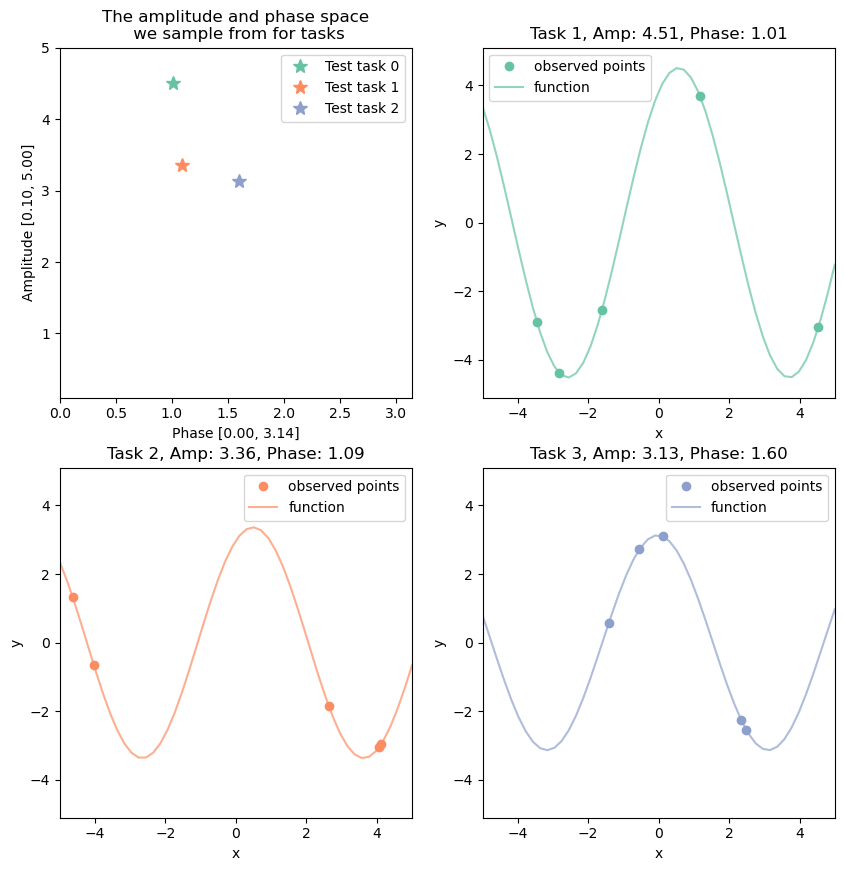

In [6]:
# plot the test data (to give insight into what the different meta-tasks look like)

colors = ["#66c2a5", "#fc8d62", "#8da0cb"]

f, axarr = plt.subplots(2,2, figsize = (10,10))

# First plot will be the phase and amplitude plots
ax = axarr[0, 0]
for i, task in enumerate(test_examples):
    ax.plot(task.phase, task.amplitude, '*', color=colors[i], label=f"Test task {i}", ms=10)
ax.set_xlim(run_params.phase_limits)
ax.set_xlabel(f"Phase [{run_params.phase_limits[0]:.2f}, {run_params.phase_limits[1]:.2f}]")
ax.set_ylim(run_params.amplitude_limits)
ax.set_ylabel(f"Amplitude [{run_params.amplitude_limits[0]:.2f}, {run_params.amplitude_limits[1]:.2f}]")
ax.legend()
ax.set_title('The amplitude and phase space\n we sample from for tasks')

# Other plots will be the function and the training points one will see for it. 
x_grid = np.linspace(*run_params.x_limits)
for i, task in enumerate(test_examples, start=1):
    ax = axarr[i//2, i%2]
    ax.plot(task.x, task.y, 'o', color=colors[i-1], label='observed points')
    f = task.evaluate_anywhere(x_grid)
    ax.plot(x_grid, f, color=colors[i-1], label='function', alpha=0.7)

    
    ax.set_title(f'Task {i}, Amp: {task.amplitude:.2f}, Phase: {task.phase:.2f}')
    ax.set_ylim((-run_params.amplitude_limits[1]-0.1, run_params.amplitude_limits[1]+0.1))
    ax.set_xlim(run_params.x_limits)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    
plt.show()

As you can see above, our tasks are similar (hopefully to enable meta-learning) but differ not only in phase and amplitude, but also the location of the training points on the x-axis. Note that we do not add any noise to the y values.

Before moving on we will also define a grid to evaluate our networks on:

In [7]:
grid = jnp.linspace(*run_params.x_limits, 100)

## 3. Create network

Having created the dataset, we will now create our neural networks. To be more specific we will create a network with two hidden layers (the dimension of which we defined in the first section). We will use the [Flax](https://flax.readthedocs.io/en/latest/index.html) library for this.

In [8]:
class FFN(nn.Module):
    layer_sizes: typing.Sequence[int]

    @nn.compact
    def __call__(self, x):
        for layer_size in self.layer_sizes[:-1]:
            x = nn.Dense(layer_size)(x)
            x = nn.relu(x)
        x = nn.Dense(self.layer_sizes[-1])(x)  # <- no non-linearity on output.
        return x

feed_forward_net = FFN([run_params.nn_num_units, run_params.nn_num_units, 1])


Then we will also create utility functions needed while training.

In [9]:
def create_train_state(learning_rate, optimizer='adam', params=None, jxkey=None):
    """Creates initial `TrainState`."""

    if params is None:
        assert jxkey is not None, "If creating new parameters need to be given random key."
        x = jnp.ones((1,))  # Dummy input
        params = feed_forward_net.init(jxkey, x)['params']

    if optimizer == 'adam':
        tx = optax.adam(learning_rate)
    elif optimizer == 'sgd':
        tx = optax.sgd(learning_rate)
    else:
        raise NotImplementedError
    return train_state.TrainState.create(
        apply_fn=feed_forward_net.apply, params=params, tx=tx)

def make_mse_func(ts, x_batched, y_batched):
    # see: https://flax.readthedocs.io/en/latest/notebooks/flax_basics.html#Linear-regression-with-Flax
    def mse(net_params):
        preds = ts.apply_fn({"params": net_params}, x_batched)
        assert preds.shape == y_batched.shape  # <- just to check we arent doing some unintended broadcasting...
        err = preds - y_batched
        return jnp.mean(err**2)
    return mse


## 4. Normal Learning

We are now ready to start learning!
To start off we will show how well we can do on a single task using regular learning (i.e., considering a single task at a time). Before actually training anythign we will plot the outputs one sees from a few random initializations of the network -- as one can see they are quite far away from sinusoids!

Text(0.5, 1.0, 'This shows the outputs from random initializations of our network')

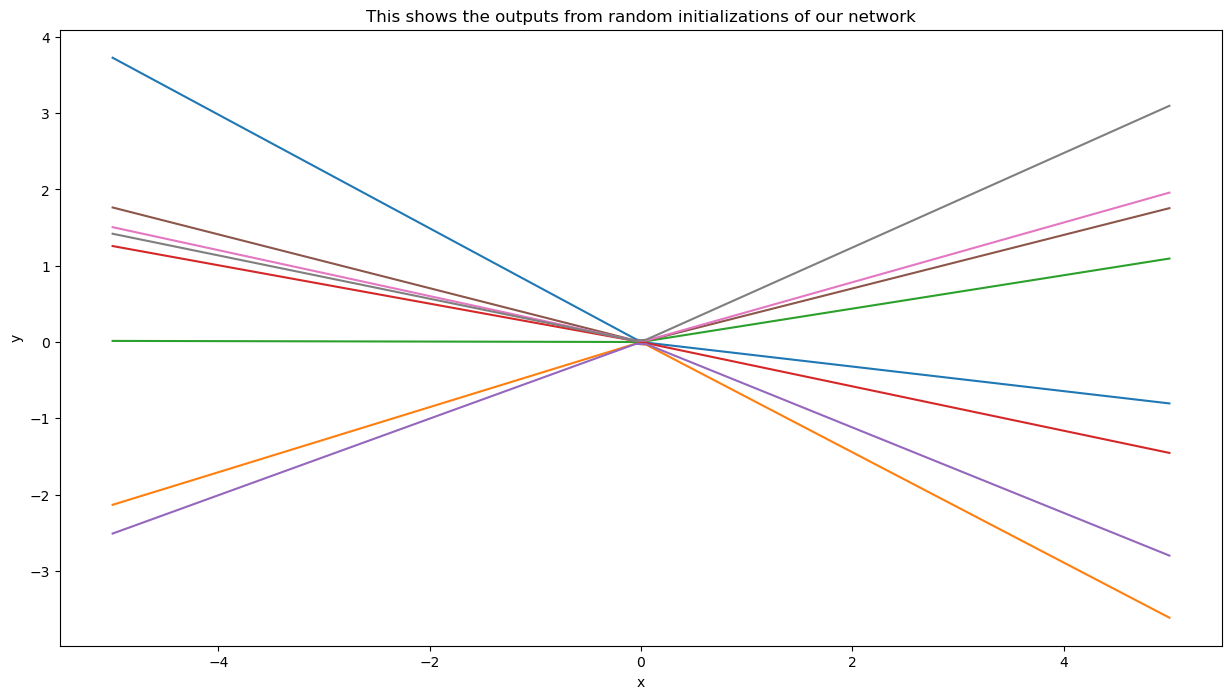

In [10]:
f, ax = plt.subplots(figsize=(15,8))

x = jnp.ones((1,))  # Dummy input, used for initializing the network below.

num_random_examples = 8
for i in range(8):
    jxkey, subkey = jax.random.split(jxkey)
    params = feed_forward_net.init(subkey, x)['params']
    preds = feed_forward_net.apply({"params": params}, grid[:, None])
    ax.plot(np.array(grid), np.array(preds), label=f"predicted_{i}")

ax.set_xlabel('x')
ax.set_ylabel('y');
ax.set_title("This shows the outputs from random initializations of our network")


Well let's now see how well we can do via optimization. Let's use the first test function we have above, and see how the predictions evolve as we train the network for longer. We'll define this inside a function so that we can reuse this code again later!


In [11]:

def predictions_as_a_func_step(jxkey, test_task_one, params=None, plot_steps=None):
    if plot_steps is None:
        plot_steps =  [0, 1, 5, 10, 20, 50, 100, 200, 300]
        
    # As data we will get out the points from the given task
    xs, ys = zip(*(test_task_one[i] for i in range(len(test_task_one))))
    xs = jnp.vstack(list(xs))
    ys = jnp.vstack(list(ys))
    true_values_at_grid = test_task_one.evaluate_anywhere(grid)

    # We will plot the predicted function at a series of different steps:
    plot_steps_set = set(plot_steps)
    num_steps = max(plot_steps) + 1

    # We will set up some color(s) for the predictions at different stages of training
    # note that we have written this code so that one can plot from different initializations
    # if one so desires, just extend cmaps_names list with more colormap names!
    cmaps_names =  ['Purples'] 
    # ^ I coded up this cell so that one can use different initializations 
    # (by adding more names, e.g. ['Greens'])
    # but I found this often clutters the plot below so have only gone with one for now.
    colors_preds = []
    colors_losses = []
    for cmap_nm in cmaps_names:
        cm = matplotlib.cm.get_cmap(cmap_nm)
        colors_preds.append([cm(x) for x in np.linspace(0.1, 1.0, len(plot_steps))])
        colors_losses.append(cm(1.0))  # for the losses plot we shall just use the darkest color!
    num_different_starts = len(cmaps_names) 

    # Set up the plot
    f, axarr = plt.subplots(1, 2, figsize=(18,8), gridspec_kw={'width_ratios': [3, 1]})

    # Then loop through the different initializations!
    for sd in range(num_different_starts):
        jxkey, subkey = jax.random.split(jxkey)
        ts_inner = create_train_state(run_params.il_lr, optimizer='adam', jxkey=subkey, params=params)
        # ^ note we refer to this training state as the "inner" one, foreshadowing the meta-learning
        # concepts we shall use later!
        context_loss = make_mse_func(ts_inner, xs, ys)
        inner_loop_grad_fn = jax.value_and_grad(context_loss)

        loss_steps = []
        losses_train = []
        losses_val = []
        # And now run the optimization steps
        for stp in tqdm_n(range(num_steps), desc=f"optimizing for seed: {sd}"):
            preds = ts_inner.apply_fn({'params': ts_inner.params}, grid[:, None])

            if stp in plot_steps_set:
                axarr[0].plot(np.array(grid), np.array(preds),
                              color=colors_preds[sd][plot_steps.index(stp)], label=f'seed {sd}, step {stp}')

            loss_val, grads = inner_loop_grad_fn(ts_inner.params)
            losses_train.append(loss_val.item())
            losses_val.append(jnp.mean((preds[:, 0] - true_values_at_grid)**2).item())
            assert preds[:, 0].shape == true_values_at_grid.shape

            loss_steps.append(stp)
            ts_inner = ts_inner.apply_gradients(grads=grads)

        # We then plot the losses during training on the training points and grid points (effectively a validation dataset)
        axarr[1].plot(loss_steps, losses_train, '--', color=colors_losses[sd], label=f'seed {sd}, train')
        axarr[1].plot(loss_steps, losses_val, ':', color=colors_losses[sd], label=f'seed {sd}, grid')


    # Plot the ground truth on the prediction plot
    axarr[0].plot(np.array(xs), np.array(ys), 'o', color='black', label='training data')
    x_grid = np.linspace(*axarr[0].get_xlim())
    axarr[0].plot(x_grid, test_task_one.evaluate_anywhere(x_grid), '--', color='black', label='ground_truth')

    # Add legend and axis labels to the prediction plot
    axarr[0].set_xlabel('x')
    axarr[0].set_ylabel('y')
    axarr[0].legend(ncol=3)

    # Add them to the loss plot too
    axarr[1].set_xlabel('step number')
    axarr[1].set_ylabel('loss')
    axarr[1].legend()
 


/var/folders/6m/22vtqxhx77zbj5qrzf7l8xrw0000gn/T/ipykernel_33459/3358481633.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = matplotlib.cm.get_cmap(cmap_nm)
optimizing for seed: 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:13<00:00, 22.31it/s]


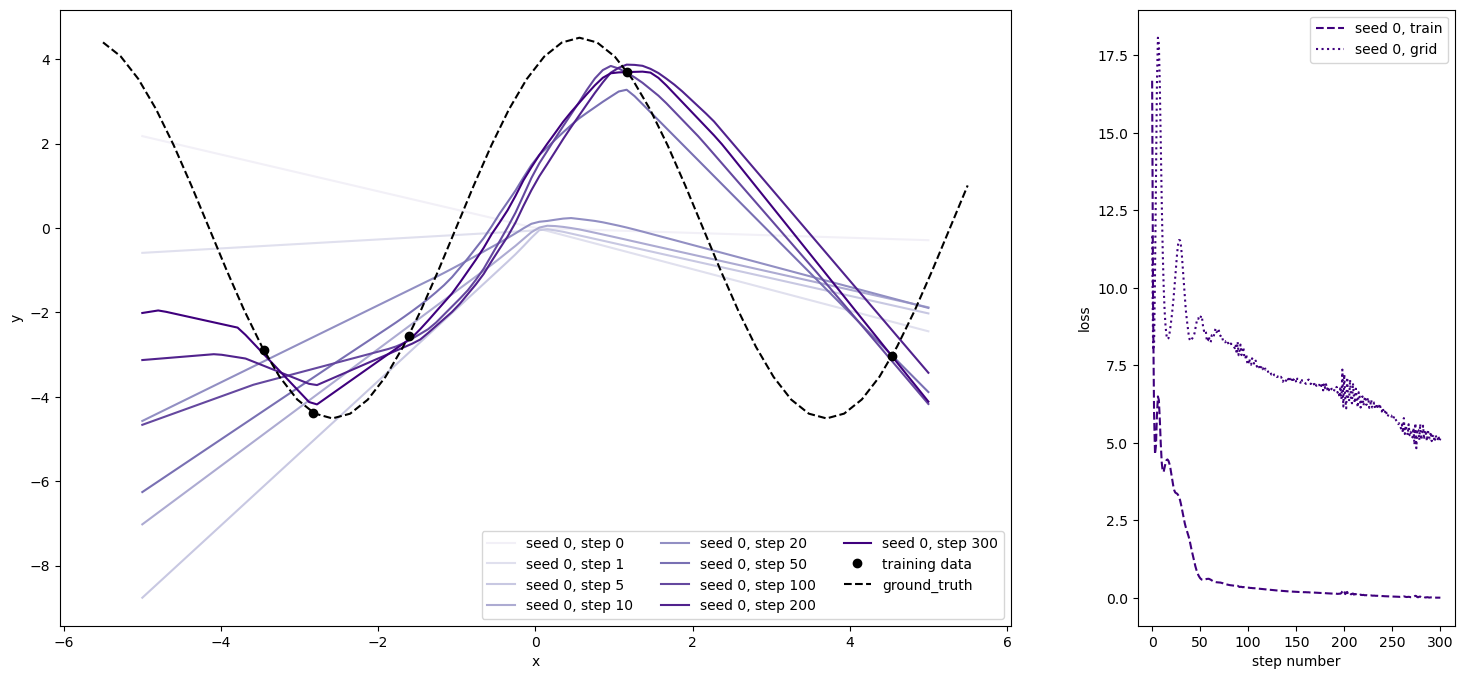

In [12]:
predictions_as_a_func_step(jxkey, test_examples[0])

## 5. MAML

We first need to write a function that encapsulates the training loop which we wrote out above:

In [13]:
def optimize_on_batch(net_params, x_batched_context, y_batched_context, num_steps):
    ts_inner = create_train_state(run_params.il_lr, optimizer='sgd', params=net_params)

    context_loss = make_mse_func(ts_inner, x_batched_context, y_batched_context)
    inner_loop_grad_fn = jax.value_and_grad(context_loss)
    for i in range(num_steps):
        loss_val, grads = inner_loop_grad_fn(ts_inner.params)
        ts_inner = ts_inner.apply_gradients(grads=grads)
    return ts_inner.params

This done we can then write a function holding the whole inner loop process, that is running the opimization function we have just defined and then computing the loss in the test dataset.

In [14]:

def make_inner_loop_func(ts, x_batched_context, y_batched_context, x_batched_test, y_batched_test):
    def il_(net_params):
        net_params = optimize_on_batch(net_params, x_batched_context, y_batched_context, run_params.il_num_steps)
        test_loss = make_mse_func(ts, x_batched_test, y_batched_test)(net_params)
        return test_loss
    return il_



We are now ready to write an outer loop step. This involves averaging the loss from inner loops run over several different tasks: 

In [15]:

def make_outer_loop_eval_loss(ts, tasks):
    def ol_(net_params):
        total_loss = 0.
        for task in tasks:
            test_task = task.split_off_test(run_params.num_data_points_per_task)

            data = []
            for t_ in [task, test_task]:
                xs, ys = zip(*(t_[i] for i in range(run_params.num_data_points_per_task)))
                xs = jnp.vstack(list(xs))
                ys = jnp.vstack(list(ys))
                data += [xs, ys]
            il = make_inner_loop_func(ts, *data)
            total_loss += il(net_params)
        return total_loss / len(tasks)
    return ol_

def ol_train_step(ts, tasks_for_batch):
    """Train for a single step."""
    ol_step = make_outer_loop_eval_loss(ts, tasks_for_batch)
    grad_fn = jax.value_and_grad(ol_step)
    loss, grads = grad_fn(ts.params)
    ts = ts.apply_gradients(grads=grads)
    return ts, loss


...and a function to do several of these outer loop steps to make up an entire epoch (an epoch in this sense means going through all of the training tasks):

In [16]:

def train_epoch(ts, train_tasks, num_tasks_per_batch, epoch_id, rng):
    train_ds_size = len(train_tasks)
    steps_per_epoch = train_ds_size // num_tasks_per_batch

    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * num_tasks_per_batch]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, num_tasks_per_batch))
    losses = []
    for perm in perms:
        tasks_for_batch = [train_tasks[i] for i in perm]
        ts, loss = ol_train_step(ts, tasks_for_batch)
        losses.append(loss)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(losses)
    mean_loss = np.mean(batch_metrics_np)

    print(f'train epoch: {epoch_id}, loss: {mean_loss})')
    return ts



As well as some utilitary functions for helping with the evaluation.

In [17]:
def inner_loop_one_task(ts, task, num_steps):
    xs, ys = zip(*(task[i] for i in range(len(task))))
    xs = jnp.vstack(list(xs))
    ys = jnp.vstack(list(ys))
    net_params = optimize_on_batch(ts.params, xs, ys, num_steps)
    ts = ts.replace(params=net_params)
    return ts

def finetune_eval_model(ts, tasks, grid, num_steps=1):
    """ 
    This finetunes the model on each of the tasks and returns the 
    loss on the tasks datapoints as well as on the underlying grid.
    (useful for evaluating how good the initialization is).
    """
    mses_grid = []
    mses_dps = []
    for task in tasks:
        # Update the parameters on the tasks datapoints:        
        new_ts = inner_loop_one_task(ts, task, num_steps)
        
        # Get the MSEs on the grid:
        preds = new_ts.apply_fn({"params" : new_ts.params}, grid[:, None])
        true_values = task.evaluate_anywhere(np.array(grid))[:, None]
        assert true_values.shape == preds.shape
        mses_grid.append(jnp.mean((preds - true_values)**2))
        
        # Get the MSEs on the task's datapoints
        xs, ys = zip(*(task[i] for i in range(len(task))))
        xs = jnp.vstack(list(xs))
        ys = jnp.vstack(list(ys))
        preds_dps = new_ts.apply_fn({"params" : new_ts.params}, xs)
        assert ys.shape == preds_dps.shape, f"{ys.shape} != {preds_dps.shape}" 
        mses_dps.append(jnp.mean((preds_dps - ys)**2))

        
    mse_grid = jnp.mean(jnp.stack(mses_grid)).item()
    mse_dp = jnp.mean(jnp.stack(mses_dps)).item()
    return mse_grid, mse_dp
    

This done let's create a training dataset:

In [18]:
train_tasks = [next(data_generator) for _ in range(run_params.num_training_tasks)]

A train state:


In [19]:
jxkey, subkey = jax.random.split(jxkey)
outer_ts = create_train_state(run_params.ol_lr, optimizer='adam', jxkey=subkey)


And now we can train. This will likely take a while! (On a fast machine with a good GPU it seems to take about 30 secs per epoch).

In [20]:
# Okay now go!
test_loss_grid_all = []
test_loss_dp_all = []
epoch2params = {}

with tqdm_n(range(1, run_params.num_epochs + 1), desc="Total training") as pbar:
    for epoch in pbar:
        # Use a separate PRNG key to permute image data during shuffling
        jxkey, subkey = jax.random.split(jxkey)
        # Run an optimization step over a training batch
        outer_ts = train_epoch(outer_ts, train_tasks, run_params.num_tasks_per_batch, epoch, subkey)
        # Evaluate on the test set after each training epoch
        test_loss_grid, test_loss_dp = finetune_eval_model(outer_ts, test_examples, grid, 5)
        print(f' test epoch: {epoch}, test loss (grid): {test_loss_grid:.4f}, test loss (datapoints): {test_loss_dp:.4f}')
        pbar.set_postfix(test_loss_grid=test_loss_grid, test_loss_dp=test_loss_dp)
        
        test_loss_grid_all.append(test_loss_grid)
        test_loss_dp_all.append(test_loss_dp)
        if (epoch % 25) == 0:
            epoch2params[epoch] = outer_ts.params
            

Total training:   0%|                                                                                                                                  | 0/1000 [00:00<?, ?it/s]

train epoch: 1, loss: 8.688055992126465)


Total training:   0%|                                                                                | 1/1000 [00:05<1:35:49,  5.76s/it, test_loss_dp=2.61, test_loss_grid=8.64]

 test epoch: 1, test loss (grid): 8.6398, test loss (datapoints): 2.6120
train epoch: 2, loss: 9.059911727905273)


Total training:   0%|▏                                                                               | 2/1000 [00:11<1:30:57,  5.47s/it, test_loss_dp=3.15, test_loss_grid=8.15]

 test epoch: 2, test loss (grid): 8.1486, test loss (datapoints): 3.1490
train epoch: 3, loss: 7.990633487701416)


Total training:   0%|▏                                                                                | 3/1000 [00:16<1:29:30,  5.39s/it, test_loss_dp=4.1, test_loss_grid=8.23]

 test epoch: 3, test loss (grid): 8.2281, test loss (datapoints): 4.1017
train epoch: 4, loss: 6.028559684753418)


Total training:   0%|▎                                                                               | 4/1000 [00:21<1:28:58,  5.36s/it, test_loss_dp=3.05, test_loss_grid=7.86]

 test epoch: 4, test loss (grid): 7.8579, test loss (datapoints): 3.0493
train epoch: 5, loss: 6.3547892570495605)


Total training:   0%|▍                                                                               | 5/1000 [00:26<1:28:22,  5.33s/it, test_loss_dp=2.61, test_loss_grid=7.82]

 test epoch: 5, test loss (grid): 7.8153, test loss (datapoints): 2.6114
train epoch: 6, loss: 5.628971099853516)


Total training:   1%|▍                                                                               | 6/1000 [00:32<1:28:19,  5.33s/it, test_loss_dp=2.57, test_loss_grid=7.85]

 test epoch: 6, test loss (grid): 7.8522, test loss (datapoints): 2.5705
train epoch: 7, loss: 5.308449745178223)


Total training:   1%|▌                                                                               | 7/1000 [00:37<1:28:09,  5.33s/it, test_loss_dp=2.57, test_loss_grid=7.81]

 test epoch: 7, test loss (grid): 7.8092, test loss (datapoints): 2.5658
train epoch: 8, loss: 5.491969108581543)


Total training:   1%|▋                                                                                | 8/1000 [00:42<1:28:09,  5.33s/it, test_loss_dp=2.58, test_loss_grid=7.8]

 test epoch: 8, test loss (grid): 7.8017, test loss (datapoints): 2.5845
train epoch: 9, loss: 5.817776203155518)


Total training:   1%|▋                                                                               | 9/1000 [00:48<1:27:41,  5.31s/it, test_loss_dp=2.57, test_loss_grid=7.73]

 test epoch: 9, test loss (grid): 7.7286, test loss (datapoints): 2.5702
train epoch: 10, loss: 5.098006248474121)


Total training:   1%|▊                                                                              | 10/1000 [00:53<1:27:42,  5.32s/it, test_loss_dp=2.59, test_loss_grid=7.76]

 test epoch: 10, test loss (grid): 7.7575, test loss (datapoints): 2.5944
train epoch: 11, loss: 4.659733772277832)


Total training:   1%|▊                                                                              | 11/1000 [00:58<1:27:23,  5.30s/it, test_loss_dp=2.56, test_loss_grid=7.57]

 test epoch: 11, test loss (grid): 7.5704, test loss (datapoints): 2.5595
train epoch: 12, loss: 4.629117965698242)


Total training:   1%|▉                                                                              | 12/1000 [01:04<1:27:19,  5.30s/it, test_loss_dp=2.56, test_loss_grid=7.51]

 test epoch: 12, test loss (grid): 7.5087, test loss (datapoints): 2.5572
train epoch: 13, loss: 4.4949188232421875)


Total training:   1%|█                                                                              | 13/1000 [01:09<1:26:58,  5.29s/it, test_loss_dp=2.55, test_loss_grid=7.44]

 test epoch: 13, test loss (grid): 7.4359, test loss (datapoints): 2.5519
train epoch: 14, loss: 4.428609371185303)


Total training:   1%|█                                                                              | 14/1000 [01:14<1:27:12,  5.31s/it, test_loss_dp=2.55, test_loss_grid=7.39]

 test epoch: 14, test loss (grid): 7.3855, test loss (datapoints): 2.5489
train epoch: 15, loss: 5.1045241355896)


Total training:   2%|█▏                                                                             | 15/1000 [01:20<1:28:20,  5.38s/it, test_loss_dp=2.53, test_loss_grid=7.35]

 test epoch: 15, test loss (grid): 7.3498, test loss (datapoints): 2.5338
train epoch: 16, loss: 4.284361839294434)


Total training:   2%|█▎                                                                             | 16/1000 [01:25<1:29:06,  5.43s/it, test_loss_dp=2.52, test_loss_grid=7.32]

 test epoch: 16, test loss (grid): 7.3195, test loss (datapoints): 2.5197
train epoch: 17, loss: 4.369929790496826)


Total training:   2%|█▎                                                                             | 17/1000 [01:31<1:29:30,  5.46s/it, test_loss_dp=2.51, test_loss_grid=7.27]

 test epoch: 17, test loss (grid): 7.2743, test loss (datapoints): 2.5105
train epoch: 18, loss: 4.6829142570495605)


Total training:   2%|█▍                                                                              | 18/1000 [01:36<1:29:31,  5.47s/it, test_loss_dp=2.5, test_loss_grid=7.27]

 test epoch: 18, test loss (grid): 7.2660, test loss (datapoints): 2.5032
train epoch: 19, loss: 4.547623634338379)


Total training:   2%|█▌                                                                              | 19/1000 [01:42<1:29:29,  5.47s/it, test_loss_dp=2.5, test_loss_grid=7.24]

 test epoch: 19, test loss (grid): 7.2365, test loss (datapoints): 2.5007
train epoch: 20, loss: 4.029287815093994)


Total training:   2%|█▌                                                                              | 20/1000 [01:47<1:29:00,  5.45s/it, test_loss_dp=2.49, test_loss_grid=7.2]

 test epoch: 20, test loss (grid): 7.1994, test loss (datapoints): 2.4933
train epoch: 21, loss: 3.977553606033325)


Total training:   2%|█▋                                                                             | 21/1000 [01:53<1:29:11,  5.47s/it, test_loss_dp=2.49, test_loss_grid=7.14]

 test epoch: 21, test loss (grid): 7.1428, test loss (datapoints): 2.4882
train epoch: 22, loss: 4.282796859741211)


Total training:   2%|█▋                                                                             | 22/1000 [01:58<1:29:22,  5.48s/it, test_loss_dp=2.48, test_loss_grid=7.13]

 test epoch: 22, test loss (grid): 7.1292, test loss (datapoints): 2.4843
train epoch: 23, loss: 3.9348742961883545)


Total training:   2%|█▊                                                                             | 23/1000 [02:04<1:29:15,  5.48s/it, test_loss_dp=2.48, test_loss_grid=7.11]

 test epoch: 23, test loss (grid): 7.1070, test loss (datapoints): 2.4760
train epoch: 24, loss: 4.261269569396973)


Total training:   2%|█▉                                                                             | 24/1000 [02:09<1:29:51,  5.52s/it, test_loss_dp=2.47, test_loss_grid=7.04]

 test epoch: 24, test loss (grid): 7.0420, test loss (datapoints): 2.4701
train epoch: 25, loss: 4.078612327575684)


Total training:   2%|█▉                                                                             | 25/1000 [02:15<1:29:38,  5.52s/it, test_loss_dp=2.46, test_loss_grid=7.04]

 test epoch: 25, test loss (grid): 7.0420, test loss (datapoints): 2.4646
train epoch: 26, loss: 3.903862714767456)


Total training:   3%|██                                                                             | 26/1000 [02:20<1:29:34,  5.52s/it, test_loss_dp=2.46, test_loss_grid=7.01]

 test epoch: 26, test loss (grid): 7.0119, test loss (datapoints): 2.4600
train epoch: 27, loss: 3.740811824798584)


Total training:   3%|██▏                                                                            | 27/1000 [02:26<1:29:21,  5.51s/it, test_loss_dp=2.45, test_loss_grid=7.02]

 test epoch: 27, test loss (grid): 7.0172, test loss (datapoints): 2.4503
train epoch: 28, loss: 4.150049686431885)


Total training:   3%|██▏                                                                            | 28/1000 [02:31<1:29:59,  5.55s/it, test_loss_dp=2.45, test_loss_grid=6.97]

 test epoch: 28, test loss (grid): 6.9725, test loss (datapoints): 2.4475
train epoch: 29, loss: 3.9447379112243652)


Total training:   3%|██▎                                                                            | 29/1000 [02:37<1:29:59,  5.56s/it, test_loss_dp=2.44, test_loss_grid=6.94]

 test epoch: 29, test loss (grid): 6.9424, test loss (datapoints): 2.4429
train epoch: 30, loss: 4.171626091003418)


Total training:   3%|██▎                                                                            | 30/1000 [02:43<1:30:13,  5.58s/it, test_loss_dp=2.44, test_loss_grid=6.91]

 test epoch: 30, test loss (grid): 6.9109, test loss (datapoints): 2.4350
train epoch: 31, loss: 3.8059394359588623)


Total training:   3%|██▍                                                                            | 31/1000 [02:48<1:30:15,  5.59s/it, test_loss_dp=2.43, test_loss_grid=6.87]

 test epoch: 31, test loss (grid): 6.8708, test loss (datapoints): 2.4270
train epoch: 32, loss: 4.001935005187988)


Total training:   3%|██▌                                                                            | 32/1000 [02:54<1:29:32,  5.55s/it, test_loss_dp=2.42, test_loss_grid=6.86]

 test epoch: 32, test loss (grid): 6.8623, test loss (datapoints): 2.4170
train epoch: 33, loss: 3.78963041305542)


Total training:   3%|██▋                                                                             | 33/1000 [02:59<1:29:40,  5.56s/it, test_loss_dp=2.4, test_loss_grid=6.85]

 test epoch: 33, test loss (grid): 6.8493, test loss (datapoints): 2.3970
train epoch: 34, loss: 3.535855770111084)


Total training:   3%|██▋                                                                            | 34/1000 [03:05<1:29:18,  5.55s/it, test_loss_dp=2.38, test_loss_grid=6.83]

 test epoch: 34, test loss (grid): 6.8333, test loss (datapoints): 2.3831
train epoch: 35, loss: 3.542903423309326)


Total training:   4%|██▊                                                                            | 35/1000 [03:10<1:29:16,  5.55s/it, test_loss_dp=2.37, test_loss_grid=6.78]

 test epoch: 35, test loss (grid): 6.7828, test loss (datapoints): 2.3720
train epoch: 36, loss: 3.9390149116516113)


Total training:   4%|██▊                                                                            | 36/1000 [03:16<1:29:34,  5.57s/it, test_loss_dp=2.35, test_loss_grid=6.75]

 test epoch: 36, test loss (grid): 6.7496, test loss (datapoints): 2.3549
train epoch: 37, loss: 3.7577335834503174)


Total training:   4%|██▉                                                                            | 37/1000 [03:22<1:31:53,  5.73s/it, test_loss_dp=2.33, test_loss_grid=6.72]

 test epoch: 37, test loss (grid): 6.7240, test loss (datapoints): 2.3304
train epoch: 38, loss: 4.246421813964844)


Total training:   4%|███                                                                            | 38/1000 [03:28<1:31:28,  5.70s/it, test_loss_dp=2.31, test_loss_grid=6.67]

 test epoch: 38, test loss (grid): 6.6709, test loss (datapoints): 2.3052
train epoch: 39, loss: 3.744302749633789)


Total training:   4%|███                                                                            | 39/1000 [03:34<1:31:31,  5.71s/it, test_loss_dp=2.29, test_loss_grid=6.65]

 test epoch: 39, test loss (grid): 6.6457, test loss (datapoints): 2.2897
train epoch: 40, loss: 3.6521739959716797)


Total training:   4%|███▏                                                                           | 40/1000 [03:39<1:32:13,  5.76s/it, test_loss_dp=2.28, test_loss_grid=6.65]

 test epoch: 40, test loss (grid): 6.6493, test loss (datapoints): 2.2810
train epoch: 41, loss: 3.6866912841796875)


Total training:   4%|███▏                                                                           | 41/1000 [03:45<1:30:45,  5.68s/it, test_loss_dp=2.24, test_loss_grid=6.64]

 test epoch: 41, test loss (grid): 6.6386, test loss (datapoints): 2.2440
train epoch: 42, loss: 3.4627158641815186)


Total training:   4%|███▎                                                                           | 42/1000 [03:50<1:30:03,  5.64s/it, test_loss_dp=2.22, test_loss_grid=6.61]

 test epoch: 42, test loss (grid): 6.6094, test loss (datapoints): 2.2245
train epoch: 43, loss: 3.505493640899658)


Total training:   4%|███▍                                                                            | 43/1000 [03:56<1:28:58,  5.58s/it, test_loss_dp=2.2, test_loss_grid=6.61]

 test epoch: 43, test loss (grid): 6.6089, test loss (datapoints): 2.2014
train epoch: 44, loss: 3.564319610595703)


Total training:   4%|███▌                                                                            | 44/1000 [04:01<1:28:37,  5.56s/it, test_loss_dp=2.2, test_loss_grid=6.59]

 test epoch: 44, test loss (grid): 6.5917, test loss (datapoints): 2.1958
train epoch: 45, loss: 3.6952786445617676)


Total training:   4%|███▌                                                                           | 45/1000 [04:07<1:27:57,  5.53s/it, test_loss_dp=2.17, test_loss_grid=6.52]

 test epoch: 45, test loss (grid): 6.5159, test loss (datapoints): 2.1732
train epoch: 46, loss: 3.7987735271453857)


Total training:   5%|███▋                                                                           | 46/1000 [04:12<1:27:35,  5.51s/it, test_loss_dp=2.18, test_loss_grid=6.49]

 test epoch: 46, test loss (grid): 6.4855, test loss (datapoints): 2.1768
train epoch: 47, loss: 3.8822085857391357)


Total training:   5%|███▋                                                                           | 47/1000 [04:18<1:27:05,  5.48s/it, test_loss_dp=2.15, test_loss_grid=6.41]

 test epoch: 47, test loss (grid): 6.4146, test loss (datapoints): 2.1471
train epoch: 48, loss: 3.5906901359558105)


Total training:   5%|███▊                                                                           | 48/1000 [04:23<1:28:05,  5.55s/it, test_loss_dp=2.12, test_loss_grid=6.42]

 test epoch: 48, test loss (grid): 6.4220, test loss (datapoints): 2.1192
train epoch: 49, loss: 3.869295597076416)


Total training:   5%|███▉                                                                            | 49/1000 [04:29<1:28:15,  5.57s/it, test_loss_dp=2.08, test_loss_grid=6.4]

 test epoch: 49, test loss (grid): 6.4002, test loss (datapoints): 2.0786
train epoch: 50, loss: 3.3269896507263184)


Total training:   5%|███▉                                                                           | 50/1000 [04:35<1:29:26,  5.65s/it, test_loss_dp=2.05, test_loss_grid=6.37]

 test epoch: 50, test loss (grid): 6.3681, test loss (datapoints): 2.0503
train epoch: 51, loss: 3.4455158710479736)


Total training:   5%|████                                                                           | 51/1000 [04:40<1:29:07,  5.63s/it, test_loss_dp=2.02, test_loss_grid=6.35]

 test epoch: 51, test loss (grid): 6.3451, test loss (datapoints): 2.0167
train epoch: 52, loss: 3.484410047531128)


Total training:   5%|████▎                                                                             | 52/1000 [04:46<1:28:52,  5.62s/it, test_loss_dp=2, test_loss_grid=6.27]

 test epoch: 52, test loss (grid): 6.2738, test loss (datapoints): 1.9963
train epoch: 53, loss: 3.3900458812713623)


Total training:   5%|████▏                                                                          | 53/1000 [04:51<1:27:50,  5.56s/it, test_loss_dp=1.98, test_loss_grid=6.25]

 test epoch: 53, test loss (grid): 6.2461, test loss (datapoints): 1.9811
train epoch: 54, loss: 3.1548008918762207)


Total training:   5%|████▎                                                                          | 54/1000 [04:57<1:27:26,  5.55s/it, test_loss_dp=1.95, test_loss_grid=6.21]

 test epoch: 54, test loss (grid): 6.2084, test loss (datapoints): 1.9511
train epoch: 55, loss: 3.726710557937622)


Total training:   6%|████▎                                                                          | 55/1000 [05:02<1:26:52,  5.52s/it, test_loss_dp=1.92, test_loss_grid=6.19]

 test epoch: 55, test loss (grid): 6.1854, test loss (datapoints): 1.9193
train epoch: 56, loss: 3.0606560707092285)


Total training:   6%|████▍                                                                           | 56/1000 [05:08<1:26:19,  5.49s/it, test_loss_dp=1.9, test_loss_grid=6.15]

 test epoch: 56, test loss (grid): 6.1504, test loss (datapoints): 1.8956
train epoch: 57, loss: 3.4618141651153564)


Total training:   6%|████▌                                                                          | 57/1000 [05:13<1:26:08,  5.48s/it, test_loss_dp=1.87, test_loss_grid=6.08]

 test epoch: 57, test loss (grid): 6.0847, test loss (datapoints): 1.8739
train epoch: 58, loss: 3.6068332195281982)


Total training:   6%|████▌                                                                          | 58/1000 [05:19<1:25:41,  5.46s/it, test_loss_dp=1.84, test_loss_grid=6.08]

 test epoch: 58, test loss (grid): 6.0763, test loss (datapoints): 1.8396
train epoch: 59, loss: 3.1632437705993652)


Total training:   6%|████▋                                                                           | 59/1000 [05:24<1:25:38,  5.46s/it, test_loss_dp=1.8, test_loss_grid=6.03]

 test epoch: 59, test loss (grid): 6.0289, test loss (datapoints): 1.7998
train epoch: 60, loss: 3.4479470252990723)


Total training:   6%|████▋                                                                          | 60/1000 [05:30<1:27:13,  5.57s/it, test_loss_dp=1.77, test_loss_grid=5.95]

 test epoch: 60, test loss (grid): 5.9474, test loss (datapoints): 1.7746
train epoch: 61, loss: 3.0938305854797363)


Total training:   6%|████▊                                                                          | 61/1000 [05:36<1:28:25,  5.65s/it, test_loss_dp=1.75, test_loss_grid=5.95]

 test epoch: 61, test loss (grid): 5.9534, test loss (datapoints): 1.7511
train epoch: 62, loss: 3.090106248855591)


Total training:   6%|████▉                                                                          | 62/1000 [05:42<1:28:48,  5.68s/it, test_loss_dp=1.73, test_loss_grid=5.95]

 test epoch: 62, test loss (grid): 5.9452, test loss (datapoints): 1.7286
train epoch: 63, loss: 3.5201945304870605)


Total training:   6%|████▉                                                                          | 63/1000 [05:47<1:29:19,  5.72s/it, test_loss_dp=1.69, test_loss_grid=5.87]

 test epoch: 63, test loss (grid): 5.8681, test loss (datapoints): 1.6882
train epoch: 64, loss: 3.2768642902374268)


Total training:   6%|█████                                                                          | 64/1000 [05:53<1:28:02,  5.64s/it, test_loss_dp=1.64, test_loss_grid=5.86]

 test epoch: 64, test loss (grid): 5.8569, test loss (datapoints): 1.6424
train epoch: 65, loss: 3.3849406242370605)


Total training:   6%|█████▏                                                                         | 65/1000 [05:58<1:27:32,  5.62s/it, test_loss_dp=1.61, test_loss_grid=5.84]

 test epoch: 65, test loss (grid): 5.8421, test loss (datapoints): 1.6104
train epoch: 66, loss: 3.469513416290283)


Total training:   7%|█████▏                                                                         | 66/1000 [06:04<1:27:37,  5.63s/it, test_loss_dp=1.59, test_loss_grid=5.77]

 test epoch: 66, test loss (grid): 5.7746, test loss (datapoints): 1.5859
train epoch: 67, loss: 3.5080370903015137)


Total training:   7%|█████▎                                                                         | 67/1000 [06:10<1:28:12,  5.67s/it, test_loss_dp=1.57, test_loss_grid=5.73]

 test epoch: 67, test loss (grid): 5.7286, test loss (datapoints): 1.5659
train epoch: 68, loss: 3.2690367698669434)


Total training:   7%|█████▎                                                                         | 68/1000 [06:15<1:27:02,  5.60s/it, test_loss_dp=1.53, test_loss_grid=5.69]

 test epoch: 68, test loss (grid): 5.6859, test loss (datapoints): 1.5324
train epoch: 69, loss: 3.4268851280212402)


Total training:   7%|█████▌                                                                          | 69/1000 [06:21<1:26:48,  5.60s/it, test_loss_dp=1.53, test_loss_grid=5.6]

 test epoch: 69, test loss (grid): 5.5973, test loss (datapoints): 1.5292
train epoch: 70, loss: 3.029069185256958)


Total training:   7%|█████▌                                                                         | 70/1000 [06:26<1:25:54,  5.54s/it, test_loss_dp=1.51, test_loss_grid=5.57]

 test epoch: 70, test loss (grid): 5.5710, test loss (datapoints): 1.5063
train epoch: 71, loss: 3.154654026031494)


Total training:   7%|█████▌                                                                         | 71/1000 [06:32<1:28:09,  5.69s/it, test_loss_dp=1.48, test_loss_grid=5.55]

 test epoch: 71, test loss (grid): 5.5491, test loss (datapoints): 1.4818
train epoch: 72, loss: 3.312908172607422)


Total training:   7%|█████▋                                                                         | 72/1000 [06:38<1:28:16,  5.71s/it, test_loss_dp=1.46, test_loss_grid=5.55]

 test epoch: 72, test loss (grid): 5.5525, test loss (datapoints): 1.4637
train epoch: 73, loss: 3.2582714557647705)


Total training:   7%|█████▊                                                                         | 73/1000 [06:44<1:28:40,  5.74s/it, test_loss_dp=1.44, test_loss_grid=5.52]

 test epoch: 73, test loss (grid): 5.5151, test loss (datapoints): 1.4373
train epoch: 74, loss: 3.3653976917266846)


Total training:   7%|█████▊                                                                         | 74/1000 [06:50<1:28:14,  5.72s/it, test_loss_dp=1.43, test_loss_grid=5.46]

 test epoch: 74, test loss (grid): 5.4623, test loss (datapoints): 1.4251
train epoch: 75, loss: 3.5365383625030518)


Total training:   8%|█████▉                                                                         | 75/1000 [06:55<1:28:54,  5.77s/it, test_loss_dp=1.41, test_loss_grid=5.41]

 test epoch: 75, test loss (grid): 5.4079, test loss (datapoints): 1.4108
train epoch: 76, loss: 3.3731422424316406)


Total training:   8%|██████                                                                         | 76/1000 [07:01<1:29:16,  5.80s/it, test_loss_dp=1.39, test_loss_grid=5.38]

 test epoch: 76, test loss (grid): 5.3765, test loss (datapoints): 1.3901
train epoch: 77, loss: 3.3451907634735107)


Total training:   8%|██████                                                                         | 77/1000 [07:07<1:29:13,  5.80s/it, test_loss_dp=1.39, test_loss_grid=5.35]

 test epoch: 77, test loss (grid): 5.3538, test loss (datapoints): 1.3855
train epoch: 78, loss: 3.373281478881836)


Total training:   8%|██████▏                                                                        | 78/1000 [07:13<1:29:18,  5.81s/it, test_loss_dp=1.37, test_loss_grid=5.33]

 test epoch: 78, test loss (grid): 5.3315, test loss (datapoints): 1.3703
train epoch: 79, loss: 3.1310536861419678)


Total training:   8%|██████▏                                                                        | 79/1000 [07:19<1:29:19,  5.82s/it, test_loss_dp=1.34, test_loss_grid=5.31]

 test epoch: 79, test loss (grid): 5.3083, test loss (datapoints): 1.3359
train epoch: 80, loss: 3.050386428833008)


Total training:   8%|██████▎                                                                        | 80/1000 [07:25<1:28:47,  5.79s/it, test_loss_dp=1.31, test_loss_grid=5.29]

 test epoch: 80, test loss (grid): 5.2851, test loss (datapoints): 1.3117
train epoch: 81, loss: 3.0956599712371826)


Total training:   8%|██████▍                                                                         | 81/1000 [07:30<1:28:10,  5.76s/it, test_loss_dp=1.3, test_loss_grid=5.29]

 test epoch: 81, test loss (grid): 5.2864, test loss (datapoints): 1.2981
train epoch: 82, loss: 3.1037354469299316)


Total training:   8%|██████▍                                                                        | 82/1000 [07:36<1:28:51,  5.81s/it, test_loss_dp=1.27, test_loss_grid=5.28]

 test epoch: 82, test loss (grid): 5.2790, test loss (datapoints): 1.2704
train epoch: 83, loss: 2.810396671295166)


Total training:   8%|██████▌                                                                        | 83/1000 [07:42<1:27:22,  5.72s/it, test_loss_dp=1.26, test_loss_grid=5.24]

 test epoch: 83, test loss (grid): 5.2377, test loss (datapoints): 1.2630
train epoch: 84, loss: 2.9872195720672607)


Total training:   8%|██████▋                                                                        | 84/1000 [07:47<1:26:57,  5.70s/it, test_loss_dp=1.24, test_loss_grid=5.24]

 test epoch: 84, test loss (grid): 5.2377, test loss (datapoints): 1.2435
train epoch: 85, loss: 2.8947536945343018)


Total training:   8%|██████▋                                                                        | 85/1000 [07:53<1:26:06,  5.65s/it, test_loss_dp=1.22, test_loss_grid=5.21]

 test epoch: 85, test loss (grid): 5.2067, test loss (datapoints): 1.2240
train epoch: 86, loss: 3.015366554260254)


Total training:   9%|██████▉                                                                         | 86/1000 [07:58<1:25:52,  5.64s/it, test_loss_dp=1.2, test_loss_grid=5.15]

 test epoch: 86, test loss (grid): 5.1541, test loss (datapoints): 1.1985
train epoch: 87, loss: 3.15836238861084)


Total training:   9%|██████▊                                                                        | 87/1000 [08:04<1:26:09,  5.66s/it, test_loss_dp=1.16, test_loss_grid=5.16]

 test epoch: 87, test loss (grid): 5.1619, test loss (datapoints): 1.1576
train epoch: 88, loss: 3.2497146129608154)


Total training:   9%|██████▉                                                                        | 88/1000 [08:10<1:25:29,  5.62s/it, test_loss_dp=1.17, test_loss_grid=5.08]

 test epoch: 88, test loss (grid): 5.0799, test loss (datapoints): 1.1747
train epoch: 89, loss: 3.0650930404663086)


Total training:   9%|███████                                                                        | 89/1000 [08:16<1:27:32,  5.77s/it, test_loss_dp=1.15, test_loss_grid=5.05]

 test epoch: 89, test loss (grid): 5.0508, test loss (datapoints): 1.1540
train epoch: 90, loss: 2.8084397315979004)


Total training:   9%|███████                                                                        | 90/1000 [08:21<1:26:29,  5.70s/it, test_loss_dp=1.16, test_loss_grid=5.02]

 test epoch: 90, test loss (grid): 5.0150, test loss (datapoints): 1.1573
train epoch: 91, loss: 3.0549731254577637)


Total training:   9%|███████▏                                                                       | 91/1000 [08:27<1:27:08,  5.75s/it, test_loss_dp=1.15, test_loss_grid=4.98]

 test epoch: 91, test loss (grid): 4.9823, test loss (datapoints): 1.1472
train epoch: 92, loss: 2.8791465759277344)


Total training:   9%|███████▎                                                                       | 92/1000 [08:33<1:27:25,  5.78s/it, test_loss_dp=1.13, test_loss_grid=4.97]

 test epoch: 92, test loss (grid): 4.9710, test loss (datapoints): 1.1302
train epoch: 93, loss: 2.9659323692321777)


Total training:   9%|███████▎                                                                       | 93/1000 [08:39<1:27:11,  5.77s/it, test_loss_dp=1.09, test_loss_grid=4.92]

 test epoch: 93, test loss (grid): 4.9231, test loss (datapoints): 1.0921
train epoch: 94, loss: 3.267024517059326)


Total training:   9%|███████▌                                                                        | 94/1000 [08:45<1:27:52,  5.82s/it, test_loss_dp=1.1, test_loss_grid=4.89]

 test epoch: 94, test loss (grid): 4.8863, test loss (datapoints): 1.0955
train epoch: 95, loss: 3.038214921951294)


Total training:  10%|███████▌                                                                       | 95/1000 [08:51<1:27:33,  5.81s/it, test_loss_dp=1.08, test_loss_grid=4.88]

 test epoch: 95, test loss (grid): 4.8827, test loss (datapoints): 1.0785
train epoch: 96, loss: 3.3086886405944824)


Total training:  10%|███████▌                                                                       | 96/1000 [08:56<1:26:09,  5.72s/it, test_loss_dp=1.06, test_loss_grid=4.91]

 test epoch: 96, test loss (grid): 4.9068, test loss (datapoints): 1.0631
train epoch: 97, loss: 2.6926333904266357)


Total training:  10%|███████▋                                                                       | 97/1000 [09:02<1:26:22,  5.74s/it, test_loss_dp=1.06, test_loss_grid=4.93]

 test epoch: 97, test loss (grid): 4.9268, test loss (datapoints): 1.0561
train epoch: 98, loss: 3.1249310970306396)


Total training:  10%|███████▋                                                                       | 98/1000 [09:07<1:25:31,  5.69s/it, test_loss_dp=1.04, test_loss_grid=4.87]

 test epoch: 98, test loss (grid): 4.8681, test loss (datapoints): 1.0445
train epoch: 99, loss: 2.9315552711486816)


Total training:  10%|███████▊                                                                       | 99/1000 [09:13<1:25:09,  5.67s/it, test_loss_dp=1.04, test_loss_grid=4.84]

 test epoch: 99, test loss (grid): 4.8355, test loss (datapoints): 1.0389
train epoch: 100, loss: 3.0627856254577637)


Total training:  10%|███████▊                                                                      | 100/1000 [09:19<1:25:03,  5.67s/it, test_loss_dp=1.02, test_loss_grid=4.78]

 test epoch: 100, test loss (grid): 4.7848, test loss (datapoints): 1.0193
train epoch: 101, loss: 3.21638560295105)


Total training:  10%|███████▊                                                                     | 101/1000 [09:24<1:23:53,  5.60s/it, test_loss_dp=0.996, test_loss_grid=4.75]

 test epoch: 101, test loss (grid): 4.7525, test loss (datapoints): 0.9960
train epoch: 102, loss: 3.244208812713623)


Total training:  10%|███████▊                                                                     | 102/1000 [09:30<1:23:34,  5.58s/it, test_loss_dp=0.999, test_loss_grid=4.74]

 test epoch: 102, test loss (grid): 4.7383, test loss (datapoints): 0.9986
train epoch: 103, loss: 2.9434545040130615)


Total training:  10%|████████                                                                      | 103/1000 [09:35<1:23:28,  5.58s/it, test_loss_dp=1.01, test_loss_grid=4.77]

 test epoch: 103, test loss (grid): 4.7697, test loss (datapoints): 1.0119
train epoch: 104, loss: 2.8577024936676025)


Total training:  10%|████████                                                                     | 104/1000 [09:41<1:23:12,  5.57s/it, test_loss_dp=0.929, test_loss_grid=4.87]

 test epoch: 104, test loss (grid): 4.8697, test loss (datapoints): 0.9287
train epoch: 105, loss: 3.1263887882232666)


Total training:  10%|████████▍                                                                       | 105/1000 [09:46<1:23:02,  5.57s/it, test_loss_dp=0.967, test_loss_grid=5]

 test epoch: 105, test loss (grid): 5.0021, test loss (datapoints): 0.9667
train epoch: 106, loss: 3.189148426055908)


Total training:  11%|████████▏                                                                    | 106/1000 [09:52<1:22:11,  5.52s/it, test_loss_dp=0.967, test_loss_grid=5.01]

 test epoch: 106, test loss (grid): 5.0065, test loss (datapoints): 0.9667
train epoch: 107, loss: 3.0048844814300537)


Total training:  11%|████████▏                                                                    | 107/1000 [09:57<1:22:01,  5.51s/it, test_loss_dp=0.964, test_loss_grid=5.02]

 test epoch: 107, test loss (grid): 5.0170, test loss (datapoints): 0.9637
train epoch: 108, loss: 2.921024799346924)


Total training:  11%|████████▎                                                                    | 108/1000 [10:03<1:21:56,  5.51s/it, test_loss_dp=0.901, test_loss_grid=4.76]

 test epoch: 108, test loss (grid): 4.7648, test loss (datapoints): 0.9014
train epoch: 109, loss: 2.8741729259490967)


Total training:  11%|████████▍                                                                    | 109/1000 [10:08<1:22:40,  5.57s/it, test_loss_dp=0.931, test_loss_grid=4.66]

 test epoch: 109, test loss (grid): 4.6633, test loss (datapoints): 0.9314
train epoch: 110, loss: 2.805290699005127)


Total training:  11%|████████▍                                                                    | 110/1000 [10:14<1:22:38,  5.57s/it, test_loss_dp=0.886, test_loss_grid=4.75]

 test epoch: 110, test loss (grid): 4.7494, test loss (datapoints): 0.8864
train epoch: 111, loss: 2.950377941131592)


Total training:  11%|████████▋                                                                     | 111/1000 [10:20<1:23:15,  5.62s/it, test_loss_dp=0.93, test_loss_grid=4.93]

 test epoch: 111, test loss (grid): 4.9262, test loss (datapoints): 0.9296
train epoch: 112, loss: 3.1883368492126465)


Total training:  11%|████████▌                                                                    | 112/1000 [10:25<1:23:04,  5.61s/it, test_loss_dp=0.925, test_loss_grid=4.88]

 test epoch: 112, test loss (grid): 4.8811, test loss (datapoints): 0.9252
train epoch: 113, loss: 3.052044630050659)


Total training:  11%|████████▋                                                                    | 113/1000 [10:31<1:23:03,  5.62s/it, test_loss_dp=0.925, test_loss_grid=4.87]

 test epoch: 113, test loss (grid): 4.8713, test loss (datapoints): 0.9248
train epoch: 114, loss: 2.8061563968658447)


Total training:  11%|████████▊                                                                    | 114/1000 [10:36<1:22:18,  5.57s/it, test_loss_dp=0.931, test_loss_grid=4.89]

 test epoch: 114, test loss (grid): 4.8914, test loss (datapoints): 0.9310
train epoch: 115, loss: 3.1381678581237793)


Total training:  12%|████████▊                                                                    | 115/1000 [10:42<1:22:35,  5.60s/it, test_loss_dp=0.895, test_loss_grid=4.78]

 test epoch: 115, test loss (grid): 4.7836, test loss (datapoints): 0.8951
train epoch: 116, loss: 2.966273546218872)


Total training:  12%|████████▉                                                                    | 116/1000 [10:48<1:21:34,  5.54s/it, test_loss_dp=0.885, test_loss_grid=4.63]

 test epoch: 116, test loss (grid): 4.6268, test loss (datapoints): 0.8845
train epoch: 117, loss: 2.7510974407196045)


Total training:  12%|█████████                                                                    | 117/1000 [10:53<1:22:08,  5.58s/it, test_loss_dp=0.872, test_loss_grid=4.66]

 test epoch: 117, test loss (grid): 4.6567, test loss (datapoints): 0.8719
train epoch: 118, loss: 3.2733139991760254)


Total training:  12%|█████████▏                                                                    | 118/1000 [10:59<1:23:08,  5.66s/it, test_loss_dp=0.896, test_loss_grid=4.8]

 test epoch: 118, test loss (grid): 4.7966, test loss (datapoints): 0.8961
train epoch: 119, loss: 2.877068519592285)


Total training:  12%|█████████▏                                                                   | 119/1000 [11:05<1:22:33,  5.62s/it, test_loss_dp=0.899, test_loss_grid=4.84]

 test epoch: 119, test loss (grid): 4.8378, test loss (datapoints): 0.8994
train epoch: 120, loss: 2.900047779083252)


Total training:  12%|█████████▎                                                                    | 120/1000 [11:10<1:22:31,  5.63s/it, test_loss_dp=0.89, test_loss_grid=4.85]

 test epoch: 120, test loss (grid): 4.8486, test loss (datapoints): 0.8903
train epoch: 121, loss: 2.86446213722229)


Total training:  12%|█████████▍                                                                    | 121/1000 [11:16<1:23:09,  5.68s/it, test_loss_dp=0.865, test_loss_grid=4.8]

 test epoch: 121, test loss (grid): 4.8014, test loss (datapoints): 0.8645
train epoch: 122, loss: 2.878178119659424)


Total training:  12%|█████████▌                                                                    | 122/1000 [11:22<1:23:13,  5.69s/it, test_loss_dp=0.869, test_loss_grid=4.8]

 test epoch: 122, test loss (grid): 4.8027, test loss (datapoints): 0.8690
train epoch: 123, loss: 3.2610411643981934)


Total training:  12%|█████████▍                                                                   | 123/1000 [11:27<1:22:24,  5.64s/it, test_loss_dp=0.892, test_loss_grid=4.81]

 test epoch: 123, test loss (grid): 4.8120, test loss (datapoints): 0.8924
train epoch: 124, loss: 2.7687790393829346)


Total training:  12%|█████████▌                                                                   | 124/1000 [11:33<1:22:00,  5.62s/it, test_loss_dp=0.891, test_loss_grid=4.82]

 test epoch: 124, test loss (grid): 4.8156, test loss (datapoints): 0.8913
train epoch: 125, loss: 2.968745708465576)


Total training:  12%|█████████▋                                                                   | 125/1000 [11:38<1:21:20,  5.58s/it, test_loss_dp=0.867, test_loss_grid=4.75]

 test epoch: 125, test loss (grid): 4.7508, test loss (datapoints): 0.8674
train epoch: 126, loss: 3.059354066848755)


Total training:  13%|█████████▊                                                                    | 126/1000 [11:44<1:21:57,  5.63s/it, test_loss_dp=0.87, test_loss_grid=4.75]

 test epoch: 126, test loss (grid): 4.7514, test loss (datapoints): 0.8696
train epoch: 127, loss: 2.6989102363586426)


Total training:  13%|█████████▉                                                                    | 127/1000 [11:50<1:22:08,  5.65s/it, test_loss_dp=0.86, test_loss_grid=4.71]

 test epoch: 127, test loss (grid): 4.7088, test loss (datapoints): 0.8601
train epoch: 128, loss: 2.971766233444214)


Total training:  13%|█████████▊                                                                   | 128/1000 [11:55<1:22:03,  5.65s/it, test_loss_dp=0.857, test_loss_grid=4.68]

 test epoch: 128, test loss (grid): 4.6800, test loss (datapoints): 0.8574
train epoch: 129, loss: 2.6889519691467285)


Total training:  13%|█████████▉                                                                   | 129/1000 [12:01<1:21:24,  5.61s/it, test_loss_dp=0.863, test_loss_grid=4.74]

 test epoch: 129, test loss (grid): 4.7425, test loss (datapoints): 0.8632
train epoch: 130, loss: 3.1051154136657715)


Total training:  13%|██████████▏                                                                   | 130/1000 [12:07<1:22:17,  5.68s/it, test_loss_dp=0.87, test_loss_grid=4.75]

 test epoch: 130, test loss (grid): 4.7486, test loss (datapoints): 0.8699
train epoch: 131, loss: 3.1068153381347656)


Total training:  13%|██████████                                                                   | 131/1000 [12:12<1:21:41,  5.64s/it, test_loss_dp=0.854, test_loss_grid=4.67]

 test epoch: 131, test loss (grid): 4.6723, test loss (datapoints): 0.8535
train epoch: 132, loss: 3.05944561958313)


Total training:  13%|██████████▏                                                                  | 132/1000 [12:18<1:20:52,  5.59s/it, test_loss_dp=0.868, test_loss_grid=4.72]

 test epoch: 132, test loss (grid): 4.7229, test loss (datapoints): 0.8682
train epoch: 133, loss: 2.7744407653808594)


Total training:  13%|██████████▏                                                                  | 133/1000 [12:23<1:20:48,  5.59s/it, test_loss_dp=0.838, test_loss_grid=4.63]

 test epoch: 133, test loss (grid): 4.6290, test loss (datapoints): 0.8383
train epoch: 134, loss: 3.1788744926452637)


Total training:  13%|██████████▎                                                                  | 134/1000 [12:29<1:19:53,  5.53s/it, test_loss_dp=0.851, test_loss_grid=4.62]

 test epoch: 134, test loss (grid): 4.6156, test loss (datapoints): 0.8515
train epoch: 135, loss: 2.652219772338867)


Total training:  14%|██████████▍                                                                  | 135/1000 [12:34<1:19:09,  5.49s/it, test_loss_dp=0.844, test_loss_grid=4.64]

 test epoch: 135, test loss (grid): 4.6408, test loss (datapoints): 0.8442
train epoch: 136, loss: 2.6277318000793457)


Total training:  14%|██████████▍                                                                  | 136/1000 [12:40<1:18:59,  5.49s/it, test_loss_dp=0.868, test_loss_grid=4.77]

 test epoch: 136, test loss (grid): 4.7678, test loss (datapoints): 0.8677
train epoch: 137, loss: 2.8542912006378174)


Total training:  14%|██████████▋                                                                   | 137/1000 [12:45<1:18:32,  5.46s/it, test_loss_dp=0.84, test_loss_grid=4.68]

 test epoch: 137, test loss (grid): 4.6820, test loss (datapoints): 0.8397
train epoch: 138, loss: 2.5510363578796387)


Total training:  14%|██████████▋                                                                  | 138/1000 [12:50<1:18:10,  5.44s/it, test_loss_dp=0.801, test_loss_grid=4.54]

 test epoch: 138, test loss (grid): 4.5357, test loss (datapoints): 0.8008
train epoch: 139, loss: 3.0776848793029785)


Total training:  14%|██████████▋                                                                  | 139/1000 [12:56<1:18:07,  5.44s/it, test_loss_dp=0.833, test_loss_grid=4.64]

 test epoch: 139, test loss (grid): 4.6406, test loss (datapoints): 0.8332
train epoch: 140, loss: 2.8012375831604004)


Total training:  14%|██████████▊                                                                  | 140/1000 [13:01<1:17:46,  5.43s/it, test_loss_dp=0.856, test_loss_grid=4.38]

 test epoch: 140, test loss (grid): 4.3770, test loss (datapoints): 0.8556
train epoch: 141, loss: 2.7934696674346924)


Total training:  14%|██████████▊                                                                  | 141/1000 [13:07<1:17:34,  5.42s/it, test_loss_dp=0.866, test_loss_grid=4.35]

 test epoch: 141, test loss (grid): 4.3510, test loss (datapoints): 0.8664
train epoch: 142, loss: 2.916679859161377)


Total training:  14%|██████████▉                                                                  | 142/1000 [13:12<1:17:40,  5.43s/it, test_loss_dp=0.846, test_loss_grid=4.34]

 test epoch: 142, test loss (grid): 4.3395, test loss (datapoints): 0.8456
train epoch: 143, loss: 2.936739206314087)


Total training:  14%|███████████▏                                                                  | 143/1000 [13:18<1:17:29,  5.43s/it, test_loss_dp=0.84, test_loss_grid=4.33]

 test epoch: 143, test loss (grid): 4.3311, test loss (datapoints): 0.8404
train epoch: 144, loss: 3.0702340602874756)


Total training:  14%|███████████                                                                  | 144/1000 [13:23<1:17:19,  5.42s/it, test_loss_dp=0.858, test_loss_grid=4.32]

 test epoch: 144, test loss (grid): 4.3232, test loss (datapoints): 0.8576
train epoch: 145, loss: 3.031029224395752)


Total training:  14%|███████████▏                                                                 | 145/1000 [13:28<1:17:05,  5.41s/it, test_loss_dp=0.833, test_loss_grid=4.64]

 test epoch: 145, test loss (grid): 4.6418, test loss (datapoints): 0.8331
train epoch: 146, loss: 2.8020718097686768)


Total training:  15%|███████████▏                                                                 | 146/1000 [13:34<1:17:08,  5.42s/it, test_loss_dp=0.794, test_loss_grid=4.53]

 test epoch: 146, test loss (grid): 4.5295, test loss (datapoints): 0.7944
train epoch: 147, loss: 2.657224655151367)


Total training:  15%|███████████▎                                                                 | 147/1000 [13:39<1:16:52,  5.41s/it, test_loss_dp=0.795, test_loss_grid=4.59]

 test epoch: 147, test loss (grid): 4.5908, test loss (datapoints): 0.7950
train epoch: 148, loss: 2.8946022987365723)


Total training:  15%|███████████▍                                                                 | 148/1000 [13:45<1:16:45,  5.41s/it, test_loss_dp=0.794, test_loss_grid=4.57]

 test epoch: 148, test loss (grid): 4.5747, test loss (datapoints): 0.7944
train epoch: 149, loss: 3.0603396892547607)


Total training:  15%|███████████▍                                                                 | 149/1000 [13:50<1:17:00,  5.43s/it, test_loss_dp=0.861, test_loss_grid=4.31]

 test epoch: 149, test loss (grid): 4.3058, test loss (datapoints): 0.8614
train epoch: 150, loss: 2.9003705978393555)


Total training:  15%|███████████▌                                                                 | 150/1000 [13:55<1:16:48,  5.42s/it, test_loss_dp=0.843, test_loss_grid=4.65]

 test epoch: 150, test loss (grid): 4.6482, test loss (datapoints): 0.8428
train epoch: 151, loss: 2.985924243927002)


Total training:  15%|███████████▋                                                                 | 151/1000 [14:01<1:16:47,  5.43s/it, test_loss_dp=0.792, test_loss_grid=4.46]

 test epoch: 151, test loss (grid): 4.4573, test loss (datapoints): 0.7918
train epoch: 152, loss: 2.782045602798462)


Total training:  15%|███████████▋                                                                 | 152/1000 [14:06<1:16:30,  5.41s/it, test_loss_dp=0.853, test_loss_grid=4.26]

 test epoch: 152, test loss (grid): 4.2624, test loss (datapoints): 0.8534
train epoch: 153, loss: 3.066011667251587)


Total training:  15%|███████████▊                                                                 | 153/1000 [14:12<1:16:34,  5.42s/it, test_loss_dp=0.797, test_loss_grid=4.32]

 test epoch: 153, test loss (grid): 4.3233, test loss (datapoints): 0.7970
train epoch: 154, loss: 2.867861747741699)


Total training:  15%|███████████▊                                                                 | 154/1000 [14:17<1:16:17,  5.41s/it, test_loss_dp=0.849, test_loss_grid=4.25]

 test epoch: 154, test loss (grid): 4.2515, test loss (datapoints): 0.8494
train epoch: 155, loss: 2.926541566848755)


Total training:  16%|███████████▉                                                                 | 155/1000 [14:22<1:16:08,  5.41s/it, test_loss_dp=0.827, test_loss_grid=4.27]

 test epoch: 155, test loss (grid): 4.2690, test loss (datapoints): 0.8272
train epoch: 156, loss: 2.709182024002075)


Total training:  16%|████████████                                                                 | 156/1000 [14:28<1:15:56,  5.40s/it, test_loss_dp=0.847, test_loss_grid=4.25]

 test epoch: 156, test loss (grid): 4.2510, test loss (datapoints): 0.8471
train epoch: 157, loss: 2.5742926597595215)


Total training:  16%|████████████                                                                 | 157/1000 [14:33<1:16:07,  5.42s/it, test_loss_dp=0.811, test_loss_grid=4.58]

 test epoch: 157, test loss (grid): 4.5761, test loss (datapoints): 0.8109
train epoch: 158, loss: 3.1438639163970947)


Total training:  16%|████████████▏                                                                | 158/1000 [14:39<1:15:57,  5.41s/it, test_loss_dp=0.897, test_loss_grid=4.28]

 test epoch: 158, test loss (grid): 4.2816, test loss (datapoints): 0.8974
train epoch: 159, loss: 2.856574535369873)


Total training:  16%|████████████▍                                                                 | 159/1000 [14:44<1:15:53,  5.41s/it, test_loss_dp=0.825, test_loss_grid=4.3]

 test epoch: 159, test loss (grid): 4.2988, test loss (datapoints): 0.8253
train epoch: 160, loss: 2.7810893058776855)


Total training:  16%|████████████▍                                                                 | 160/1000 [14:49<1:15:34,  5.40s/it, test_loss_dp=0.81, test_loss_grid=4.49]

 test epoch: 160, test loss (grid): 4.4874, test loss (datapoints): 0.8104
train epoch: 161, loss: 2.7554657459259033)


Total training:  16%|████████████▍                                                                | 161/1000 [14:55<1:16:07,  5.44s/it, test_loss_dp=0.805, test_loss_grid=4.45]

 test epoch: 161, test loss (grid): 4.4515, test loss (datapoints): 0.8049
train epoch: 162, loss: 2.9299299716949463)


Total training:  16%|████████████▊                                                                  | 162/1000 [15:00<1:15:47,  5.43s/it, test_loss_dp=0.8, test_loss_grid=4.46]

 test epoch: 162, test loss (grid): 4.4550, test loss (datapoints): 0.8000
train epoch: 163, loss: 2.6672110557556152)


Total training:  16%|████████████▋                                                                 | 163/1000 [15:06<1:15:31,  5.41s/it, test_loss_dp=0.797, test_loss_grid=4.5]

 test epoch: 163, test loss (grid): 4.4998, test loss (datapoints): 0.7967
train epoch: 164, loss: 2.7389893531799316)


Total training:  16%|████████████▋                                                                | 164/1000 [15:11<1:15:19,  5.41s/it, test_loss_dp=0.831, test_loss_grid=4.61]

 test epoch: 164, test loss (grid): 4.6141, test loss (datapoints): 0.8310
train epoch: 165, loss: 2.9928395748138428)


Total training:  16%|████████████▋                                                                | 165/1000 [15:17<1:15:27,  5.42s/it, test_loss_dp=0.832, test_loss_grid=4.64]

 test epoch: 165, test loss (grid): 4.6357, test loss (datapoints): 0.8316
train epoch: 166, loss: 2.7035763263702393)


Total training:  17%|████████████▊                                                                | 166/1000 [15:22<1:15:16,  5.42s/it, test_loss_dp=0.865, test_loss_grid=4.22]

 test epoch: 166, test loss (grid): 4.2165, test loss (datapoints): 0.8649
train epoch: 167, loss: 3.0228281021118164)


Total training:  17%|█████████████                                                                 | 167/1000 [15:27<1:15:09,  5.41s/it, test_loss_dp=0.866, test_loss_grid=4.2]

 test epoch: 167, test loss (grid): 4.2036, test loss (datapoints): 0.8662
train epoch: 168, loss: 2.8862476348876953)


Total training:  17%|████████████▉                                                                | 168/1000 [15:33<1:15:05,  5.42s/it, test_loss_dp=0.893, test_loss_grid=4.18]

 test epoch: 168, test loss (grid): 4.1775, test loss (datapoints): 0.8928
train epoch: 169, loss: 2.7434184551239014)


Total training:  17%|█████████████                                                                | 169/1000 [15:38<1:15:15,  5.43s/it, test_loss_dp=0.887, test_loss_grid=4.16]

 test epoch: 169, test loss (grid): 4.1591, test loss (datapoints): 0.8871
train epoch: 170, loss: 2.7638556957244873)


Total training:  17%|█████████████                                                                | 170/1000 [15:44<1:15:03,  5.43s/it, test_loss_dp=0.806, test_loss_grid=4.23]

 test epoch: 170, test loss (grid): 4.2269, test loss (datapoints): 0.8055
train epoch: 171, loss: 2.645251750946045)


Total training:  17%|█████████████▏                                                               | 171/1000 [15:49<1:14:51,  5.42s/it, test_loss_dp=0.793, test_loss_grid=4.45]

 test epoch: 171, test loss (grid): 4.4532, test loss (datapoints): 0.7927
train epoch: 172, loss: 2.858659029006958)


Total training:  17%|█████████████▏                                                               | 172/1000 [15:55<1:14:38,  5.41s/it, test_loss_dp=0.798, test_loss_grid=4.49]

 test epoch: 172, test loss (grid): 4.4939, test loss (datapoints): 0.7981
train epoch: 173, loss: 2.708768606185913)


Total training:  17%|█████████████▎                                                               | 173/1000 [16:00<1:14:32,  5.41s/it, test_loss_dp=0.788, test_loss_grid=4.44]

 test epoch: 173, test loss (grid): 4.4410, test loss (datapoints): 0.7883
train epoch: 174, loss: 2.872201442718506)


Total training:  17%|█████████████▍                                                               | 174/1000 [16:05<1:14:42,  5.43s/it, test_loss_dp=0.792, test_loss_grid=4.41]

 test epoch: 174, test loss (grid): 4.4123, test loss (datapoints): 0.7916
train epoch: 175, loss: 2.821641683578491)


Total training:  18%|█████████████▍                                                               | 175/1000 [16:11<1:14:31,  5.42s/it, test_loss_dp=0.788, test_loss_grid=4.41]

 test epoch: 175, test loss (grid): 4.4107, test loss (datapoints): 0.7881
train epoch: 176, loss: 3.078657627105713)


Total training:  18%|█████████████▋                                                                | 176/1000 [16:16<1:14:23,  5.42s/it, test_loss_dp=0.84, test_loss_grid=4.12]

 test epoch: 176, test loss (grid): 4.1219, test loss (datapoints): 0.8405
train epoch: 177, loss: 2.991013526916504)


Total training:  18%|█████████████▋                                                               | 177/1000 [16:22<1:14:30,  5.43s/it, test_loss_dp=0.835, test_loss_grid=4.51]

 test epoch: 177, test loss (grid): 4.5124, test loss (datapoints): 0.8351
train epoch: 178, loss: 2.612987518310547)


Total training:  18%|█████████████▋                                                               | 178/1000 [16:27<1:14:41,  5.45s/it, test_loss_dp=0.796, test_loss_grid=4.39]

 test epoch: 178, test loss (grid): 4.3950, test loss (datapoints): 0.7955
train epoch: 179, loss: 2.9072511196136475)


Total training:  18%|█████████████▊                                                               | 179/1000 [16:33<1:14:26,  5.44s/it, test_loss_dp=0.788, test_loss_grid=4.37]

 test epoch: 179, test loss (grid): 4.3675, test loss (datapoints): 0.7876
train epoch: 180, loss: 2.9053988456726074)


Total training:  18%|█████████████▊                                                               | 180/1000 [16:38<1:14:14,  5.43s/it, test_loss_dp=0.792, test_loss_grid=4.34]

 test epoch: 180, test loss (grid): 4.3428, test loss (datapoints): 0.7918
train epoch: 181, loss: 2.935971975326538)


Total training:  18%|█████████████▉                                                               | 181/1000 [16:43<1:14:08,  5.43s/it, test_loss_dp=0.845, test_loss_grid=4.49]

 test epoch: 181, test loss (grid): 4.4916, test loss (datapoints): 0.8450
train epoch: 182, loss: 3.010300874710083)


Total training:  18%|██████████████▏                                                               | 182/1000 [16:49<1:14:04,  5.43s/it, test_loss_dp=0.828, test_loss_grid=4.1]

 test epoch: 182, test loss (grid): 4.0960, test loss (datapoints): 0.8282
train epoch: 183, loss: 3.0545051097869873)


Total training:  18%|██████████████                                                               | 183/1000 [16:54<1:14:06,  5.44s/it, test_loss_dp=0.801, test_loss_grid=4.38]

 test epoch: 183, test loss (grid): 4.3842, test loss (datapoints): 0.8010
train epoch: 184, loss: 3.1259536743164062)


Total training:  18%|██████████████▏                                                              | 184/1000 [17:00<1:13:55,  5.44s/it, test_loss_dp=0.853, test_loss_grid=4.11]

 test epoch: 184, test loss (grid): 4.1117, test loss (datapoints): 0.8533
train epoch: 185, loss: 2.573462963104248)


Total training:  18%|██████████████▏                                                              | 185/1000 [17:05<1:13:46,  5.43s/it, test_loss_dp=0.857, test_loss_grid=4.07]

 test epoch: 185, test loss (grid): 4.0714, test loss (datapoints): 0.8573
train epoch: 186, loss: 2.7915213108062744)


Total training:  19%|██████████████▎                                                              | 186/1000 [17:11<1:13:31,  5.42s/it, test_loss_dp=0.832, test_loss_grid=4.03]

 test epoch: 186, test loss (grid): 4.0344, test loss (datapoints): 0.8321
train epoch: 187, loss: 2.855587959289551)


Total training:  19%|██████████████▍                                                              | 187/1000 [17:16<1:13:31,  5.43s/it, test_loss_dp=0.897, test_loss_grid=4.08]

 test epoch: 187, test loss (grid): 4.0815, test loss (datapoints): 0.8970
train epoch: 188, loss: 2.871551513671875)


Total training:  19%|██████████████▋                                                               | 188/1000 [17:22<1:13:39,  5.44s/it, test_loss_dp=0.88, test_loss_grid=4.06]

 test epoch: 188, test loss (grid): 4.0617, test loss (datapoints): 0.8799
train epoch: 189, loss: 2.8532090187072754)


Total training:  19%|██████████████▌                                                              | 189/1000 [17:27<1:13:22,  5.43s/it, test_loss_dp=0.788, test_loss_grid=4.02]

 test epoch: 189, test loss (grid): 4.0163, test loss (datapoints): 0.7880
train epoch: 190, loss: 2.637648582458496)


Total training:  19%|███████████████▏                                                                | 190/1000 [17:32<1:13:06,  5.41s/it, test_loss_dp=0.802, test_loss_grid=4]

 test epoch: 190, test loss (grid): 4.0006, test loss (datapoints): 0.8021
train epoch: 191, loss: 2.6876914501190186)


Total training:  19%|███████████████▎                                                                | 191/1000 [17:38<1:12:58,  5.41s/it, test_loss_dp=0.801, test_loss_grid=4]

 test epoch: 191, test loss (grid): 3.9969, test loss (datapoints): 0.8013
train epoch: 192, loss: 2.7475199699401855)


Total training:  19%|██████████████▊                                                              | 192/1000 [17:43<1:13:13,  5.44s/it, test_loss_dp=0.884, test_loss_grid=4.06]

 test epoch: 192, test loss (grid): 4.0579, test loss (datapoints): 0.8838
train epoch: 193, loss: 2.7182459831237793)


Total training:  19%|██████████████▊                                                              | 193/1000 [17:49<1:13:00,  5.43s/it, test_loss_dp=0.884, test_loss_grid=4.03]

 test epoch: 193, test loss (grid): 4.0311, test loss (datapoints): 0.8844
train epoch: 194, loss: 3.0589118003845215)


Total training:  19%|██████████████▉                                                              | 194/1000 [17:54<1:12:48,  5.42s/it, test_loss_dp=0.909, test_loss_grid=4.05]

 test epoch: 194, test loss (grid): 4.0490, test loss (datapoints): 0.9093
train epoch: 195, loss: 2.648545742034912)


Total training:  20%|███████████████▌                                                                | 195/1000 [17:59<1:12:40,  5.42s/it, test_loss_dp=0.859, test_loss_grid=4]

 test epoch: 195, test loss (grid): 4.0009, test loss (datapoints): 0.8587
train epoch: 196, loss: 2.677241563796997)


Total training:  20%|███████████████                                                              | 196/1000 [18:05<1:12:51,  5.44s/it, test_loss_dp=0.894, test_loss_grid=4.03]

 test epoch: 196, test loss (grid): 4.0298, test loss (datapoints): 0.8936
train epoch: 197, loss: 2.8465001583099365)


Total training:  20%|███████████████▏                                                             | 197/1000 [18:10<1:12:41,  5.43s/it, test_loss_dp=0.819, test_loss_grid=3.96]

 test epoch: 197, test loss (grid): 3.9619, test loss (datapoints): 0.8189
train epoch: 198, loss: 2.769850969314575)


Total training:  20%|███████████████▏                                                             | 198/1000 [18:16<1:12:34,  5.43s/it, test_loss_dp=0.808, test_loss_grid=3.94]

 test epoch: 198, test loss (grid): 3.9426, test loss (datapoints): 0.8079
train epoch: 199, loss: 2.613900661468506)


Total training:  20%|███████████████▎                                                             | 199/1000 [18:21<1:12:28,  5.43s/it, test_loss_dp=0.812, test_loss_grid=3.94]

 test epoch: 199, test loss (grid): 3.9366, test loss (datapoints): 0.8117
train epoch: 200, loss: 2.7060797214508057)


Total training:  20%|████████████████▍                                                                 | 200/1000 [18:27<1:12:19,  5.42s/it, test_loss_dp=0.9, test_loss_grid=4]

 test epoch: 200, test loss (grid): 3.9961, test loss (datapoints): 0.9000
train epoch: 201, loss: 2.7344202995300293)


Total training:  20%|███████████████▍                                                             | 201/1000 [18:32<1:12:23,  5.44s/it, test_loss_dp=0.782, test_loss_grid=3.99]

 test epoch: 201, test loss (grid): 3.9937, test loss (datapoints): 0.7824
train epoch: 202, loss: 2.602212429046631)


Total training:  20%|███████████████▌                                                             | 202/1000 [18:37<1:12:12,  5.43s/it, test_loss_dp=0.741, test_loss_grid=4.04]

 test epoch: 202, test loss (grid): 4.0366, test loss (datapoints): 0.7406
train epoch: 203, loss: 2.791827440261841)


Total training:  20%|███████████████▋                                                             | 203/1000 [18:43<1:12:06,  5.43s/it, test_loss_dp=0.865, test_loss_grid=3.98]

 test epoch: 203, test loss (grid): 3.9772, test loss (datapoints): 0.8655
train epoch: 204, loss: 2.686087131500244)


Total training:  20%|███████████████▋                                                             | 204/1000 [18:48<1:11:59,  5.43s/it, test_loss_dp=0.873, test_loss_grid=3.94]

 test epoch: 204, test loss (grid): 3.9426, test loss (datapoints): 0.8731
train epoch: 205, loss: 2.663208484649658)


Total training:  20%|███████████████▊                                                             | 205/1000 [18:54<1:11:48,  5.42s/it, test_loss_dp=0.858, test_loss_grid=3.93]

 test epoch: 205, test loss (grid): 3.9272, test loss (datapoints): 0.8579
train epoch: 206, loss: 2.7470717430114746)


Total training:  21%|███████████████▊                                                             | 206/1000 [18:59<1:11:43,  5.42s/it, test_loss_dp=0.887, test_loss_grid=3.96]

 test epoch: 206, test loss (grid): 3.9586, test loss (datapoints): 0.8865
train epoch: 207, loss: 2.7388296127319336)


Total training:  21%|███████████████▉                                                             | 207/1000 [19:05<1:11:56,  5.44s/it, test_loss_dp=0.893, test_loss_grid=3.95]

 test epoch: 207, test loss (grid): 3.9525, test loss (datapoints): 0.8933
train epoch: 208, loss: 2.9485535621643066)


Total training:  21%|████████████████                                                             | 208/1000 [19:10<1:11:41,  5.43s/it, test_loss_dp=0.861, test_loss_grid=3.95]

 test epoch: 208, test loss (grid): 3.9478, test loss (datapoints): 0.8608
train epoch: 209, loss: 2.956552028656006)


Total training:  21%|████████████████                                                             | 209/1000 [19:15<1:11:26,  5.42s/it, test_loss_dp=0.823, test_loss_grid=3.96]

 test epoch: 209, test loss (grid): 3.9641, test loss (datapoints): 0.8228
train epoch: 210, loss: 2.5093626976013184)


Total training:  21%|████████████████▏                                                            | 210/1000 [19:21<1:11:19,  5.42s/it, test_loss_dp=0.905, test_loss_grid=3.95]

 test epoch: 210, test loss (grid): 3.9468, test loss (datapoints): 0.9051
train epoch: 211, loss: 3.105557918548584)


Total training:  21%|████████████████▏                                                            | 211/1000 [19:26<1:11:33,  5.44s/it, test_loss_dp=0.878, test_loss_grid=3.91]

 test epoch: 211, test loss (grid): 3.9132, test loss (datapoints): 0.8780
train epoch: 212, loss: 2.697871685028076)


Total training:  21%|████████████████▌                                                             | 212/1000 [19:32<1:11:24,  5.44s/it, test_loss_dp=0.862, test_loss_grid=3.9]

 test epoch: 212, test loss (grid): 3.8994, test loss (datapoints): 0.8619
train epoch: 213, loss: 2.867133855819702)


Total training:  21%|████████████████▍                                                            | 213/1000 [19:37<1:11:13,  5.43s/it, test_loss_dp=0.852, test_loss_grid=3.89]

 test epoch: 213, test loss (grid): 3.8941, test loss (datapoints): 0.8522
train epoch: 214, loss: 2.6281087398529053)


Total training:  21%|████████████████▍                                                            | 214/1000 [19:43<1:10:58,  5.42s/it, test_loss_dp=0.896, test_loss_grid=3.92]

 test epoch: 214, test loss (grid): 3.9150, test loss (datapoints): 0.8959
train epoch: 215, loss: 2.7531771659851074)


Total training:  22%|████████████████▌                                                            | 215/1000 [19:48<1:10:48,  5.41s/it, test_loss_dp=0.893, test_loss_grid=3.91]

 test epoch: 215, test loss (grid): 3.9106, test loss (datapoints): 0.8926
train epoch: 216, loss: 2.5576629638671875)


Total training:  22%|████████████████▋                                                            | 216/1000 [19:53<1:11:07,  5.44s/it, test_loss_dp=0.854, test_loss_grid=3.87]

 test epoch: 216, test loss (grid): 3.8654, test loss (datapoints): 0.8536
train epoch: 217, loss: 2.5735883712768555)


Total training:  22%|████████████████▋                                                            | 217/1000 [19:59<1:10:56,  5.44s/it, test_loss_dp=0.736, test_loss_grid=3.97]

 test epoch: 217, test loss (grid): 3.9652, test loss (datapoints): 0.7363
train epoch: 218, loss: 2.535139322280884)


Total training:  22%|████████████████▊                                                            | 218/1000 [20:04<1:10:52,  5.44s/it, test_loss_dp=0.717, test_loss_grid=4.08]

 test epoch: 218, test loss (grid): 4.0829, test loss (datapoints): 0.7174
train epoch: 219, loss: 2.714761257171631)


Total training:  22%|████████████████▊                                                            | 219/1000 [20:10<1:10:44,  5.43s/it, test_loss_dp=0.736, test_loss_grid=4.25]

 test epoch: 219, test loss (grid): 4.2533, test loss (datapoints): 0.7364
train epoch: 220, loss: 2.6880550384521484)


Total training:  22%|████████████████▉                                                            | 220/1000 [20:15<1:10:35,  5.43s/it, test_loss_dp=0.925, test_loss_grid=3.94]

 test epoch: 220, test loss (grid): 3.9381, test loss (datapoints): 0.9253
train epoch: 221, loss: 2.6516075134277344)


Total training:  22%|█████████████████                                                            | 221/1000 [20:21<1:10:26,  5.43s/it, test_loss_dp=0.855, test_loss_grid=3.86]

 test epoch: 221, test loss (grid): 3.8588, test loss (datapoints): 0.8546
train epoch: 222, loss: 2.518867254257202)


Total training:  22%|█████████████████                                                            | 222/1000 [20:26<1:10:43,  5.45s/it, test_loss_dp=0.841, test_loss_grid=3.84]

 test epoch: 222, test loss (grid): 3.8447, test loss (datapoints): 0.8407
train epoch: 223, loss: 2.6994872093200684)


Total training:  22%|█████████████████▏                                                           | 223/1000 [20:32<1:10:29,  5.44s/it, test_loss_dp=0.864, test_loss_grid=3.86]

 test epoch: 223, test loss (grid): 3.8553, test loss (datapoints): 0.8637
train epoch: 224, loss: 2.538545846939087)


Total training:  22%|█████████████████▍                                                            | 224/1000 [20:37<1:10:18,  5.44s/it, test_loss_dp=0.83, test_loss_grid=3.82]

 test epoch: 224, test loss (grid): 3.8171, test loss (datapoints): 0.8303
train epoch: 225, loss: 2.542720317840576)


Total training:  22%|█████████████████▌                                                            | 225/1000 [20:42<1:10:13,  5.44s/it, test_loss_dp=0.88, test_loss_grid=3.85]

 test epoch: 225, test loss (grid): 3.8490, test loss (datapoints): 0.8796
train epoch: 226, loss: 2.476623058319092)


Total training:  23%|█████████████████▍                                                           | 226/1000 [20:48<1:10:07,  5.44s/it, test_loss_dp=0.889, test_loss_grid=3.86]

 test epoch: 226, test loss (grid): 3.8598, test loss (datapoints): 0.8887
train epoch: 227, loss: 2.6421093940734863)


Total training:  23%|█████████████████▍                                                           | 227/1000 [20:53<1:10:03,  5.44s/it, test_loss_dp=0.821, test_loss_grid=3.78]

 test epoch: 227, test loss (grid): 3.7806, test loss (datapoints): 0.8211
train epoch: 228, loss: 2.505880117416382)


Total training:  23%|█████████████████▊                                                            | 228/1000 [20:59<1:10:13,  5.46s/it, test_loss_dp=0.79, test_loss_grid=3.76]

 test epoch: 228, test loss (grid): 3.7553, test loss (datapoints): 0.7897
train epoch: 229, loss: 2.753594398498535)


Total training:  23%|█████████████████▋                                                           | 229/1000 [21:04<1:10:00,  5.45s/it, test_loss_dp=0.794, test_loss_grid=3.75]

 test epoch: 229, test loss (grid): 3.7533, test loss (datapoints): 0.7942
train epoch: 230, loss: 2.6605114936828613)


Total training:  23%|█████████████████▋                                                           | 230/1000 [21:10<1:09:51,  5.44s/it, test_loss_dp=0.775, test_loss_grid=3.74]

 test epoch: 230, test loss (grid): 3.7363, test loss (datapoints): 0.7748
train epoch: 231, loss: 2.570286273956299)


Total training:  23%|█████████████████▊                                                           | 231/1000 [21:15<1:09:43,  5.44s/it, test_loss_dp=0.755, test_loss_grid=3.73]

 test epoch: 231, test loss (grid): 3.7318, test loss (datapoints): 0.7548
train epoch: 232, loss: 2.5614190101623535)


Total training:  23%|█████████████████▊                                                           | 232/1000 [21:21<1:09:33,  5.43s/it, test_loss_dp=0.774, test_loss_grid=3.73]

 test epoch: 232, test loss (grid): 3.7270, test loss (datapoints): 0.7743
train epoch: 233, loss: 2.547617197036743)


Total training:  23%|█████████████████▉                                                           | 233/1000 [21:26<1:09:50,  5.46s/it, test_loss_dp=0.795, test_loss_grid=3.75]

 test epoch: 233, test loss (grid): 3.7550, test loss (datapoints): 0.7949
train epoch: 234, loss: 2.5523171424865723)


Total training:  23%|██████████████████                                                           | 234/1000 [21:31<1:09:42,  5.46s/it, test_loss_dp=0.737, test_loss_grid=3.74]

 test epoch: 234, test loss (grid): 3.7438, test loss (datapoints): 0.7365
train epoch: 235, loss: 2.6295247077941895)


Total training:  24%|██████████████████                                                           | 235/1000 [21:37<1:09:30,  5.45s/it, test_loss_dp=0.781, test_loss_grid=3.72]

 test epoch: 235, test loss (grid): 3.7195, test loss (datapoints): 0.7808
train epoch: 236, loss: 2.58194637298584)


Total training:  24%|██████████████████▏                                                          | 236/1000 [21:42<1:09:22,  5.45s/it, test_loss_dp=0.794, test_loss_grid=3.71]

 test epoch: 236, test loss (grid): 3.7146, test loss (datapoints): 0.7939
train epoch: 237, loss: 2.6835837364196777)


Total training:  24%|██████████████████▏                                                          | 237/1000 [21:48<1:09:04,  5.43s/it, test_loss_dp=0.813, test_loss_grid=3.73]

 test epoch: 237, test loss (grid): 3.7251, test loss (datapoints): 0.8128
train epoch: 238, loss: 2.7589468955993652)


Total training:  24%|██████████████████▎                                                          | 238/1000 [21:53<1:08:50,  5.42s/it, test_loss_dp=0.841, test_loss_grid=3.75]

 test epoch: 238, test loss (grid): 3.7527, test loss (datapoints): 0.8412
train epoch: 239, loss: 2.736048698425293)


Total training:  24%|██████████████████▍                                                          | 239/1000 [21:59<1:08:56,  5.44s/it, test_loss_dp=0.852, test_loss_grid=3.77]

 test epoch: 239, test loss (grid): 3.7680, test loss (datapoints): 0.8523
train epoch: 240, loss: 2.5860867500305176)


Total training:  24%|██████████████████▋                                                           | 240/1000 [22:04<1:08:44,  5.43s/it, test_loss_dp=0.769, test_loss_grid=3.7]

 test epoch: 240, test loss (grid): 3.7009, test loss (datapoints): 0.7689
train epoch: 241, loss: 2.7471394538879395)


Total training:  24%|██████████████████▌                                                          | 241/1000 [22:09<1:08:30,  5.42s/it, test_loss_dp=0.744, test_loss_grid=3.68]

 test epoch: 241, test loss (grid): 3.6780, test loss (datapoints): 0.7445
train epoch: 242, loss: 2.6760990619659424)


Total training:  24%|██████████████████▋                                                          | 242/1000 [22:15<1:08:38,  5.43s/it, test_loss_dp=0.858, test_loss_grid=3.72]

 test epoch: 242, test loss (grid): 3.7189, test loss (datapoints): 0.8584
train epoch: 243, loss: 2.411755084991455)


Total training:  24%|██████████████████▋                                                          | 243/1000 [22:20<1:08:56,  5.46s/it, test_loss_dp=0.856, test_loss_grid=3.75]

 test epoch: 243, test loss (grid): 3.7463, test loss (datapoints): 0.8557
train epoch: 244, loss: 2.6261582374572754)


Total training:  24%|██████████████████▊                                                          | 244/1000 [22:26<1:08:50,  5.46s/it, test_loss_dp=0.838, test_loss_grid=3.73]

 test epoch: 244, test loss (grid): 3.7350, test loss (datapoints): 0.8382
train epoch: 245, loss: 2.590322256088257)


Total training:  24%|██████████████████▊                                                          | 245/1000 [22:31<1:08:52,  5.47s/it, test_loss_dp=0.829, test_loss_grid=3.72]

 test epoch: 245, test loss (grid): 3.7225, test loss (datapoints): 0.8293
train epoch: 246, loss: 2.795287609100342)


Total training:  25%|███████████████████▏                                                          | 246/1000 [22:37<1:08:59,  5.49s/it, test_loss_dp=0.815, test_loss_grid=3.7]

 test epoch: 246, test loss (grid): 3.6997, test loss (datapoints): 0.8153
train epoch: 247, loss: 2.6609244346618652)


Total training:  25%|███████████████████                                                          | 247/1000 [22:42<1:08:27,  5.46s/it, test_loss_dp=0.838, test_loss_grid=3.73]

 test epoch: 247, test loss (grid): 3.7292, test loss (datapoints): 0.8382
train epoch: 248, loss: 2.4405477046966553)


Total training:  25%|███████████████████                                                          | 248/1000 [22:48<1:08:19,  5.45s/it, test_loss_dp=0.871, test_loss_grid=3.74]

 test epoch: 248, test loss (grid): 3.7415, test loss (datapoints): 0.8707
train epoch: 249, loss: 2.3987061977386475)


Total training:  25%|███████████████████▏                                                         | 249/1000 [22:53<1:07:49,  5.42s/it, test_loss_dp=0.939, test_loss_grid=3.79]

 test epoch: 249, test loss (grid): 3.7929, test loss (datapoints): 0.9389
train epoch: 250, loss: 2.5916991233825684)


Total training:  25%|███████████████████▎                                                         | 250/1000 [22:58<1:07:29,  5.40s/it, test_loss_dp=0.762, test_loss_grid=3.74]

 test epoch: 250, test loss (grid): 3.7384, test loss (datapoints): 0.7618
train epoch: 251, loss: 2.432971715927124)


Total training:  25%|███████████████████▎                                                         | 251/1000 [23:04<1:07:11,  5.38s/it, test_loss_dp=0.885, test_loss_grid=3.75]

 test epoch: 251, test loss (grid): 3.7476, test loss (datapoints): 0.8845
train epoch: 252, loss: 2.6524198055267334)


Total training:  25%|███████████████████▍                                                         | 252/1000 [23:09<1:07:09,  5.39s/it, test_loss_dp=0.877, test_loss_grid=3.73]

 test epoch: 252, test loss (grid): 3.7318, test loss (datapoints): 0.8774
train epoch: 253, loss: 2.47038197517395)


Total training:  25%|███████████████████▋                                                          | 253/1000 [23:15<1:06:56,  5.38s/it, test_loss_dp=0.83, test_loss_grid=3.68]

 test epoch: 253, test loss (grid): 3.6822, test loss (datapoints): 0.8304
train epoch: 254, loss: 2.714176654815674)


Total training:  25%|███████████████████▊                                                          | 254/1000 [23:20<1:06:41,  5.36s/it, test_loss_dp=0.79, test_loss_grid=3.65]

 test epoch: 254, test loss (grid): 3.6507, test loss (datapoints): 0.7900
train epoch: 255, loss: 2.749678134918213)


Total training:  26%|███████████████████▉                                                          | 255/1000 [23:25<1:06:32,  5.36s/it, test_loss_dp=0.712, test_loss_grid=3.6]

 test epoch: 255, test loss (grid): 3.6035, test loss (datapoints): 0.7121
train epoch: 256, loss: 2.3731296062469482)


Total training:  26%|███████████████████▋                                                         | 256/1000 [23:31<1:06:42,  5.38s/it, test_loss_dp=0.791, test_loss_grid=3.61]

 test epoch: 256, test loss (grid): 3.6112, test loss (datapoints): 0.7906
train epoch: 257, loss: 2.8406314849853516)


Total training:  26%|███████████████████▊                                                         | 257/1000 [23:36<1:06:26,  5.37s/it, test_loss_dp=0.785, test_loss_grid=3.59]

 test epoch: 257, test loss (grid): 3.5919, test loss (datapoints): 0.7851
train epoch: 258, loss: 2.7353899478912354)


Total training:  26%|███████████████████▊                                                         | 258/1000 [23:41<1:06:24,  5.37s/it, test_loss_dp=0.865, test_loss_grid=3.67]

 test epoch: 258, test loss (grid): 3.6659, test loss (datapoints): 0.8647
train epoch: 259, loss: 2.683197021484375)


Total training:  26%|████████████████████▍                                                          | 259/1000 [23:47<1:06:16,  5.37s/it, test_loss_dp=0.81, test_loss_grid=3.6]

 test epoch: 259, test loss (grid): 3.5974, test loss (datapoints): 0.8100
train epoch: 260, loss: 2.6011505126953125)


Total training:  26%|████████████████████                                                         | 260/1000 [23:52<1:06:09,  5.36s/it, test_loss_dp=0.877, test_loss_grid=3.65]

 test epoch: 260, test loss (grid): 3.6493, test loss (datapoints): 0.8770
train epoch: 261, loss: 2.6474764347076416)


Total training:  26%|████████████████████▎                                                         | 261/1000 [23:58<1:06:20,  5.39s/it, test_loss_dp=0.84, test_loss_grid=3.65]

 test epoch: 261, test loss (grid): 3.6528, test loss (datapoints): 0.8399
train epoch: 262, loss: 2.653066396713257)


Total training:  26%|████████████████████▏                                                        | 262/1000 [24:03<1:06:13,  5.38s/it, test_loss_dp=0.819, test_loss_grid=3.63]

 test epoch: 262, test loss (grid): 3.6320, test loss (datapoints): 0.8195
train epoch: 263, loss: 2.69966983795166)


Total training:  26%|████████████████████▎                                                        | 263/1000 [24:08<1:06:01,  5.37s/it, test_loss_dp=0.841, test_loss_grid=3.64]

 test epoch: 263, test loss (grid): 3.6449, test loss (datapoints): 0.8405
train epoch: 264, loss: 2.735985040664673)


Total training:  26%|████████████████████▎                                                        | 264/1000 [24:14<1:05:49,  5.37s/it, test_loss_dp=0.884, test_loss_grid=3.68]

 test epoch: 264, test loss (grid): 3.6795, test loss (datapoints): 0.8836
train epoch: 265, loss: 2.6110739707946777)


Total training:  26%|████████████████████▍                                                        | 265/1000 [24:19<1:05:34,  5.35s/it, test_loss_dp=0.804, test_loss_grid=3.59]

 test epoch: 265, test loss (grid): 3.5878, test loss (datapoints): 0.8044
train epoch: 266, loss: 2.3092124462127686)


Total training:  27%|████████████████████▍                                                        | 266/1000 [24:24<1:05:47,  5.38s/it, test_loss_dp=0.783, test_loss_grid=3.57]

 test epoch: 266, test loss (grid): 3.5660, test loss (datapoints): 0.7826
train epoch: 267, loss: 2.5321500301361084)


Total training:  27%|████████████████████▊                                                         | 267/1000 [24:30<1:05:29,  5.36s/it, test_loss_dp=0.79, test_loss_grid=3.55]

 test epoch: 267, test loss (grid): 3.5534, test loss (datapoints): 0.7904
train epoch: 268, loss: 2.4575772285461426)


Total training:  27%|████████████████████▋                                                        | 268/1000 [24:35<1:05:18,  5.35s/it, test_loss_dp=0.771, test_loss_grid=3.56]

 test epoch: 268, test loss (grid): 3.5588, test loss (datapoints): 0.7712
train epoch: 269, loss: 2.688798427581787)


Total training:  27%|████████████████████▋                                                        | 269/1000 [24:40<1:05:03,  5.34s/it, test_loss_dp=0.793, test_loss_grid=3.56]

 test epoch: 269, test loss (grid): 3.5631, test loss (datapoints): 0.7926
train epoch: 270, loss: 2.8490817546844482)


Total training:  27%|████████████████████▊                                                        | 270/1000 [24:46<1:04:57,  5.34s/it, test_loss_dp=0.749, test_loss_grid=3.53]

 test epoch: 270, test loss (grid): 3.5271, test loss (datapoints): 0.7489
train epoch: 271, loss: 2.5620083808898926)


Total training:  27%|████████████████████▊                                                        | 271/1000 [24:51<1:04:51,  5.34s/it, test_loss_dp=0.748, test_loss_grid=3.52]

 test epoch: 271, test loss (grid): 3.5218, test loss (datapoints): 0.7484
train epoch: 272, loss: 2.6415810585021973)


Total training:  27%|█████████████████████▏                                                        | 272/1000 [24:56<1:04:55,  5.35s/it, test_loss_dp=0.69, test_loss_grid=3.52]

 test epoch: 272, test loss (grid): 3.5245, test loss (datapoints): 0.6900
train epoch: 273, loss: 2.6612560749053955)


Total training:  27%|█████████████████████                                                        | 273/1000 [25:02<1:05:02,  5.37s/it, test_loss_dp=0.642, test_loss_grid=3.61]

 test epoch: 273, test loss (grid): 3.6104, test loss (datapoints): 0.6420
train epoch: 274, loss: 2.6255431175231934)


Total training:  27%|█████████████████████                                                        | 274/1000 [25:07<1:04:51,  5.36s/it, test_loss_dp=0.688, test_loss_grid=3.48]

 test epoch: 274, test loss (grid): 3.4846, test loss (datapoints): 0.6876
train epoch: 275, loss: 2.536165714263916)


Total training:  28%|█████████████████████▏                                                       | 275/1000 [25:12<1:04:41,  5.35s/it, test_loss_dp=0.784, test_loss_grid=3.51]

 test epoch: 275, test loss (grid): 3.5143, test loss (datapoints): 0.7842
train epoch: 276, loss: 2.407346248626709)


Total training:  28%|█████████████████████▎                                                       | 276/1000 [25:18<1:04:27,  5.34s/it, test_loss_dp=0.741, test_loss_grid=3.51]

 test epoch: 276, test loss (grid): 3.5095, test loss (datapoints): 0.7410
train epoch: 277, loss: 2.5549473762512207)


Total training:  28%|█████████████████████▎                                                       | 277/1000 [25:23<1:04:41,  5.37s/it, test_loss_dp=0.782, test_loss_grid=3.51]

 test epoch: 277, test loss (grid): 3.5055, test loss (datapoints): 0.7820
train epoch: 278, loss: 2.436885356903076)


Total training:  28%|█████████████████████▍                                                       | 278/1000 [25:29<1:04:51,  5.39s/it, test_loss_dp=0.799, test_loss_grid=3.53]

 test epoch: 278, test loss (grid): 3.5277, test loss (datapoints): 0.7991
train epoch: 279, loss: 2.423273801803589)


Total training:  28%|█████████████████████▍                                                       | 279/1000 [25:34<1:04:37,  5.38s/it, test_loss_dp=0.809, test_loss_grid=3.51]

 test epoch: 279, test loss (grid): 3.5101, test loss (datapoints): 0.8091
train epoch: 280, loss: 2.237234592437744)


Total training:  28%|█████████████████████▌                                                       | 280/1000 [25:39<1:04:23,  5.37s/it, test_loss_dp=0.719, test_loss_grid=3.41]

 test epoch: 280, test loss (grid): 3.4107, test loss (datapoints): 0.7187
train epoch: 281, loss: 2.4286727905273438)


Total training:  28%|█████████████████████▋                                                       | 281/1000 [25:45<1:04:16,  5.36s/it, test_loss_dp=0.726, test_loss_grid=3.41]

 test epoch: 281, test loss (grid): 3.4088, test loss (datapoints): 0.7264
train epoch: 282, loss: 2.577011823654175)


Total training:  28%|█████████████████████▋                                                       | 282/1000 [25:50<1:04:24,  5.38s/it, test_loss_dp=0.816, test_loss_grid=3.49]

 test epoch: 282, test loss (grid): 3.4872, test loss (datapoints): 0.8165
train epoch: 283, loss: 2.452108860015869)


Total training:  28%|█████████████████████▊                                                       | 283/1000 [25:55<1:04:05,  5.36s/it, test_loss_dp=0.761, test_loss_grid=3.43]

 test epoch: 283, test loss (grid): 3.4290, test loss (datapoints): 0.7613
train epoch: 284, loss: 2.545382022857666)


Total training:  28%|█████████████████████▊                                                       | 284/1000 [26:01<1:03:58,  5.36s/it, test_loss_dp=0.698, test_loss_grid=3.34]

 test epoch: 284, test loss (grid): 3.3381, test loss (datapoints): 0.6975
train epoch: 285, loss: 2.7005882263183594)


Total training:  28%|█████████████████████▉                                                       | 285/1000 [26:06<1:03:50,  5.36s/it, test_loss_dp=0.778, test_loss_grid=3.39]

 test epoch: 285, test loss (grid): 3.3886, test loss (datapoints): 0.7783
train epoch: 286, loss: 2.5784382820129395)


Total training:  29%|██████████████████████                                                       | 286/1000 [26:12<1:03:53,  5.37s/it, test_loss_dp=0.757, test_loss_grid=3.39]

 test epoch: 286, test loss (grid): 3.3865, test loss (datapoints): 0.7567
train epoch: 287, loss: 2.596973419189453)


Total training:  29%|██████████████████████                                                       | 287/1000 [26:17<1:03:43,  5.36s/it, test_loss_dp=0.841, test_loss_grid=3.48]

 test epoch: 287, test loss (grid): 3.4774, test loss (datapoints): 0.8406
train epoch: 288, loss: 2.5576677322387695)


Total training:  29%|██████████████████████▏                                                      | 288/1000 [26:22<1:03:32,  5.35s/it, test_loss_dp=0.812, test_loss_grid=3.44]

 test epoch: 288, test loss (grid): 3.4376, test loss (datapoints): 0.8116
train epoch: 289, loss: 2.4701554775238037)


Total training:  29%|██████████████████████▌                                                       | 289/1000 [26:28<1:03:22,  5.35s/it, test_loss_dp=0.865, test_loss_grid=3.5]

 test epoch: 289, test loss (grid): 3.5034, test loss (datapoints): 0.8655
train epoch: 290, loss: 2.187192440032959)


Total training:  29%|██████████████████████▉                                                        | 290/1000 [26:33<1:03:22,  5.36s/it, test_loss_dp=0.8, test_loss_grid=3.42]

 test epoch: 290, test loss (grid): 3.4153, test loss (datapoints): 0.7996
train epoch: 291, loss: 2.3579256534576416)


Total training:  29%|██████████████████████▍                                                      | 291/1000 [26:38<1:03:29,  5.37s/it, test_loss_dp=0.707, test_loss_grid=3.34]

 test epoch: 291, test loss (grid): 3.3448, test loss (datapoints): 0.7074
train epoch: 292, loss: 2.4942965507507324)


Total training:  29%|██████████████████████▍                                                      | 292/1000 [26:44<1:03:17,  5.36s/it, test_loss_dp=0.745, test_loss_grid=3.37]

 test epoch: 292, test loss (grid): 3.3670, test loss (datapoints): 0.7452
train epoch: 293, loss: 2.2047643661499023)


Total training:  29%|██████████████████████▌                                                      | 293/1000 [26:49<1:03:10,  5.36s/it, test_loss_dp=0.822, test_loss_grid=3.42]

 test epoch: 293, test loss (grid): 3.4230, test loss (datapoints): 0.8216
train epoch: 294, loss: 2.444960832595825)


Total training:  29%|███████████████████████▏                                                       | 294/1000 [26:54<1:03:02,  5.36s/it, test_loss_dp=0.8, test_loss_grid=3.41]

 test epoch: 294, test loss (grid): 3.4113, test loss (datapoints): 0.8004
train epoch: 295, loss: 2.599879264831543)


Total training:  30%|██████████████████████▋                                                      | 295/1000 [27:00<1:02:53,  5.35s/it, test_loss_dp=0.783, test_loss_grid=3.38]

 test epoch: 295, test loss (grid): 3.3834, test loss (datapoints): 0.7826
train epoch: 296, loss: 2.3010988235473633)


Total training:  30%|██████████████████████▊                                                      | 296/1000 [27:05<1:03:04,  5.38s/it, test_loss_dp=0.735, test_loss_grid=3.32]

 test epoch: 296, test loss (grid): 3.3180, test loss (datapoints): 0.7349
train epoch: 297, loss: 2.4988059997558594)


Total training:  30%|██████████████████████▊                                                      | 297/1000 [27:11<1:02:54,  5.37s/it, test_loss_dp=0.826, test_loss_grid=3.41]

 test epoch: 297, test loss (grid): 3.4125, test loss (datapoints): 0.8257
train epoch: 298, loss: 2.5281896591186523)


Total training:  30%|██████████████████████▉                                                      | 298/1000 [27:16<1:02:43,  5.36s/it, test_loss_dp=0.796, test_loss_grid=3.38]

 test epoch: 298, test loss (grid): 3.3790, test loss (datapoints): 0.7961
train epoch: 299, loss: 2.4400572776794434)


Total training:  30%|███████████████████████                                                      | 299/1000 [27:21<1:02:35,  5.36s/it, test_loss_dp=0.689, test_loss_grid=3.27]

 test epoch: 299, test loss (grid): 3.2718, test loss (datapoints): 0.6894
train epoch: 300, loss: 2.523911952972412)


Total training:  30%|███████████████████████                                                      | 300/1000 [27:27<1:02:31,  5.36s/it, test_loss_dp=0.625, test_loss_grid=3.31]

 test epoch: 300, test loss (grid): 3.3081, test loss (datapoints): 0.6247
train epoch: 301, loss: 2.3144543170928955)


Total training:  30%|███████████████████████▏                                                     | 301/1000 [27:32<1:02:37,  5.38s/it, test_loss_dp=0.678, test_loss_grid=3.28]

 test epoch: 301, test loss (grid): 3.2782, test loss (datapoints): 0.6778
train epoch: 302, loss: 2.149559497833252)


Total training:  30%|███████████████████████▌                                                      | 302/1000 [27:37<1:02:25,  5.37s/it, test_loss_dp=0.73, test_loss_grid=3.31]

 test epoch: 302, test loss (grid): 3.3080, test loss (datapoints): 0.7299
train epoch: 303, loss: 2.6354446411132812)


Total training:  30%|███████████████████████▎                                                     | 303/1000 [27:43<1:02:13,  5.36s/it, test_loss_dp=0.748, test_loss_grid=3.31]

 test epoch: 303, test loss (grid): 3.3080, test loss (datapoints): 0.7481
train epoch: 304, loss: 2.2962615489959717)


Total training:  30%|███████████████████████▍                                                     | 304/1000 [27:48<1:01:59,  5.34s/it, test_loss_dp=0.748, test_loss_grid=3.31]

 test epoch: 304, test loss (grid): 3.3107, test loss (datapoints): 0.7482
train epoch: 305, loss: 2.4994449615478516)


Total training:  30%|███████████████████████▍                                                     | 305/1000 [27:53<1:01:55,  5.35s/it, test_loss_dp=0.744, test_loss_grid=3.29]

 test epoch: 305, test loss (grid): 3.2879, test loss (datapoints): 0.7437
train epoch: 306, loss: 2.4061012268066406)


Total training:  31%|███████████████████████▌                                                     | 306/1000 [27:59<1:01:48,  5.34s/it, test_loss_dp=0.734, test_loss_grid=3.27]

 test epoch: 306, test loss (grid): 3.2702, test loss (datapoints): 0.7339
train epoch: 307, loss: 2.63112211227417)


Total training:  31%|███████████████████████▋                                                     | 307/1000 [28:04<1:02:02,  5.37s/it, test_loss_dp=0.716, test_loss_grid=3.25]

 test epoch: 307, test loss (grid): 3.2526, test loss (datapoints): 0.7156
train epoch: 308, loss: 2.7022433280944824)


Total training:  31%|████████████████████████                                                      | 308/1000 [28:09<1:01:51,  5.36s/it, test_loss_dp=0.616, test_loss_grid=3.2]

 test epoch: 308, test loss (grid): 3.1952, test loss (datapoints): 0.6158
train epoch: 309, loss: 2.4163942337036133)


Total training:  31%|███████████████████████▊                                                     | 309/1000 [28:15<1:01:42,  5.36s/it, test_loss_dp=0.684, test_loss_grid=3.21]

 test epoch: 309, test loss (grid): 3.2135, test loss (datapoints): 0.6844
train epoch: 310, loss: 2.5529897212982178)


Total training:  31%|████████████████████████▏                                                     | 310/1000 [28:20<1:01:33,  5.35s/it, test_loss_dp=0.672, test_loss_grid=3.2]

 test epoch: 310, test loss (grid): 3.2037, test loss (datapoints): 0.6724
train epoch: 311, loss: 2.266120433807373)


Total training:  31%|███████████████████████▉                                                     | 311/1000 [28:25<1:01:27,  5.35s/it, test_loss_dp=0.684, test_loss_grid=3.24]

 test epoch: 311, test loss (grid): 3.2353, test loss (datapoints): 0.6843
train epoch: 312, loss: 2.3888134956359863)


Total training:  31%|████████████████████████▋                                                      | 312/1000 [28:31<1:01:20,  5.35s/it, test_loss_dp=0.7, test_loss_grid=3.27]

 test epoch: 312, test loss (grid): 3.2708, test loss (datapoints): 0.7000
train epoch: 313, loss: 2.3486804962158203)


Total training:  31%|████████████████████████                                                     | 313/1000 [28:36<1:01:26,  5.37s/it, test_loss_dp=0.618, test_loss_grid=3.23]

 test epoch: 313, test loss (grid): 3.2342, test loss (datapoints): 0.6179
train epoch: 314, loss: 2.315340280532837)


Total training:  31%|████████████████████████▍                                                     | 314/1000 [28:42<1:01:15,  5.36s/it, test_loss_dp=0.62, test_loss_grid=3.22]

 test epoch: 314, test loss (grid): 3.2157, test loss (datapoints): 0.6196
train epoch: 315, loss: 2.5678329467773438)


Total training:  32%|████████████████████████▎                                                    | 315/1000 [28:47<1:01:11,  5.36s/it, test_loss_dp=0.662, test_loss_grid=3.21]

 test epoch: 315, test loss (grid): 3.2140, test loss (datapoints): 0.6624
train epoch: 316, loss: 2.4809677600860596)


Total training:  32%|████████████████████████▎                                                    | 316/1000 [28:52<1:01:01,  5.35s/it, test_loss_dp=0.681, test_loss_grid=3.22]

 test epoch: 316, test loss (grid): 3.2241, test loss (datapoints): 0.6813
train epoch: 317, loss: 2.2607181072235107)


Total training:  32%|████████████████████████▍                                                    | 317/1000 [28:58<1:00:54,  5.35s/it, test_loss_dp=0.727, test_loss_grid=3.27]

 test epoch: 317, test loss (grid): 3.2735, test loss (datapoints): 0.7274
train epoch: 318, loss: 2.527211904525757)


Total training:  32%|████████████████████████▍                                                    | 318/1000 [29:03<1:01:00,  5.37s/it, test_loss_dp=0.664, test_loss_grid=3.23]

 test epoch: 318, test loss (grid): 3.2256, test loss (datapoints): 0.6642
train epoch: 319, loss: 2.4438815116882324)


Total training:  32%|████████████████████████▉                                                     | 319/1000 [29:08<1:00:45,  5.35s/it, test_loss_dp=0.57, test_loss_grid=3.32]

 test epoch: 319, test loss (grid): 3.3172, test loss (datapoints): 0.5699
train epoch: 320, loss: 2.792318820953369)


Total training:  32%|████████████████████████▉                                                     | 320/1000 [29:14<1:00:39,  5.35s/it, test_loss_dp=0.585, test_loss_grid=3.4]

 test epoch: 320, test loss (grid): 3.4039, test loss (datapoints): 0.5847
train epoch: 321, loss: 2.4910547733306885)


Total training:  32%|█████████████████████████                                                     | 321/1000 [29:19<1:00:31,  5.35s/it, test_loss_dp=0.587, test_loss_grid=3.4]

 test epoch: 321, test loss (grid): 3.3979, test loss (datapoints): 0.5873
train epoch: 322, loss: 2.389235496520996)


Total training:  32%|█████████████████████████▍                                                     | 322/1000 [29:24<1:00:23,  5.34s/it, test_loss_dp=0.6, test_loss_grid=3.28]

 test epoch: 322, test loss (grid): 3.2778, test loss (datapoints): 0.5999
train epoch: 323, loss: 2.1886696815490723)


Total training:  32%|█████████████████████████▏                                                    | 323/1000 [29:30<1:00:34,  5.37s/it, test_loss_dp=0.58, test_loss_grid=3.31]

 test epoch: 323, test loss (grid): 3.3134, test loss (datapoints): 0.5803
train epoch: 324, loss: 2.4777777194976807)


Total training:  32%|████████████████████████▉                                                    | 324/1000 [29:35<1:00:30,  5.37s/it, test_loss_dp=0.624, test_loss_grid=3.24]

 test epoch: 324, test loss (grid): 3.2352, test loss (datapoints): 0.6237
train epoch: 325, loss: 2.3062946796417236)


Total training:  32%|█████████████████████████▎                                                    | 325/1000 [29:40<1:00:15,  5.36s/it, test_loss_dp=0.564, test_loss_grid=3.3]

 test epoch: 325, test loss (grid): 3.3043, test loss (datapoints): 0.5639
train epoch: 326, loss: 2.522083044052124)


Total training:  33%|█████████████████████████                                                    | 326/1000 [29:46<1:00:03,  5.35s/it, test_loss_dp=0.619, test_loss_grid=3.21]

 test epoch: 326, test loss (grid): 3.2051, test loss (datapoints): 0.6193
train epoch: 327, loss: 2.3266549110412598)


Total training:  33%|█████████████████████████▏                                                   | 327/1000 [29:51<1:00:08,  5.36s/it, test_loss_dp=0.575, test_loss_grid=3.29]

 test epoch: 327, test loss (grid): 3.2908, test loss (datapoints): 0.5747
train epoch: 328, loss: 2.3721539974212646)


Total training:  33%|█████████████████████████▉                                                     | 328/1000 [29:57<59:59,  5.36s/it, test_loss_dp=0.615, test_loss_grid=3.18]

 test epoch: 328, test loss (grid): 3.1812, test loss (datapoints): 0.6149
train epoch: 329, loss: 2.3934788703918457)


Total training:  33%|██████████████████████████▎                                                     | 329/1000 [30:02<59:53,  5.36s/it, test_loss_dp=0.58, test_loss_grid=3.25]

 test epoch: 329, test loss (grid): 3.2505, test loss (datapoints): 0.5796
train epoch: 330, loss: 2.3108527660369873)


Total training:  33%|██████████████████████████▍                                                     | 330/1000 [30:07<59:49,  5.36s/it, test_loss_dp=0.587, test_loss_grid=3.2]

 test epoch: 330, test loss (grid): 3.1991, test loss (datapoints): 0.5875
train epoch: 331, loss: 2.3427388668060303)


Total training:  33%|██████████████████████████▏                                                    | 331/1000 [30:13<59:56,  5.38s/it, test_loss_dp=0.566, test_loss_grid=3.22]

 test epoch: 331, test loss (grid): 3.2210, test loss (datapoints): 0.5664
train epoch: 332, loss: 2.2933030128479004)


Total training:  33%|██████████████████████████▏                                                    | 332/1000 [30:18<59:41,  5.36s/it, test_loss_dp=0.563, test_loss_grid=3.19]

 test epoch: 332, test loss (grid): 3.1936, test loss (datapoints): 0.5635
train epoch: 333, loss: 2.537419557571411)


Total training:  33%|██████████████████████████▎                                                    | 333/1000 [30:23<59:28,  5.35s/it, test_loss_dp=0.614, test_loss_grid=3.12]

 test epoch: 333, test loss (grid): 3.1235, test loss (datapoints): 0.6140
train epoch: 334, loss: 2.417205572128296)


Total training:  33%|██████████████████████████▍                                                    | 334/1000 [30:29<59:20,  5.35s/it, test_loss_dp=0.584, test_loss_grid=3.19]

 test epoch: 334, test loss (grid): 3.1901, test loss (datapoints): 0.5845
train epoch: 335, loss: 2.33447527885437)


Total training:  34%|██████████████████████████▍                                                    | 335/1000 [30:34<59:14,  5.34s/it, test_loss_dp=0.602, test_loss_grid=3.12]

 test epoch: 335, test loss (grid): 3.1175, test loss (datapoints): 0.6017
train epoch: 336, loss: 2.415269136428833)


Total training:  34%|██████████████████████████▌                                                    | 336/1000 [30:39<59:22,  5.36s/it, test_loss_dp=0.623, test_loss_grid=3.18]

 test epoch: 336, test loss (grid): 3.1804, test loss (datapoints): 0.6233
train epoch: 337, loss: 2.4598278999328613)


Total training:  34%|██████████████████████████▌                                                    | 337/1000 [30:45<59:12,  5.36s/it, test_loss_dp=0.637, test_loss_grid=3.14]

 test epoch: 337, test loss (grid): 3.1437, test loss (datapoints): 0.6368
train epoch: 338, loss: 2.378387212753296)


Total training:  34%|██████████████████████████▋                                                    | 338/1000 [30:50<59:04,  5.35s/it, test_loss_dp=0.624, test_loss_grid=3.12]

 test epoch: 338, test loss (grid): 3.1209, test loss (datapoints): 0.6244
train epoch: 339, loss: 2.25423526763916)


Total training:  34%|██████████████████████████▊                                                    | 339/1000 [30:55<58:55,  5.35s/it, test_loss_dp=0.629, test_loss_grid=3.07]

 test epoch: 339, test loss (grid): 3.0744, test loss (datapoints): 0.6290
train epoch: 340, loss: 2.290903329849243)


Total training:  34%|██████████████████████████▊                                                    | 340/1000 [31:01<58:48,  5.35s/it, test_loss_dp=0.641, test_loss_grid=3.05]

 test epoch: 340, test loss (grid): 3.0465, test loss (datapoints): 0.6415
train epoch: 341, loss: 2.696655511856079)


Total training:  34%|██████████████████████████▉                                                    | 341/1000 [31:06<58:57,  5.37s/it, test_loss_dp=0.622, test_loss_grid=3.04]

 test epoch: 341, test loss (grid): 3.0366, test loss (datapoints): 0.6224
train epoch: 342, loss: 2.3480515480041504)


Total training:  34%|███████████████████████████                                                    | 342/1000 [31:12<58:47,  5.36s/it, test_loss_dp=0.642, test_loss_grid=3.05]

 test epoch: 342, test loss (grid): 3.0505, test loss (datapoints): 0.6419
train epoch: 343, loss: 2.287785053253174)


Total training:  34%|███████████████████████████                                                    | 343/1000 [31:17<58:41,  5.36s/it, test_loss_dp=0.695, test_loss_grid=3.09]

 test epoch: 343, test loss (grid): 3.0859, test loss (datapoints): 0.6955
train epoch: 344, loss: 2.3577771186828613)


Total training:  34%|███████████████████████████▏                                                   | 344/1000 [31:22<58:33,  5.36s/it, test_loss_dp=0.612, test_loss_grid=3.05]

 test epoch: 344, test loss (grid): 3.0471, test loss (datapoints): 0.6121
train epoch: 345, loss: 2.562138080596924)


Total training:  34%|███████████████████████████▌                                                    | 345/1000 [31:28<58:25,  5.35s/it, test_loss_dp=0.61, test_loss_grid=3.08]

 test epoch: 345, test loss (grid): 3.0757, test loss (datapoints): 0.6104
train epoch: 346, loss: 2.3929500579833984)


Total training:  35%|███████████████████████████▋                                                    | 346/1000 [31:33<58:17,  5.35s/it, test_loss_dp=0.599, test_loss_grid=3.1]

 test epoch: 346, test loss (grid): 3.0989, test loss (datapoints): 0.5985
train epoch: 347, loss: 2.4945003986358643)


Total training:  35%|███████████████████████████▍                                                   | 347/1000 [31:38<58:28,  5.37s/it, test_loss_dp=0.544, test_loss_grid=3.25]

 test epoch: 347, test loss (grid): 3.2529, test loss (datapoints): 0.5437
train epoch: 348, loss: 2.417395830154419)


Total training:  35%|███████████████████████████▍                                                   | 348/1000 [31:44<58:20,  5.37s/it, test_loss_dp=0.611, test_loss_grid=3.47]

 test epoch: 348, test loss (grid): 3.4715, test loss (datapoints): 0.6108
train epoch: 349, loss: 2.396686553955078)


Total training:  35%|███████████████████████████▉                                                    | 349/1000 [31:49<58:10,  5.36s/it, test_loss_dp=0.61, test_loss_grid=3.42]

 test epoch: 349, test loss (grid): 3.4151, test loss (datapoints): 0.6102
train epoch: 350, loss: 2.495661735534668)


Total training:  35%|███████████████████████████▋                                                   | 350/1000 [31:54<57:57,  5.35s/it, test_loss_dp=0.547, test_loss_grid=3.18]

 test epoch: 350, test loss (grid): 3.1794, test loss (datapoints): 0.5472
train epoch: 351, loss: 2.297316551208496)


Total training:  35%|████████████████████████████                                                    | 351/1000 [32:00<57:48,  5.34s/it, test_loss_dp=0.55, test_loss_grid=3.04]

 test epoch: 351, test loss (grid): 3.0387, test loss (datapoints): 0.5498
train epoch: 352, loss: 2.468599319458008)


Total training:  35%|███████████████████████████▊                                                   | 352/1000 [32:05<57:43,  5.34s/it, test_loss_dp=0.544, test_loss_grid=3.08]

 test epoch: 352, test loss (grid): 3.0834, test loss (datapoints): 0.5442
train epoch: 353, loss: 2.2728562355041504)


Total training:  35%|███████████████████████████▉                                                   | 353/1000 [32:10<57:50,  5.36s/it, test_loss_dp=0.583, test_loss_grid=2.99]

 test epoch: 353, test loss (grid): 2.9851, test loss (datapoints): 0.5828
train epoch: 354, loss: 2.358245849609375)


Total training:  35%|███████████████████████████▉                                                   | 354/1000 [32:16<57:43,  5.36s/it, test_loss_dp=0.682, test_loss_grid=3.05]

 test epoch: 354, test loss (grid): 3.0451, test loss (datapoints): 0.6824
train epoch: 355, loss: 2.383434772491455)


Total training:  36%|████████████████████████████                                                   | 355/1000 [32:21<57:38,  5.36s/it, test_loss_dp=0.523, test_loss_grid=3.21]

 test epoch: 355, test loss (grid): 3.2099, test loss (datapoints): 0.5226
train epoch: 356, loss: 2.559894323348999)


Total training:  36%|████████████████████████████                                                   | 356/1000 [32:27<57:35,  5.36s/it, test_loss_dp=0.578, test_loss_grid=3.35]

 test epoch: 356, test loss (grid): 3.3510, test loss (datapoints): 0.5782
train epoch: 357, loss: 2.161581516265869)


Total training:  36%|████████████████████████████▏                                                  | 357/1000 [32:32<57:22,  5.35s/it, test_loss_dp=0.525, test_loss_grid=3.08]

 test epoch: 357, test loss (grid): 3.0782, test loss (datapoints): 0.5245
train epoch: 358, loss: 2.3370721340179443)


Total training:  36%|████████████████████████████▎                                                  | 358/1000 [32:37<57:30,  5.37s/it, test_loss_dp=0.587, test_loss_grid=3.41]

 test epoch: 358, test loss (grid): 3.4098, test loss (datapoints): 0.5870
train epoch: 359, loss: 2.3674778938293457)


Total training:  36%|████████████████████████████▎                                                  | 359/1000 [32:43<57:18,  5.36s/it, test_loss_dp=0.562, test_loss_grid=3.35]

 test epoch: 359, test loss (grid): 3.3491, test loss (datapoints): 0.5618
train epoch: 360, loss: 2.0717921257019043)


Total training:  36%|████████████████████████████▍                                                  | 360/1000 [32:48<57:07,  5.36s/it, test_loss_dp=0.529, test_loss_grid=3.01]

 test epoch: 360, test loss (grid): 3.0149, test loss (datapoints): 0.5286
train epoch: 361, loss: 2.338510751724243)


Total training:  36%|████████████████████████████▌                                                  | 361/1000 [32:53<56:58,  5.35s/it, test_loss_dp=0.513, test_loss_grid=2.97]

 test epoch: 361, test loss (grid): 2.9659, test loss (datapoints): 0.5126
train epoch: 362, loss: 2.1658568382263184)


Total training:  36%|████████████████████████████▌                                                  | 362/1000 [32:59<56:51,  5.35s/it, test_loss_dp=0.515, test_loss_grid=2.92]

 test epoch: 362, test loss (grid): 2.9161, test loss (datapoints): 0.5151
train epoch: 363, loss: 2.0496668815612793)


Total training:  36%|█████████████████████████████                                                   | 363/1000 [33:04<56:56,  5.36s/it, test_loss_dp=0.51, test_loss_grid=2.95]

 test epoch: 363, test loss (grid): 2.9542, test loss (datapoints): 0.5098
train epoch: 364, loss: 2.291274309158325)


Total training:  36%|████████████████████████████▊                                                  | 364/1000 [33:09<56:46,  5.36s/it, test_loss_dp=0.507, test_loss_grid=3.14]

 test epoch: 364, test loss (grid): 3.1429, test loss (datapoints): 0.5067
train epoch: 365, loss: 2.1608006954193115)


Total training:  36%|█████████████████████████████▉                                                    | 365/1000 [33:15<56:37,  5.35s/it, test_loss_dp=0.554, test_loss_grid=3]

 test epoch: 365, test loss (grid): 3.0026, test loss (datapoints): 0.5535
train epoch: 366, loss: 2.124785900115967)


Total training:  37%|████████████████████████████▉                                                  | 366/1000 [33:20<56:38,  5.36s/it, test_loss_dp=0.598, test_loss_grid=2.95]

 test epoch: 366, test loss (grid): 2.9454, test loss (datapoints): 0.5984
train epoch: 367, loss: 2.3272323608398438)


Total training:  37%|█████████████████████████████▎                                                  | 367/1000 [33:25<56:29,  5.36s/it, test_loss_dp=0.53, test_loss_grid=3.12]

 test epoch: 367, test loss (grid): 3.1247, test loss (datapoints): 0.5304
train epoch: 368, loss: 2.5069072246551514)


Total training:  37%|█████████████████████████████                                                  | 368/1000 [33:31<56:21,  5.35s/it, test_loss_dp=0.567, test_loss_grid=2.99]

 test epoch: 368, test loss (grid): 2.9853, test loss (datapoints): 0.5671
train epoch: 369, loss: 2.468052387237549)


Total training:  37%|█████████████████████████████▏                                                 | 369/1000 [33:36<56:30,  5.37s/it, test_loss_dp=0.533, test_loss_grid=3.24]

 test epoch: 369, test loss (grid): 3.2399, test loss (datapoints): 0.5333
train epoch: 370, loss: 2.1617159843444824)


Total training:  37%|█████████████████████████████▏                                                 | 370/1000 [33:42<56:21,  5.37s/it, test_loss_dp=0.524, test_loss_grid=3.27]

 test epoch: 370, test loss (grid): 3.2694, test loss (datapoints): 0.5245
train epoch: 371, loss: 2.206925392150879)


Total training:  37%|█████████████████████████████▎                                                 | 371/1000 [33:47<56:12,  5.36s/it, test_loss_dp=0.583, test_loss_grid=2.93]

 test epoch: 371, test loss (grid): 2.9341, test loss (datapoints): 0.5832
train epoch: 372, loss: 2.2277891635894775)


Total training:  37%|█████████████████████████████▍                                                 | 372/1000 [33:52<56:00,  5.35s/it, test_loss_dp=0.575, test_loss_grid=2.91]

 test epoch: 372, test loss (grid): 2.9060, test loss (datapoints): 0.5755
train epoch: 373, loss: 2.348421335220337)


Total training:  37%|█████████████████████████████▍                                                 | 373/1000 [33:58<55:52,  5.35s/it, test_loss_dp=0.533, test_loss_grid=2.99]

 test epoch: 373, test loss (grid): 2.9870, test loss (datapoints): 0.5333
train epoch: 374, loss: 2.475093126296997)


Total training:  37%|██████████████████████████████▋                                                   | 374/1000 [34:03<55:54,  5.36s/it, test_loss_dp=0.518, test_loss_grid=3]

 test epoch: 374, test loss (grid): 3.0013, test loss (datapoints): 0.5182
train epoch: 375, loss: 2.0949034690856934)


Total training:  38%|█████████████████████████████▋                                                 | 375/1000 [34:08<55:43,  5.35s/it, test_loss_dp=0.511, test_loss_grid=3.05]

 test epoch: 375, test loss (grid): 3.0509, test loss (datapoints): 0.5108
train epoch: 376, loss: 2.0989773273468018)


Total training:  38%|█████████████████████████████▋                                                 | 376/1000 [34:14<55:36,  5.35s/it, test_loss_dp=0.579, test_loss_grid=3.35]

 test epoch: 376, test loss (grid): 3.3538, test loss (datapoints): 0.5790
train epoch: 377, loss: 2.306767463684082)


Total training:  38%|█████████████████████████████▊                                                 | 377/1000 [34:19<55:30,  5.35s/it, test_loss_dp=0.517, test_loss_grid=3.02]

 test epoch: 377, test loss (grid): 3.0200, test loss (datapoints): 0.5166
train epoch: 378, loss: 2.051790475845337)


Total training:  38%|█████████████████████████████▊                                                 | 378/1000 [34:24<55:22,  5.34s/it, test_loss_dp=0.583, test_loss_grid=2.92]

 test epoch: 378, test loss (grid): 2.9215, test loss (datapoints): 0.5834
train epoch: 379, loss: 2.102841854095459)


Total training:  38%|█████████████████████████████▉                                                 | 379/1000 [34:30<55:17,  5.34s/it, test_loss_dp=0.501, test_loss_grid=3.09]

 test epoch: 379, test loss (grid): 3.0862, test loss (datapoints): 0.5013
train epoch: 380, loss: 2.2741265296936035)


Total training:  38%|██████████████████████████████                                                 | 380/1000 [34:35<55:23,  5.36s/it, test_loss_dp=0.575, test_loss_grid=3.39]

 test epoch: 380, test loss (grid): 3.3929, test loss (datapoints): 0.5754
train epoch: 381, loss: 2.115067958831787)


Total training:  38%|██████████████████████████████                                                 | 381/1000 [34:40<55:14,  5.36s/it, test_loss_dp=0.557, test_loss_grid=3.32]

 test epoch: 381, test loss (grid): 3.3153, test loss (datapoints): 0.5565
train epoch: 382, loss: 2.21488618850708)


Total training:  38%|██████████████████████████████▌                                                 | 382/1000 [34:46<55:07,  5.35s/it, test_loss_dp=0.56, test_loss_grid=3.33]

 test epoch: 382, test loss (grid): 3.3331, test loss (datapoints): 0.5596
train epoch: 383, loss: 2.147665500640869)


Total training:  38%|██████████████████████████████▎                                                | 383/1000 [34:51<55:07,  5.36s/it, test_loss_dp=0.559, test_loss_grid=3.35]

 test epoch: 383, test loss (grid): 3.3515, test loss (datapoints): 0.5588
train epoch: 384, loss: 2.2838008403778076)


Total training:  38%|██████████████████████████████▎                                                | 384/1000 [34:56<54:58,  5.36s/it, test_loss_dp=0.549, test_loss_grid=3.29]

 test epoch: 384, test loss (grid): 3.2934, test loss (datapoints): 0.5492
train epoch: 385, loss: 2.1588571071624756)


Total training:  38%|██████████████████████████████▍                                                | 385/1000 [35:02<55:02,  5.37s/it, test_loss_dp=0.576, test_loss_grid=3.36]

 test epoch: 385, test loss (grid): 3.3607, test loss (datapoints): 0.5757
train epoch: 386, loss: 2.1379873752593994)


Total training:  39%|██████████████████████████████▍                                                | 386/1000 [35:07<54:52,  5.36s/it, test_loss_dp=0.535, test_loss_grid=3.26]

 test epoch: 386, test loss (grid): 3.2555, test loss (datapoints): 0.5346
train epoch: 387, loss: 2.2486913204193115)


Total training:  39%|██████████████████████████████▌                                                | 387/1000 [35:13<54:44,  5.36s/it, test_loss_dp=0.502, test_loss_grid=3.15]

 test epoch: 387, test loss (grid): 3.1486, test loss (datapoints): 0.5019
train epoch: 388, loss: 2.225930690765381)


Total training:  39%|███████████████████████████████▍                                                 | 388/1000 [35:18<54:49,  5.38s/it, test_loss_dp=0.5, test_loss_grid=2.95]

 test epoch: 388, test loss (grid): 2.9529, test loss (datapoints): 0.4998
train epoch: 389, loss: 2.1497597694396973)


Total training:  39%|███████████████████████████████▌                                                 | 389/1000 [35:23<54:59,  5.40s/it, test_loss_dp=0.5, test_loss_grid=2.94]

 test epoch: 389, test loss (grid): 2.9434, test loss (datapoints): 0.4996
train epoch: 390, loss: 2.1127514839172363)


Total training:  39%|██████████████████████████████▊                                                | 390/1000 [35:29<55:43,  5.48s/it, test_loss_dp=0.502, test_loss_grid=2.95]

 test epoch: 390, test loss (grid): 2.9511, test loss (datapoints): 0.5022
train epoch: 391, loss: 2.229032039642334)


Total training:  39%|██████████████████████████████▉                                                | 391/1000 [35:35<56:07,  5.53s/it, test_loss_dp=0.485, test_loss_grid=3.08]

 test epoch: 391, test loss (grid): 3.0763, test loss (datapoints): 0.4849
train epoch: 392, loss: 2.354844570159912)


Total training:  39%|██████████████████████████████▉                                                | 392/1000 [35:40<55:54,  5.52s/it, test_loss_dp=0.505, test_loss_grid=3.18]

 test epoch: 392, test loss (grid): 3.1762, test loss (datapoints): 0.5048
train epoch: 393, loss: 2.1341030597686768)


Total training:  39%|███████████████████████████████                                                | 393/1000 [35:46<56:10,  5.55s/it, test_loss_dp=0.518, test_loss_grid=3.24]

 test epoch: 393, test loss (grid): 3.2432, test loss (datapoints): 0.5180
train epoch: 394, loss: 2.2097702026367188)


Total training:  39%|███████████████████████████████▏                                               | 394/1000 [35:52<56:15,  5.57s/it, test_loss_dp=0.483, test_loss_grid=2.92]

 test epoch: 394, test loss (grid): 2.9232, test loss (datapoints): 0.4829
train epoch: 395, loss: 2.133236885070801)


Total training:  40%|███████████████████████████████▏                                               | 395/1000 [35:57<55:49,  5.54s/it, test_loss_dp=0.473, test_loss_grid=3.04]

 test epoch: 395, test loss (grid): 3.0443, test loss (datapoints): 0.4731
train epoch: 396, loss: 2.1649374961853027)


Total training:  40%|███████████████████████████████▎                                               | 396/1000 [36:02<55:34,  5.52s/it, test_loss_dp=0.503, test_loss_grid=3.19]

 test epoch: 396, test loss (grid): 3.1880, test loss (datapoints): 0.5028
train epoch: 397, loss: 2.115126132965088)


Total training:  40%|███████████████████████████████▎                                               | 397/1000 [36:08<55:13,  5.50s/it, test_loss_dp=0.503, test_loss_grid=3.24]

 test epoch: 397, test loss (grid): 3.2381, test loss (datapoints): 0.5028
train epoch: 398, loss: 2.1391165256500244)


Total training:  40%|███████████████████████████████▍                                               | 398/1000 [36:13<54:56,  5.48s/it, test_loss_dp=0.498, test_loss_grid=3.16]

 test epoch: 398, test loss (grid): 3.1591, test loss (datapoints): 0.4980
train epoch: 399, loss: 1.979628324508667)


Total training:  40%|███████████████████████████████▌                                               | 399/1000 [36:19<54:53,  5.48s/it, test_loss_dp=0.489, test_loss_grid=3.12]

 test epoch: 399, test loss (grid): 3.1210, test loss (datapoints): 0.4893
train epoch: 400, loss: 1.9798873662948608)


Total training:  40%|███████████████████████████████▌                                               | 400/1000 [36:24<54:56,  5.49s/it, test_loss_dp=0.479, test_loss_grid=3.13]

 test epoch: 400, test loss (grid): 3.1273, test loss (datapoints): 0.4786
train epoch: 401, loss: 2.1367106437683105)


Total training:  40%|███████████████████████████████▋                                               | 401/1000 [36:30<54:43,  5.48s/it, test_loss_dp=0.474, test_loss_grid=3.09]

 test epoch: 401, test loss (grid): 3.0902, test loss (datapoints): 0.4741
train epoch: 402, loss: 1.9745032787322998)


Total training:  40%|███████████████████████████████▊                                               | 402/1000 [36:35<54:48,  5.50s/it, test_loss_dp=0.478, test_loss_grid=3.12]

 test epoch: 402, test loss (grid): 3.1228, test loss (datapoints): 0.4778
train epoch: 403, loss: 2.261099100112915)


Total training:  40%|███████████████████████████████▊                                               | 403/1000 [36:41<54:38,  5.49s/it, test_loss_dp=0.554, test_loss_grid=2.77]

 test epoch: 403, test loss (grid): 2.7721, test loss (datapoints): 0.5541
train epoch: 404, loss: 2.2039928436279297)


Total training:  40%|███████████████████████████████▉                                               | 404/1000 [36:46<54:29,  5.49s/it, test_loss_dp=0.451, test_loss_grid=3.03]

 test epoch: 404, test loss (grid): 3.0311, test loss (datapoints): 0.4510
train epoch: 405, loss: 2.180891990661621)


Total training:  40%|███████████████████████████████▉                                               | 405/1000 [36:52<54:20,  5.48s/it, test_loss_dp=0.478, test_loss_grid=3.15]

 test epoch: 405, test loss (grid): 3.1491, test loss (datapoints): 0.4780
train epoch: 406, loss: 2.2855122089385986)


Total training:  41%|████████████████████████████████                                               | 406/1000 [36:57<54:17,  5.48s/it, test_loss_dp=0.487, test_loss_grid=3.14]

 test epoch: 406, test loss (grid): 3.1358, test loss (datapoints): 0.4867
train epoch: 407, loss: 2.3783228397369385)


Total training:  41%|████████████████████████████████▌                                               | 407/1000 [37:03<54:12,  5.48s/it, test_loss_dp=0.462, test_loss_grid=2.9]

 test epoch: 407, test loss (grid): 2.8952, test loss (datapoints): 0.4623
train epoch: 408, loss: 2.0450291633605957)


Total training:  41%|████████████████████████████████▋                                               | 408/1000 [37:08<54:16,  5.50s/it, test_loss_dp=0.48, test_loss_grid=3.14]

 test epoch: 408, test loss (grid): 3.1423, test loss (datapoints): 0.4802
train epoch: 409, loss: 2.2541744709014893)


Total training:  41%|████████████████████████████████▎                                              | 409/1000 [37:14<54:10,  5.50s/it, test_loss_dp=0.457, test_loss_grid=2.84]

 test epoch: 409, test loss (grid): 2.8441, test loss (datapoints): 0.4574
train epoch: 410, loss: 2.152738571166992)


Total training:  41%|████████████████████████████████▍                                              | 410/1000 [37:19<53:56,  5.48s/it, test_loss_dp=0.462, test_loss_grid=3.05]

 test epoch: 410, test loss (grid): 3.0501, test loss (datapoints): 0.4623
train epoch: 411, loss: 2.1550002098083496)


Total training:  41%|████████████████████████████████▍                                              | 411/1000 [37:25<53:50,  5.49s/it, test_loss_dp=0.446, test_loss_grid=2.95]

 test epoch: 411, test loss (grid): 2.9543, test loss (datapoints): 0.4457
train epoch: 412, loss: 2.0206007957458496)


Total training:  41%|████████████████████████████████▌                                              | 412/1000 [37:30<53:41,  5.48s/it, test_loss_dp=0.446, test_loss_grid=3.05]

 test epoch: 412, test loss (grid): 3.0526, test loss (datapoints): 0.4463
train epoch: 413, loss: 2.2479474544525146)


Total training:  41%|████████████████████████████████▋                                              | 413/1000 [37:36<53:43,  5.49s/it, test_loss_dp=0.461, test_loss_grid=3.07]

 test epoch: 413, test loss (grid): 3.0660, test loss (datapoints): 0.4608
train epoch: 414, loss: 2.101956367492676)


Total training:  41%|█████████████████████████████████                                               | 414/1000 [37:41<54:09,  5.55s/it, test_loss_dp=0.43, test_loss_grid=2.81]

 test epoch: 414, test loss (grid): 2.8120, test loss (datapoints): 0.4296
train epoch: 415, loss: 2.162653923034668)


Total training:  42%|█████████████████████████████████▏                                              | 415/1000 [37:47<54:01,  5.54s/it, test_loss_dp=0.435, test_loss_grid=2.9]

 test epoch: 415, test loss (grid): 2.9026, test loss (datapoints): 0.4349
train epoch: 416, loss: 2.1666905879974365)


Total training:  42%|████████████████████████████████▊                                              | 416/1000 [37:52<53:50,  5.53s/it, test_loss_dp=0.433, test_loss_grid=2.94]

 test epoch: 416, test loss (grid): 2.9406, test loss (datapoints): 0.4333
train epoch: 417, loss: 2.268707275390625)


Total training:  42%|████████████████████████████████▉                                              | 417/1000 [37:58<53:43,  5.53s/it, test_loss_dp=0.443, test_loss_grid=2.85]

 test epoch: 417, test loss (grid): 2.8476, test loss (datapoints): 0.4433
train epoch: 418, loss: 2.1228089332580566)


Total training:  42%|█████████████████████████████████                                              | 418/1000 [38:03<53:29,  5.51s/it, test_loss_dp=0.488, test_loss_grid=3.14]

 test epoch: 418, test loss (grid): 3.1381, test loss (datapoints): 0.4881
train epoch: 419, loss: 2.2708821296691895)


Total training:  42%|█████████████████████████████████▌                                              | 419/1000 [38:09<53:30,  5.53s/it, test_loss_dp=0.49, test_loss_grid=3.15]

 test epoch: 419, test loss (grid): 3.1502, test loss (datapoints): 0.4899
train epoch: 420, loss: 1.8581531047821045)


Total training:  42%|█████████████████████████████████▏                                             | 420/1000 [38:14<53:24,  5.52s/it, test_loss_dp=0.462, test_loss_grid=3.12]

 test epoch: 420, test loss (grid): 3.1206, test loss (datapoints): 0.4619
train epoch: 421, loss: 2.090066432952881)


Total training:  42%|█████████████████████████████████▎                                             | 421/1000 [38:20<53:24,  5.53s/it, test_loss_dp=0.407, test_loss_grid=2.73]

 test epoch: 421, test loss (grid): 2.7290, test loss (datapoints): 0.4071
train epoch: 422, loss: 2.337249755859375)


Total training:  42%|█████████████████████████████████▎                                             | 422/1000 [38:26<53:25,  5.55s/it, test_loss_dp=0.427, test_loss_grid=2.96]

 test epoch: 422, test loss (grid): 2.9553, test loss (datapoints): 0.4273
train epoch: 423, loss: 2.02162504196167)


Total training:  42%|█████████████████████████████████▍                                             | 423/1000 [38:31<53:14,  5.54s/it, test_loss_dp=0.432, test_loss_grid=2.96]

 test epoch: 423, test loss (grid): 2.9596, test loss (datapoints): 0.4320
train epoch: 424, loss: 2.077706813812256)


Total training:  42%|█████████████████████████████████▉                                              | 424/1000 [38:37<53:18,  5.55s/it, test_loss_dp=0.46, test_loss_grid=3.09]

 test epoch: 424, test loss (grid): 3.0850, test loss (datapoints): 0.4600
train epoch: 425, loss: 2.267916202545166)


Total training:  42%|█████████████████████████████████▌                                             | 425/1000 [38:42<53:11,  5.55s/it, test_loss_dp=0.418, test_loss_grid=2.81]

 test epoch: 425, test loss (grid): 2.8066, test loss (datapoints): 0.4183
train epoch: 426, loss: 1.9215160608291626)


Total training:  43%|█████████████████████████████████▋                                             | 426/1000 [38:48<53:18,  5.57s/it, test_loss_dp=0.418, test_loss_grid=2.78]

 test epoch: 426, test loss (grid): 2.7841, test loss (datapoints): 0.4178
train epoch: 427, loss: 2.092411518096924)


Total training:  43%|█████████████████████████████████▋                                             | 427/1000 [38:53<53:14,  5.57s/it, test_loss_dp=0.427, test_loss_grid=2.81]

 test epoch: 427, test loss (grid): 2.8145, test loss (datapoints): 0.4271
train epoch: 428, loss: 1.962921380996704)


Total training:  43%|█████████████████████████████████▊                                             | 428/1000 [38:59<53:09,  5.58s/it, test_loss_dp=0.453, test_loss_grid=3.07]

 test epoch: 428, test loss (grid): 3.0727, test loss (datapoints): 0.4528
train epoch: 429, loss: 2.1427323818206787)


Total training:  43%|█████████████████████████████████▉                                             | 429/1000 [39:05<53:02,  5.57s/it, test_loss_dp=0.458, test_loss_grid=2.63]

 test epoch: 429, test loss (grid): 2.6331, test loss (datapoints): 0.4582
train epoch: 430, loss: 1.9182478189468384)


Total training:  43%|█████████████████████████████████▉                                             | 430/1000 [39:10<52:42,  5.55s/it, test_loss_dp=0.413, test_loss_grid=2.77]

 test epoch: 430, test loss (grid): 2.7685, test loss (datapoints): 0.4134
train epoch: 431, loss: 2.0145297050476074)


Total training:  43%|██████████████████████████████████                                             | 431/1000 [39:16<52:25,  5.53s/it, test_loss_dp=0.416, test_loss_grid=2.74]

 test epoch: 431, test loss (grid): 2.7450, test loss (datapoints): 0.4160
train epoch: 432, loss: 2.0705151557922363)


Total training:  43%|██████████████████████████████████▏                                            | 432/1000 [39:21<52:11,  5.51s/it, test_loss_dp=0.677, test_loss_grid=2.61]

 test epoch: 432, test loss (grid): 2.6104, test loss (datapoints): 0.6767
train epoch: 433, loss: 2.0908002853393555)


Total training:  43%|██████████████████████████████████▏                                            | 433/1000 [39:27<51:59,  5.50s/it, test_loss_dp=0.407, test_loss_grid=2.74]

 test epoch: 433, test loss (grid): 2.7386, test loss (datapoints): 0.4075
train epoch: 434, loss: 1.9984451532363892)


Total training:  43%|██████████████████████████████████▎                                            | 434/1000 [39:32<52:01,  5.51s/it, test_loss_dp=0.412, test_loss_grid=2.83]

 test epoch: 434, test loss (grid): 2.8317, test loss (datapoints): 0.4120
train epoch: 435, loss: 1.958106279373169)


Total training:  44%|██████████████████████████████████▊                                             | 435/1000 [39:38<51:47,  5.50s/it, test_loss_dp=0.44, test_loss_grid=2.96]

 test epoch: 435, test loss (grid): 2.9553, test loss (datapoints): 0.4398
train epoch: 436, loss: 1.8591855764389038)


Total training:  44%|██████████████████████████████████▍                                            | 436/1000 [39:43<51:33,  5.48s/it, test_loss_dp=0.443, test_loss_grid=2.97]

 test epoch: 436, test loss (grid): 2.9744, test loss (datapoints): 0.4432
train epoch: 437, loss: 2.109647035598755)


Total training:  44%|██████████████████████████████████▌                                            | 437/1000 [39:48<51:25,  5.48s/it, test_loss_dp=0.436, test_loss_grid=2.95]

 test epoch: 437, test loss (grid): 2.9528, test loss (datapoints): 0.4362
train epoch: 438, loss: 2.08616304397583)


Total training:  44%|██████████████████████████████████▌                                            | 438/1000 [39:54<51:16,  5.47s/it, test_loss_dp=0.434, test_loss_grid=2.94]

 test epoch: 438, test loss (grid): 2.9437, test loss (datapoints): 0.4343
train epoch: 439, loss: 2.1548924446105957)


Total training:  44%|██████████████████████████████████▋                                            | 439/1000 [39:59<51:11,  5.48s/it, test_loss_dp=0.398, test_loss_grid=2.82]

 test epoch: 439, test loss (grid): 2.8172, test loss (datapoints): 0.3977
train epoch: 440, loss: 2.1319708824157715)


Total training:  44%|██████████████████████████████████▊                                            | 440/1000 [40:05<51:19,  5.50s/it, test_loss_dp=0.436, test_loss_grid=2.95]

 test epoch: 440, test loss (grid): 2.9493, test loss (datapoints): 0.4356
train epoch: 441, loss: 2.082444667816162)


Total training:  44%|██████████████████████████████████▊                                            | 441/1000 [40:10<51:10,  5.49s/it, test_loss_dp=0.385, test_loss_grid=2.75]

 test epoch: 441, test loss (grid): 2.7513, test loss (datapoints): 0.3854
train epoch: 442, loss: 1.8649526834487915)


Total training:  44%|██████████████████████████████████▉                                            | 442/1000 [40:16<51:04,  5.49s/it, test_loss_dp=0.391, test_loss_grid=2.79]

 test epoch: 442, test loss (grid): 2.7912, test loss (datapoints): 0.3912
train epoch: 443, loss: 2.013676166534424)


Total training:  44%|██████████████████████████████████▉                                            | 443/1000 [40:21<50:50,  5.48s/it, test_loss_dp=0.406, test_loss_grid=2.88]

 test epoch: 443, test loss (grid): 2.8764, test loss (datapoints): 0.4063
train epoch: 444, loss: 2.287374258041382)


Total training:  44%|███████████████████████████████████                                            | 444/1000 [40:27<50:55,  5.49s/it, test_loss_dp=0.406, test_loss_grid=2.82]

 test epoch: 444, test loss (grid): 2.8188, test loss (datapoints): 0.4064
train epoch: 445, loss: 1.9530668258666992)


Total training:  44%|███████████████████████████████████▏                                           | 445/1000 [40:32<50:55,  5.51s/it, test_loss_dp=0.423, test_loss_grid=2.91]

 test epoch: 445, test loss (grid): 2.9108, test loss (datapoints): 0.4232
train epoch: 446, loss: 2.160444974899292)


Total training:  45%|███████████████████████████████████▏                                           | 446/1000 [40:38<50:41,  5.49s/it, test_loss_dp=0.399, test_loss_grid=2.83]

 test epoch: 446, test loss (grid): 2.8270, test loss (datapoints): 0.3990
train epoch: 447, loss: 2.0778889656066895)


Total training:  45%|███████████████████████████████████▎                                           | 447/1000 [40:43<50:29,  5.48s/it, test_loss_dp=0.413, test_loss_grid=2.65]

 test epoch: 447, test loss (grid): 2.6479, test loss (datapoints): 0.4129
train epoch: 448, loss: 1.7896778583526611)


Total training:  45%|███████████████████████████████████▍                                           | 448/1000 [40:49<50:14,  5.46s/it, test_loss_dp=0.421, test_loss_grid=2.61]

 test epoch: 448, test loss (grid): 2.6117, test loss (datapoints): 0.4209
train epoch: 449, loss: 1.9926948547363281)


Total training:  45%|███████████████████████████████████▍                                           | 449/1000 [40:54<50:10,  5.46s/it, test_loss_dp=0.463, test_loss_grid=3.05]

 test epoch: 449, test loss (grid): 3.0453, test loss (datapoints): 0.4627
train epoch: 450, loss: 1.7730035781860352)


Total training:  45%|███████████████████████████████████▌                                           | 450/1000 [41:00<49:56,  5.45s/it, test_loss_dp=0.444, test_loss_grid=3.02]

 test epoch: 450, test loss (grid): 3.0182, test loss (datapoints): 0.4443
train epoch: 451, loss: 1.9520275592803955)


Total training:  45%|███████████████████████████████████▋                                           | 451/1000 [41:05<49:48,  5.44s/it, test_loss_dp=0.392, test_loss_grid=2.77]

 test epoch: 451, test loss (grid): 2.7650, test loss (datapoints): 0.3920
train epoch: 452, loss: 2.067152738571167)


Total training:  45%|████████████████████████████████████▏                                           | 452/1000 [41:10<49:39,  5.44s/it, test_loss_dp=0.39, test_loss_grid=2.67]

 test epoch: 452, test loss (grid): 2.6693, test loss (datapoints): 0.3900
train epoch: 453, loss: 2.03481125831604)


Total training:  45%|███████████████████████████████████▊                                           | 453/1000 [41:16<49:41,  5.45s/it, test_loss_dp=0.378, test_loss_grid=2.64]

 test epoch: 453, test loss (grid): 2.6447, test loss (datapoints): 0.3777
train epoch: 454, loss: 2.028367757797241)


Total training:  45%|███████████████████████████████████▊                                           | 454/1000 [41:22<49:50,  5.48s/it, test_loss_dp=0.433, test_loss_grid=2.93]

 test epoch: 454, test loss (grid): 2.9296, test loss (datapoints): 0.4330
train epoch: 455, loss: 1.8322951793670654)


Total training:  46%|███████████████████████████████████▉                                           | 455/1000 [41:27<49:41,  5.47s/it, test_loss_dp=0.385, test_loss_grid=2.87]

 test epoch: 455, test loss (grid): 2.8672, test loss (datapoints): 0.3853
train epoch: 456, loss: 2.371769666671753)


Total training:  46%|████████████████████████████████████                                           | 456/1000 [41:32<49:34,  5.47s/it, test_loss_dp=0.412, test_loss_grid=2.62]

 test epoch: 456, test loss (grid): 2.6181, test loss (datapoints): 0.4122
train epoch: 457, loss: 2.027519464492798)


Total training:  46%|████████████████████████████████████                                           | 457/1000 [41:38<49:31,  5.47s/it, test_loss_dp=0.402, test_loss_grid=2.63]

 test epoch: 457, test loss (grid): 2.6271, test loss (datapoints): 0.4020
train epoch: 458, loss: 2.1134321689605713)


Total training:  46%|████████████████████████████████████▏                                          | 458/1000 [41:43<49:36,  5.49s/it, test_loss_dp=0.391, test_loss_grid=2.67]

 test epoch: 458, test loss (grid): 2.6690, test loss (datapoints): 0.3907
train epoch: 459, loss: 1.9239397048950195)


Total training:  46%|████████████████████████████████████▎                                          | 459/1000 [41:49<49:28,  5.49s/it, test_loss_dp=0.384, test_loss_grid=2.62]

 test epoch: 459, test loss (grid): 2.6169, test loss (datapoints): 0.3843
train epoch: 460, loss: 1.9534575939178467)


Total training:  46%|████████████████████████████████████▎                                          | 460/1000 [41:54<49:20,  5.48s/it, test_loss_dp=0.371, test_loss_grid=2.64]

 test epoch: 460, test loss (grid): 2.6362, test loss (datapoints): 0.3707
train epoch: 461, loss: 1.856433629989624)


Total training:  46%|████████████████████████████████████▍                                          | 461/1000 [42:00<49:09,  5.47s/it, test_loss_dp=0.369, test_loss_grid=2.82]

 test epoch: 461, test loss (grid): 2.8225, test loss (datapoints): 0.3694
train epoch: 462, loss: 1.8785396814346313)


Total training:  46%|████████████████████████████████████▍                                          | 462/1000 [42:05<49:02,  5.47s/it, test_loss_dp=0.355, test_loss_grid=2.61]

 test epoch: 462, test loss (grid): 2.6077, test loss (datapoints): 0.3546
train epoch: 463, loss: 1.8475910425186157)


Total training:  46%|████████████████████████████████████▌                                          | 463/1000 [42:11<48:59,  5.47s/it, test_loss_dp=0.369, test_loss_grid=2.59]

 test epoch: 463, test loss (grid): 2.5883, test loss (datapoints): 0.3686
train epoch: 464, loss: 1.8508487939834595)


Total training:  46%|████████████████████████████████████▋                                          | 464/1000 [42:16<49:18,  5.52s/it, test_loss_dp=0.396, test_loss_grid=2.49]

 test epoch: 464, test loss (grid): 2.4900, test loss (datapoints): 0.3958
train epoch: 465, loss: 2.091949701309204)


Total training:  46%|████████████████████████████████████▋                                          | 465/1000 [42:22<49:07,  5.51s/it, test_loss_dp=0.349, test_loss_grid=2.58]

 test epoch: 465, test loss (grid): 2.5773, test loss (datapoints): 0.3487
train epoch: 466, loss: 2.0702192783355713)


Total training:  47%|████████████████████████████████████▊                                          | 466/1000 [42:27<48:58,  5.50s/it, test_loss_dp=0.373, test_loss_grid=2.48]

 test epoch: 466, test loss (grid): 2.4765, test loss (datapoints): 0.3725
train epoch: 467, loss: 2.0294666290283203)


Total training:  47%|████████████████████████████████████▉                                          | 467/1000 [42:33<48:45,  5.49s/it, test_loss_dp=0.341, test_loss_grid=2.56]

 test epoch: 467, test loss (grid): 2.5581, test loss (datapoints): 0.3407
train epoch: 468, loss: 1.9596023559570312)


Total training:  47%|████████████████████████████████████▉                                          | 468/1000 [42:38<48:37,  5.48s/it, test_loss_dp=0.395, test_loss_grid=2.38]

 test epoch: 468, test loss (grid): 2.3818, test loss (datapoints): 0.3945
train epoch: 469, loss: 2.113032817840576)


Total training:  47%|█████████████████████████████████████                                          | 469/1000 [42:44<48:43,  5.51s/it, test_loss_dp=0.378, test_loss_grid=2.88]

 test epoch: 469, test loss (grid): 2.8839, test loss (datapoints): 0.3781
train epoch: 470, loss: 1.724237084388733)


Total training:  47%|█████████████████████████████████████▏                                         | 470/1000 [42:49<48:47,  5.52s/it, test_loss_dp=0.348, test_loss_grid=2.71]

 test epoch: 470, test loss (grid): 2.7105, test loss (datapoints): 0.3484
train epoch: 471, loss: 1.7257874011993408)


Total training:  47%|█████████████████████████████████████▏                                         | 471/1000 [42:55<48:44,  5.53s/it, test_loss_dp=0.389, test_loss_grid=2.42]

 test epoch: 471, test loss (grid): 2.4168, test loss (datapoints): 0.3891
train epoch: 472, loss: 1.891883134841919)


Total training:  47%|█████████████████████████████████████▎                                         | 472/1000 [43:00<48:32,  5.52s/it, test_loss_dp=0.376, test_loss_grid=2.38]

 test epoch: 472, test loss (grid): 2.3801, test loss (datapoints): 0.3764
train epoch: 473, loss: 1.8126020431518555)


Total training:  47%|█████████████████████████████████████▎                                         | 473/1000 [43:06<48:36,  5.53s/it, test_loss_dp=0.346, test_loss_grid=2.51]

 test epoch: 473, test loss (grid): 2.5077, test loss (datapoints): 0.3458
train epoch: 474, loss: 1.734062910079956)


Total training:  47%|█████████████████████████████████████▍                                         | 474/1000 [43:11<48:11,  5.50s/it, test_loss_dp=0.359, test_loss_grid=2.59]

 test epoch: 474, test loss (grid): 2.5888, test loss (datapoints): 0.3588
train epoch: 475, loss: 1.9622488021850586)


Total training:  48%|█████████████████████████████████████▌                                         | 475/1000 [43:17<47:56,  5.48s/it, test_loss_dp=0.364, test_loss_grid=2.61]

 test epoch: 475, test loss (grid): 2.6075, test loss (datapoints): 0.3637
train epoch: 476, loss: 1.9602686166763306)


Total training:  48%|█████████████████████████████████████▌                                         | 476/1000 [43:22<47:50,  5.48s/it, test_loss_dp=0.356, test_loss_grid=2.57]

 test epoch: 476, test loss (grid): 2.5746, test loss (datapoints): 0.3556
train epoch: 477, loss: 2.0013256072998047)


Total training:  48%|██████████████████████████████████████▏                                         | 477/1000 [43:28<47:44,  5.48s/it, test_loss_dp=0.35, test_loss_grid=2.76]

 test epoch: 477, test loss (grid): 2.7607, test loss (datapoints): 0.3501
train epoch: 478, loss: 1.721822738647461)


Total training:  48%|█████████████████████████████████████▊                                         | 478/1000 [43:33<47:50,  5.50s/it, test_loss_dp=0.355, test_loss_grid=2.72]

 test epoch: 478, test loss (grid): 2.7189, test loss (datapoints): 0.3551
train epoch: 479, loss: 1.9818706512451172)


Total training:  48%|█████████████████████████████████████▊                                         | 479/1000 [43:39<47:39,  5.49s/it, test_loss_dp=0.346, test_loss_grid=2.72]

 test epoch: 479, test loss (grid): 2.7230, test loss (datapoints): 0.3461
train epoch: 480, loss: 1.815530776977539)


Total training:  48%|█████████████████████████████████████▉                                         | 480/1000 [43:44<47:32,  5.49s/it, test_loss_dp=0.359, test_loss_grid=2.74]

 test epoch: 480, test loss (grid): 2.7379, test loss (datapoints): 0.3589
train epoch: 481, loss: 1.9263499975204468)


Total training:  48%|█████████████████████████████████████▉                                         | 481/1000 [43:50<47:20,  5.47s/it, test_loss_dp=0.362, test_loss_grid=2.81]

 test epoch: 481, test loss (grid): 2.8127, test loss (datapoints): 0.3618
train epoch: 482, loss: 1.7014801502227783)


Total training:  48%|██████████████████████████████████████                                         | 482/1000 [43:55<47:28,  5.50s/it, test_loss_dp=0.345, test_loss_grid=2.69]

 test epoch: 482, test loss (grid): 2.6919, test loss (datapoints): 0.3447
train epoch: 483, loss: 1.7445857524871826)


Total training:  48%|██████████████████████████████████████▋                                         | 483/1000 [44:01<47:18,  5.49s/it, test_loss_dp=0.34, test_loss_grid=2.57]

 test epoch: 483, test loss (grid): 2.5732, test loss (datapoints): 0.3403
train epoch: 484, loss: 1.7855491638183594)


Total training:  48%|██████████████████████████████████████▏                                        | 484/1000 [44:06<47:07,  5.48s/it, test_loss_dp=0.334, test_loss_grid=2.42]

 test epoch: 484, test loss (grid): 2.4169, test loss (datapoints): 0.3336
train epoch: 485, loss: 1.6536893844604492)


Total training:  48%|██████████████████████████████████████▎                                        | 485/1000 [44:12<47:05,  5.49s/it, test_loss_dp=0.362, test_loss_grid=2.79]

 test epoch: 485, test loss (grid): 2.7875, test loss (datapoints): 0.3621
train epoch: 486, loss: 1.833003282546997)


Total training:  49%|██████████████████████████████████████▍                                        | 486/1000 [44:17<46:55,  5.48s/it, test_loss_dp=0.426, test_loss_grid=2.26]

 test epoch: 486, test loss (grid): 2.2558, test loss (datapoints): 0.4258
train epoch: 487, loss: 2.0643019676208496)


Total training:  49%|██████████████████████████████████████▍                                        | 487/1000 [44:23<46:45,  5.47s/it, test_loss_dp=0.346, test_loss_grid=2.41]

 test epoch: 487, test loss (grid): 2.4136, test loss (datapoints): 0.3461
train epoch: 488, loss: 1.8522748947143555)


Total training:  49%|██████████████████████████████████████▌                                        | 488/1000 [44:28<46:50,  5.49s/it, test_loss_dp=0.328, test_loss_grid=2.65]

 test epoch: 488, test loss (grid): 2.6480, test loss (datapoints): 0.3282
train epoch: 489, loss: 1.9179970026016235)


Total training:  49%|███████████████████████████████████████                                         | 489/1000 [44:34<46:39,  5.48s/it, test_loss_dp=0.33, test_loss_grid=2.63]

 test epoch: 489, test loss (grid): 2.6323, test loss (datapoints): 0.3301
train epoch: 490, loss: 2.016350030899048)


Total training:  49%|██████████████████████████████████████▋                                        | 490/1000 [44:39<46:30,  5.47s/it, test_loss_dp=0.345, test_loss_grid=2.66]

 test epoch: 490, test loss (grid): 2.6644, test loss (datapoints): 0.3452
train epoch: 491, loss: 1.8923180103302002)


Total training:  49%|██████████████████████████████████████▊                                        | 491/1000 [44:45<46:28,  5.48s/it, test_loss_dp=0.335, test_loss_grid=2.67]

 test epoch: 491, test loss (grid): 2.6668, test loss (datapoints): 0.3348
train epoch: 492, loss: 1.722855567932129)


Total training:  49%|███████████████████████████████████████▎                                        | 492/1000 [44:50<46:16,  5.47s/it, test_loss_dp=0.325, test_loss_grid=2.7]

 test epoch: 492, test loss (grid): 2.6962, test loss (datapoints): 0.3247
train epoch: 493, loss: 1.7941659688949585)


Total training:  49%|██████████████████████████████████████▉                                        | 493/1000 [44:56<46:12,  5.47s/it, test_loss_dp=0.323, test_loss_grid=2.68]

 test epoch: 493, test loss (grid): 2.6838, test loss (datapoints): 0.3235
train epoch: 494, loss: 1.8202327489852905)


Total training:  49%|███████████████████████████████████████                                        | 494/1000 [45:01<46:18,  5.49s/it, test_loss_dp=0.322, test_loss_grid=2.57]

 test epoch: 494, test loss (grid): 2.5739, test loss (datapoints): 0.3217
train epoch: 495, loss: 2.1521098613739014)


Total training:  50%|███████████████████████████████████████                                        | 495/1000 [45:07<46:36,  5.54s/it, test_loss_dp=0.323, test_loss_grid=2.48]

 test epoch: 495, test loss (grid): 2.4845, test loss (datapoints): 0.3229
train epoch: 496, loss: 1.9839617013931274)


Total training:  50%|███████████████████████████████████████▋                                        | 496/1000 [45:12<46:37,  5.55s/it, test_loss_dp=0.32, test_loss_grid=2.48]

 test epoch: 496, test loss (grid): 2.4826, test loss (datapoints): 0.3199
train epoch: 497, loss: 1.8968305587768555)


Total training:  50%|███████████████████████████████████████▎                                       | 497/1000 [45:18<46:18,  5.52s/it, test_loss_dp=0.331, test_loss_grid=2.51]

 test epoch: 497, test loss (grid): 2.5107, test loss (datapoints): 0.3311
train epoch: 498, loss: 1.6581099033355713)


Total training:  50%|███████████████████████████████████████▎                                       | 498/1000 [45:23<45:57,  5.49s/it, test_loss_dp=0.331, test_loss_grid=2.52]

 test epoch: 498, test loss (grid): 2.5199, test loss (datapoints): 0.3309
train epoch: 499, loss: 1.8055336475372314)


Total training:  50%|███████████████████████████████████████▉                                        | 499/1000 [45:29<45:54,  5.50s/it, test_loss_dp=0.33, test_loss_grid=2.74]

 test epoch: 499, test loss (grid): 2.7356, test loss (datapoints): 0.3302
train epoch: 500, loss: 1.7675997018814087)


Total training:  50%|███████████████████████████████████████▌                                       | 500/1000 [45:34<45:36,  5.47s/it, test_loss_dp=0.337, test_loss_grid=2.77]

 test epoch: 500, test loss (grid): 2.7663, test loss (datapoints): 0.3372
train epoch: 501, loss: 1.9842307567596436)


Total training:  50%|████████████████████████████████████████                                        | 501/1000 [45:40<45:23,  5.46s/it, test_loss_dp=0.32, test_loss_grid=2.68]

 test epoch: 501, test loss (grid): 2.6776, test loss (datapoints): 0.3201
train epoch: 502, loss: 1.8128070831298828)


Total training:  50%|███████████████████████████████████████▋                                       | 502/1000 [45:45<45:17,  5.46s/it, test_loss_dp=0.306, test_loss_grid=2.43]

 test epoch: 502, test loss (grid): 2.4306, test loss (datapoints): 0.3059
train epoch: 503, loss: 1.8231134414672852)


Total training:  50%|███████████████████████████████████████▋                                       | 503/1000 [45:51<45:24,  5.48s/it, test_loss_dp=0.317, test_loss_grid=2.51]

 test epoch: 503, test loss (grid): 2.5134, test loss (datapoints): 0.3174
train epoch: 504, loss: 1.8581202030181885)


Total training:  50%|███████████████████████████████████████▊                                       | 504/1000 [45:56<45:19,  5.48s/it, test_loss_dp=0.324, test_loss_grid=2.54]

 test epoch: 504, test loss (grid): 2.5445, test loss (datapoints): 0.3245
train epoch: 505, loss: 2.010833740234375)


Total training:  50%|███████████████████████████████████████▉                                       | 505/1000 [46:01<45:05,  5.47s/it, test_loss_dp=0.327, test_loss_grid=2.73]

 test epoch: 505, test loss (grid): 2.7266, test loss (datapoints): 0.3275
train epoch: 506, loss: 1.915671944618225)


Total training:  51%|████████████████████████████████████████▍                                       | 506/1000 [46:07<44:51,  5.45s/it, test_loss_dp=0.321, test_loss_grid=2.6]

 test epoch: 506, test loss (grid): 2.5978, test loss (datapoints): 0.3213
train epoch: 507, loss: 1.7574312686920166)


Total training:  51%|████████████████████████████████████████▌                                       | 507/1000 [46:12<44:39,  5.43s/it, test_loss_dp=0.31, test_loss_grid=2.62]

 test epoch: 507, test loss (grid): 2.6205, test loss (datapoints): 0.3099
train epoch: 508, loss: 1.7515335083007812)


Total training:  51%|████████████████████████████████████████▋                                       | 508/1000 [46:18<44:28,  5.42s/it, test_loss_dp=0.31, test_loss_grid=2.45]

 test epoch: 508, test loss (grid): 2.4474, test loss (datapoints): 0.3097
train epoch: 509, loss: 1.9412729740142822)


Total training:  51%|████████████████████████████████████████▏                                      | 509/1000 [46:23<44:38,  5.46s/it, test_loss_dp=0.303, test_loss_grid=2.63]

 test epoch: 509, test loss (grid): 2.6289, test loss (datapoints): 0.3027
train epoch: 510, loss: 1.9194742441177368)


Total training:  51%|████████████████████████████████████████▊                                       | 510/1000 [46:29<44:26,  5.44s/it, test_loss_dp=0.31, test_loss_grid=2.52]

 test epoch: 510, test loss (grid): 2.5178, test loss (datapoints): 0.3097
train epoch: 511, loss: 1.7456144094467163)


Total training:  51%|████████████████████████████████████████▎                                      | 511/1000 [46:34<44:09,  5.42s/it, test_loss_dp=0.342, test_loss_grid=2.72]

 test epoch: 511, test loss (grid): 2.7161, test loss (datapoints): 0.3425
train epoch: 512, loss: 1.9670032262802124)


Total training:  51%|████████████████████████████████████████▍                                      | 512/1000 [46:39<43:55,  5.40s/it, test_loss_dp=0.325, test_loss_grid=2.64]

 test epoch: 512, test loss (grid): 2.6370, test loss (datapoints): 0.3249
train epoch: 513, loss: 1.7814836502075195)


Total training:  51%|█████████████████████████████████████████                                       | 513/1000 [46:45<43:41,  5.38s/it, test_loss_dp=0.31, test_loss_grid=2.29]

 test epoch: 513, test loss (grid): 2.2927, test loss (datapoints): 0.3102
train epoch: 514, loss: 1.9225337505340576)


Total training:  51%|█████████████████████████████████████████                                       | 514/1000 [46:50<43:40,  5.39s/it, test_loss_dp=0.31, test_loss_grid=2.29]

 test epoch: 514, test loss (grid): 2.2851, test loss (datapoints): 0.3104
train epoch: 515, loss: 1.7668936252593994)


Total training:  52%|█████████████████████████████████████████▏                                      | 515/1000 [46:55<43:28,  5.38s/it, test_loss_dp=0.316, test_loss_grid=2.4]

 test epoch: 515, test loss (grid): 2.4043, test loss (datapoints): 0.3157
train epoch: 516, loss: 1.7646840810775757)


Total training:  52%|████████████████████████████████████████▊                                      | 516/1000 [47:01<43:17,  5.37s/it, test_loss_dp=0.322, test_loss_grid=2.58]

 test epoch: 516, test loss (grid): 2.5765, test loss (datapoints): 0.3223
train epoch: 517, loss: 1.7769460678100586)


Total training:  52%|████████████████████████████████████████▊                                      | 517/1000 [47:06<43:08,  5.36s/it, test_loss_dp=0.369, test_loss_grid=2.26]

 test epoch: 517, test loss (grid): 2.2630, test loss (datapoints): 0.3687
train epoch: 518, loss: 1.8716185092926025)


Total training:  52%|████████████████████████████████████████▉                                      | 518/1000 [47:11<43:01,  5.35s/it, test_loss_dp=0.302, test_loss_grid=2.43]

 test epoch: 518, test loss (grid): 2.4318, test loss (datapoints): 0.3016
train epoch: 519, loss: 1.6727240085601807)


Total training:  52%|█████████████████████████████████████████                                      | 519/1000 [47:17<43:08,  5.38s/it, test_loss_dp=0.296, test_loss_grid=2.42]

 test epoch: 519, test loss (grid): 2.4235, test loss (datapoints): 0.2957
train epoch: 520, loss: 1.905160903930664)


Total training:  52%|█████████████████████████████████████████                                      | 520/1000 [47:22<43:00,  5.38s/it, test_loss_dp=0.312, test_loss_grid=2.54]

 test epoch: 520, test loss (grid): 2.5439, test loss (datapoints): 0.3122
train epoch: 521, loss: 1.7523505687713623)


Total training:  52%|█████████████████████████████████████████▏                                     | 521/1000 [47:28<42:49,  5.36s/it, test_loss_dp=0.323, test_loss_grid=2.63]

 test epoch: 521, test loss (grid): 2.6317, test loss (datapoints): 0.3232
train epoch: 522, loss: 1.7866567373275757)


Total training:  52%|█████████████████████████████████████████▏                                     | 522/1000 [47:33<42:39,  5.36s/it, test_loss_dp=0.297, test_loss_grid=2.57]

 test epoch: 522, test loss (grid): 2.5743, test loss (datapoints): 0.2971
train epoch: 523, loss: 1.7664926052093506)


Total training:  52%|█████████████████████████████████████████▎                                     | 523/1000 [47:38<42:32,  5.35s/it, test_loss_dp=0.358, test_loss_grid=2.83]

 test epoch: 523, test loss (grid): 2.8350, test loss (datapoints): 0.3580
train epoch: 524, loss: 1.7228813171386719)


Total training:  52%|█████████████████████████████████████████▍                                     | 524/1000 [47:44<42:38,  5.37s/it, test_loss_dp=0.314, test_loss_grid=2.54]

 test epoch: 524, test loss (grid): 2.5376, test loss (datapoints): 0.3139
train epoch: 525, loss: 1.646429419517517)


Total training:  52%|█████████████████████████████████████████▍                                     | 525/1000 [47:49<42:29,  5.37s/it, test_loss_dp=0.345, test_loss_grid=2.77]

 test epoch: 525, test loss (grid): 2.7662, test loss (datapoints): 0.3454
train epoch: 526, loss: 1.886112928390503)


Total training:  53%|█████████████████████████████████████████▌                                     | 526/1000 [47:54<42:19,  5.36s/it, test_loss_dp=0.296, test_loss_grid=2.52]

 test epoch: 526, test loss (grid): 2.5205, test loss (datapoints): 0.2956
train epoch: 527, loss: 1.832518219947815)


Total training:  53%|█████████████████████████████████████████▋                                     | 527/1000 [48:00<42:13,  5.36s/it, test_loss_dp=0.319, test_loss_grid=2.55]

 test epoch: 527, test loss (grid): 2.5533, test loss (datapoints): 0.3188
train epoch: 528, loss: 1.9829657077789307)


Total training:  53%|█████████████████████████████████████████▋                                     | 528/1000 [48:05<42:18,  5.38s/it, test_loss_dp=0.342, test_loss_grid=2.34]

 test epoch: 528, test loss (grid): 2.3404, test loss (datapoints): 0.3425
train epoch: 529, loss: 1.6830114126205444)


Total training:  53%|█████████████████████████████████████████▊                                     | 529/1000 [48:10<42:06,  5.36s/it, test_loss_dp=0.303, test_loss_grid=2.43]

 test epoch: 529, test loss (grid): 2.4327, test loss (datapoints): 0.3034
train epoch: 530, loss: 1.9394270181655884)


Total training:  53%|█████████████████████████████████████████▊                                     | 530/1000 [48:16<42:00,  5.36s/it, test_loss_dp=0.321, test_loss_grid=2.64]

 test epoch: 530, test loss (grid): 2.6419, test loss (datapoints): 0.3207
train epoch: 531, loss: 1.8132526874542236)


Total training:  53%|█████████████████████████████████████████▉                                     | 531/1000 [48:21<41:54,  5.36s/it, test_loss_dp=0.334, test_loss_grid=2.23]

 test epoch: 531, test loss (grid): 2.2283, test loss (datapoints): 0.3343
train epoch: 532, loss: 1.7381120920181274)


Total training:  53%|██████████████████████████████████████████                                     | 532/1000 [48:27<41:47,  5.36s/it, test_loss_dp=0.336, test_loss_grid=2.65]

 test epoch: 532, test loss (grid): 2.6513, test loss (datapoints): 0.3362
train epoch: 533, loss: 1.690169095993042)


Total training:  53%|██████████████████████████████████████████▋                                     | 533/1000 [48:32<41:50,  5.38s/it, test_loss_dp=0.313, test_loss_grid=2.3]

 test epoch: 533, test loss (grid): 2.2953, test loss (datapoints): 0.3134
train epoch: 534, loss: 1.9074360132217407)


Total training:  53%|██████████████████████████████████████████▏                                    | 534/1000 [48:37<41:40,  5.37s/it, test_loss_dp=0.318, test_loss_grid=2.31]

 test epoch: 534, test loss (grid): 2.3129, test loss (datapoints): 0.3179
train epoch: 535, loss: 1.8363091945648193)


Total training:  54%|██████████████████████████████████████████▎                                    | 535/1000 [48:43<41:36,  5.37s/it, test_loss_dp=0.296, test_loss_grid=2.38]

 test epoch: 535, test loss (grid): 2.3767, test loss (datapoints): 0.2958
train epoch: 536, loss: 1.7321277856826782)


Total training:  54%|██████████████████████████████████████████▎                                    | 536/1000 [48:48<41:28,  5.36s/it, test_loss_dp=0.426, test_loss_grid=2.22]

 test epoch: 536, test loss (grid): 2.2156, test loss (datapoints): 0.4262
train epoch: 537, loss: 1.7160975933074951)


Total training:  54%|██████████████████████████████████████████▍                                    | 537/1000 [48:53<41:21,  5.36s/it, test_loss_dp=0.288, test_loss_grid=2.58]

 test epoch: 537, test loss (grid): 2.5793, test loss (datapoints): 0.2878
train epoch: 538, loss: 1.8135223388671875)


Total training:  54%|██████████████████████████████████████████▌                                    | 538/1000 [48:59<41:25,  5.38s/it, test_loss_dp=0.274, test_loss_grid=2.41]

 test epoch: 538, test loss (grid): 2.4070, test loss (datapoints): 0.2742
train epoch: 539, loss: 1.6235634088516235)


Total training:  54%|██████████████████████████████████████████▌                                    | 539/1000 [49:04<41:12,  5.36s/it, test_loss_dp=0.288, test_loss_grid=2.36]

 test epoch: 539, test loss (grid): 2.3598, test loss (datapoints): 0.2878
train epoch: 540, loss: 1.82797110080719)


Total training:  54%|██████████████████████████████████████████▋                                    | 540/1000 [49:09<41:01,  5.35s/it, test_loss_dp=0.306, test_loss_grid=2.48]

 test epoch: 540, test loss (grid): 2.4796, test loss (datapoints): 0.3058
train epoch: 541, loss: 1.5356462001800537)


Total training:  54%|██████████████████████████████████████████▋                                    | 541/1000 [49:15<40:55,  5.35s/it, test_loss_dp=0.307, test_loss_grid=2.28]

 test epoch: 541, test loss (grid): 2.2754, test loss (datapoints): 0.3075
train epoch: 542, loss: 1.7232816219329834)


Total training:  54%|██████████████████████████████████████████▊                                    | 542/1000 [49:20<41:05,  5.38s/it, test_loss_dp=0.277, test_loss_grid=2.36]

 test epoch: 542, test loss (grid): 2.3569, test loss (datapoints): 0.2769
train epoch: 543, loss: 1.8055728673934937)


Total training:  54%|██████████████████████████████████████████▉                                    | 543/1000 [49:26<40:55,  5.37s/it, test_loss_dp=0.295, test_loss_grid=2.41]

 test epoch: 543, test loss (grid): 2.4102, test loss (datapoints): 0.2953
train epoch: 544, loss: 1.662435531616211)


Total training:  54%|██████████████████████████████████████████▉                                    | 544/1000 [49:31<40:45,  5.36s/it, test_loss_dp=0.311, test_loss_grid=2.64]

 test epoch: 544, test loss (grid): 2.6381, test loss (datapoints): 0.3115
train epoch: 545, loss: 1.7629092931747437)


Total training:  55%|███████████████████████████████████████████                                    | 545/1000 [49:36<40:43,  5.37s/it, test_loss_dp=0.297, test_loss_grid=2.47]

 test epoch: 545, test loss (grid): 2.4729, test loss (datapoints): 0.2970
train epoch: 546, loss: 1.807708740234375)


Total training:  55%|███████████████████████████████████████████▏                                   | 546/1000 [49:42<40:37,  5.37s/it, test_loss_dp=0.285, test_loss_grid=2.46]

 test epoch: 546, test loss (grid): 2.4572, test loss (datapoints): 0.2851
train epoch: 547, loss: 1.8181190490722656)


Total training:  55%|███████████████████████████████████████████▏                                   | 547/1000 [49:47<40:37,  5.38s/it, test_loss_dp=0.286, test_loss_grid=2.55]

 test epoch: 547, test loss (grid): 2.5513, test loss (datapoints): 0.2860
train epoch: 548, loss: 1.7767503261566162)


Total training:  55%|███████████████████████████████████████████▎                                   | 548/1000 [49:52<40:29,  5.38s/it, test_loss_dp=0.336, test_loss_grid=2.64]

 test epoch: 548, test loss (grid): 2.6373, test loss (datapoints): 0.3360
train epoch: 549, loss: 1.6705310344696045)


Total training:  55%|███████████████████████████████████████████▎                                   | 549/1000 [49:58<40:19,  5.36s/it, test_loss_dp=0.285, test_loss_grid=2.39]

 test epoch: 549, test loss (grid): 2.3878, test loss (datapoints): 0.2849
train epoch: 550, loss: 1.723907470703125)


Total training:  55%|███████████████████████████████████████████▍                                   | 550/1000 [50:03<40:14,  5.36s/it, test_loss_dp=0.352, test_loss_grid=2.21]

 test epoch: 550, test loss (grid): 2.2113, test loss (datapoints): 0.3518
train epoch: 551, loss: 1.7722371816635132)


Total training:  55%|███████████████████████████████████████████▌                                   | 551/1000 [50:08<40:01,  5.35s/it, test_loss_dp=0.298, test_loss_grid=2.32]

 test epoch: 551, test loss (grid): 2.3167, test loss (datapoints): 0.2977
train epoch: 552, loss: 1.713733434677124)


Total training:  55%|███████████████████████████████████████████▌                                   | 552/1000 [50:14<40:03,  5.36s/it, test_loss_dp=0.291, test_loss_grid=2.56]

 test epoch: 552, test loss (grid): 2.5589, test loss (datapoints): 0.2912
train epoch: 553, loss: 1.7352421283721924)


Total training:  55%|███████████████████████████████████████████▋                                   | 553/1000 [50:19<39:58,  5.36s/it, test_loss_dp=0.341, test_loss_grid=2.22]

 test epoch: 553, test loss (grid): 2.2226, test loss (datapoints): 0.3413
train epoch: 554, loss: 1.8944664001464844)


Total training:  55%|████████████████████████████████████████████▎                                   | 554/1000 [50:25<39:53,  5.37s/it, test_loss_dp=0.315, test_loss_grid=2.3]

 test epoch: 554, test loss (grid): 2.2983, test loss (datapoints): 0.3150
train epoch: 555, loss: 1.7987630367279053)


Total training:  56%|███████████████████████████████████████████▊                                   | 555/1000 [50:30<39:44,  5.36s/it, test_loss_dp=0.293, test_loss_grid=2.35]

 test epoch: 555, test loss (grid): 2.3466, test loss (datapoints): 0.2931
train epoch: 556, loss: 1.8252124786376953)


Total training:  56%|███████████████████████████████████████████▉                                   | 556/1000 [50:35<39:49,  5.38s/it, test_loss_dp=0.311, test_loss_grid=2.42]

 test epoch: 556, test loss (grid): 2.4213, test loss (datapoints): 0.3108
train epoch: 557, loss: 1.8654438257217407)


Total training:  56%|████████████████████████████████████████████▌                                   | 557/1000 [50:41<39:40,  5.37s/it, test_loss_dp=0.282, test_loss_grid=2.4]

 test epoch: 557, test loss (grid): 2.4042, test loss (datapoints): 0.2818
train epoch: 558, loss: 1.7503687143325806)


Total training:  56%|████████████████████████████████████████████                                   | 558/1000 [50:46<39:29,  5.36s/it, test_loss_dp=0.311, test_loss_grid=2.25]

 test epoch: 558, test loss (grid): 2.2461, test loss (datapoints): 0.3105
train epoch: 559, loss: 1.777796745300293)


Total training:  56%|████████████████████████████████████████████▏                                  | 559/1000 [50:51<39:25,  5.36s/it, test_loss_dp=0.289, test_loss_grid=2.54]

 test epoch: 559, test loss (grid): 2.5446, test loss (datapoints): 0.2892
train epoch: 560, loss: 1.7113468647003174)


Total training:  56%|█████████████████████████████████████████████▎                                   | 560/1000 [50:57<39:20,  5.36s/it, test_loss_dp=0.31, test_loss_grid=2.5]

 test epoch: 560, test loss (grid): 2.5021, test loss (datapoints): 0.3098
train epoch: 561, loss: 1.7148792743682861)


Total training:  56%|████████████████████████████████████████████▎                                  | 561/1000 [51:02<39:20,  5.38s/it, test_loss_dp=0.368, test_loss_grid=2.17]

 test epoch: 561, test loss (grid): 2.1706, test loss (datapoints): 0.3677
train epoch: 562, loss: 1.715208649635315)


Total training:  56%|████████████████████████████████████████████▍                                  | 562/1000 [51:08<39:10,  5.37s/it, test_loss_dp=0.336, test_loss_grid=2.28]

 test epoch: 562, test loss (grid): 2.2812, test loss (datapoints): 0.3358
train epoch: 563, loss: 1.834847092628479)


Total training:  56%|█████████████████████████████████████████████                                   | 563/1000 [51:13<39:01,  5.36s/it, test_loss_dp=0.33, test_loss_grid=2.25]

 test epoch: 563, test loss (grid): 2.2489, test loss (datapoints): 0.3303
train epoch: 564, loss: 1.633824110031128)


Total training:  56%|████████████████████████████████████████████▌                                  | 564/1000 [51:18<38:53,  5.35s/it, test_loss_dp=0.329, test_loss_grid=2.21]

 test epoch: 564, test loss (grid): 2.2069, test loss (datapoints): 0.3290
train epoch: 565, loss: 1.7924566268920898)


Total training:  56%|████████████████████████████████████████████▋                                  | 565/1000 [51:24<38:47,  5.35s/it, test_loss_dp=0.293, test_loss_grid=2.22]

 test epoch: 565, test loss (grid): 2.2226, test loss (datapoints): 0.2927
train epoch: 566, loss: 1.8666436672210693)


Total training:  57%|████████████████████████████████████████████▋                                  | 566/1000 [51:29<38:41,  5.35s/it, test_loss_dp=0.352, test_loss_grid=2.17]

 test epoch: 566, test loss (grid): 2.1742, test loss (datapoints): 0.3519
train epoch: 567, loss: 1.9625380039215088)


Total training:  57%|████████████████████████████████████████████▊                                  | 567/1000 [51:34<38:42,  5.36s/it, test_loss_dp=0.333, test_loss_grid=2.22]

 test epoch: 567, test loss (grid): 2.2239, test loss (datapoints): 0.3332
train epoch: 568, loss: 1.8354002237319946)


Total training:  57%|████████████████████████████████████████████▊                                  | 568/1000 [51:40<38:35,  5.36s/it, test_loss_dp=0.352, test_loss_grid=2.17]

 test epoch: 568, test loss (grid): 2.1742, test loss (datapoints): 0.3523
train epoch: 569, loss: 1.7256824970245361)


Total training:  57%|████████████████████████████████████████████▉                                  | 569/1000 [51:45<38:32,  5.37s/it, test_loss_dp=0.319, test_loss_grid=2.24]

 test epoch: 569, test loss (grid): 2.2419, test loss (datapoints): 0.3186
train epoch: 570, loss: 1.6681865453720093)


Total training:  57%|█████████████████████████████████████████████                                  | 570/1000 [51:50<38:25,  5.36s/it, test_loss_dp=0.325, test_loss_grid=2.27]

 test epoch: 570, test loss (grid): 2.2673, test loss (datapoints): 0.3252
train epoch: 571, loss: 1.8351752758026123)


Total training:  57%|█████████████████████████████████████████████▋                                  | 571/1000 [51:56<38:19,  5.36s/it, test_loss_dp=0.329, test_loss_grid=2.2]

 test epoch: 571, test loss (grid): 2.1987, test loss (datapoints): 0.3290
train epoch: 572, loss: 1.6489884853363037)


Total training:  57%|█████████████████████████████████████████████▏                                 | 572/1000 [52:01<38:12,  5.36s/it, test_loss_dp=0.285, test_loss_grid=2.34]

 test epoch: 572, test loss (grid): 2.3409, test loss (datapoints): 0.2852
train epoch: 573, loss: 1.7952159643173218)


Total training:  57%|█████████████████████████████████████████████▎                                 | 573/1000 [52:07<38:15,  5.38s/it, test_loss_dp=0.275, test_loss_grid=2.46]

 test epoch: 573, test loss (grid): 2.4615, test loss (datapoints): 0.2748
train epoch: 574, loss: 1.633909821510315)


Total training:  57%|█████████████████████████████████████████████▎                                 | 574/1000 [52:12<38:08,  5.37s/it, test_loss_dp=0.326, test_loss_grid=2.23]

 test epoch: 574, test loss (grid): 2.2325, test loss (datapoints): 0.3265
train epoch: 575, loss: 1.8194671869277954)


Total training:  57%|█████████████████████████████████████████████▍                                 | 575/1000 [52:17<37:59,  5.36s/it, test_loss_dp=0.285, test_loss_grid=2.46]

 test epoch: 575, test loss (grid): 2.4633, test loss (datapoints): 0.2849
train epoch: 576, loss: 1.7167240381240845)


Total training:  58%|█████████████████████████████████████████████▌                                 | 576/1000 [52:23<37:56,  5.37s/it, test_loss_dp=0.296, test_loss_grid=2.34]

 test epoch: 576, test loss (grid): 2.3387, test loss (datapoints): 0.2958
train epoch: 577, loss: 1.6914288997650146)


Total training:  58%|██████████████████████████████████████████████▏                                 | 577/1000 [52:28<37:50,  5.37s/it, test_loss_dp=0.294, test_loss_grid=2.3]

 test epoch: 577, test loss (grid): 2.2961, test loss (datapoints): 0.2935
train epoch: 578, loss: 1.863677978515625)


Total training:  58%|██████████████████████████████████████████████▏                                 | 578/1000 [52:33<37:42,  5.36s/it, test_loss_dp=0.31, test_loss_grid=2.27]

 test epoch: 578, test loss (grid): 2.2684, test loss (datapoints): 0.3096
train epoch: 579, loss: 1.9050201177597046)


Total training:  58%|█████████████████████████████████████████████▋                                 | 579/1000 [52:39<37:41,  5.37s/it, test_loss_dp=0.265, test_loss_grid=2.39]

 test epoch: 579, test loss (grid): 2.3884, test loss (datapoints): 0.2649
train epoch: 580, loss: 1.5806782245635986)


Total training:  58%|█████████████████████████████████████████████▊                                 | 580/1000 [52:44<37:36,  5.37s/it, test_loss_dp=0.292, test_loss_grid=2.53]

 test epoch: 580, test loss (grid): 2.5317, test loss (datapoints): 0.2920
train epoch: 581, loss: 1.6239755153656006)


Total training:  58%|█████████████████████████████████████████████▉                                 | 581/1000 [52:49<37:26,  5.36s/it, test_loss_dp=0.283, test_loss_grid=2.49]

 test epoch: 581, test loss (grid): 2.4895, test loss (datapoints): 0.2827
train epoch: 582, loss: 1.565347671508789)


Total training:  58%|█████████████████████████████████████████████▉                                 | 582/1000 [52:55<37:21,  5.36s/it, test_loss_dp=0.276, test_loss_grid=2.48]

 test epoch: 582, test loss (grid): 2.4784, test loss (datapoints): 0.2762
train epoch: 583, loss: 1.6359033584594727)


Total training:  58%|██████████████████████████████████████████████                                 | 583/1000 [53:00<37:13,  5.36s/it, test_loss_dp=0.267, test_loss_grid=2.44]

 test epoch: 583, test loss (grid): 2.4384, test loss (datapoints): 0.2673
train epoch: 584, loss: 1.719228744506836)


Total training:  58%|██████████████████████████████████████████████▏                                | 584/1000 [53:06<37:17,  5.38s/it, test_loss_dp=0.269, test_loss_grid=2.51]

 test epoch: 584, test loss (grid): 2.5054, test loss (datapoints): 0.2691
train epoch: 585, loss: 1.8443725109100342)


Total training:  58%|██████████████████████████████████████████████▏                                | 585/1000 [53:11<37:07,  5.37s/it, test_loss_dp=0.346, test_loss_grid=2.68]

 test epoch: 585, test loss (grid): 2.6793, test loss (datapoints): 0.3463
train epoch: 586, loss: 1.6094003915786743)


Total training:  59%|██████████████████████████████████████████████▉                                 | 586/1000 [53:16<37:00,  5.36s/it, test_loss_dp=0.26, test_loss_grid=2.51]

 test epoch: 586, test loss (grid): 2.5113, test loss (datapoints): 0.2605
train epoch: 587, loss: 1.7214514017105103)


Total training:  59%|██████████████████████████████████████████████▎                                | 587/1000 [53:22<36:56,  5.37s/it, test_loss_dp=0.265, test_loss_grid=2.51]

 test epoch: 587, test loss (grid): 2.5148, test loss (datapoints): 0.2650
train epoch: 588, loss: 1.7141153812408447)


Total training:  59%|███████████████████████████████████████████████                                 | 588/1000 [53:27<36:48,  5.36s/it, test_loss_dp=0.25, test_loss_grid=2.41]

 test epoch: 588, test loss (grid): 2.4111, test loss (datapoints): 0.2502
train epoch: 589, loss: 1.7489423751831055)


Total training:  59%|██████████████████████████████████████████████▌                                | 589/1000 [53:32<36:39,  5.35s/it, test_loss_dp=0.265, test_loss_grid=2.44]

 test epoch: 589, test loss (grid): 2.4395, test loss (datapoints): 0.2651
train epoch: 590, loss: 1.6996667385101318)


Total training:  59%|███████████████████████████████████████████████▏                                | 590/1000 [53:38<36:40,  5.37s/it, test_loss_dp=0.249, test_loss_grid=2.4]

 test epoch: 590, test loss (grid): 2.3950, test loss (datapoints): 0.2488
train epoch: 591, loss: 1.5167343616485596)


Total training:  59%|██████████████████████████████████████████████▋                                | 591/1000 [53:43<36:32,  5.36s/it, test_loss_dp=0.268, test_loss_grid=2.37]

 test epoch: 591, test loss (grid): 2.3732, test loss (datapoints): 0.2685
train epoch: 592, loss: 1.5049711465835571)


Total training:  59%|██████████████████████████████████████████████▊                                | 592/1000 [53:48<36:25,  5.36s/it, test_loss_dp=0.264, test_loss_grid=2.44]

 test epoch: 592, test loss (grid): 2.4385, test loss (datapoints): 0.2638
train epoch: 593, loss: 1.7937982082366943)


Total training:  59%|██████████████████████████████████████████████▊                                | 593/1000 [53:54<36:15,  5.35s/it, test_loss_dp=0.269, test_loss_grid=2.39]

 test epoch: 593, test loss (grid): 2.3934, test loss (datapoints): 0.2694
train epoch: 594, loss: 1.4894733428955078)


Total training:  59%|██████████████████████████████████████████████▉                                | 594/1000 [53:59<36:12,  5.35s/it, test_loss_dp=0.277, test_loss_grid=2.25]

 test epoch: 594, test loss (grid): 2.2451, test loss (datapoints): 0.2768
train epoch: 595, loss: 1.7069413661956787)


Total training:  60%|███████████████████████████████████████████████                                | 595/1000 [54:04<36:11,  5.36s/it, test_loss_dp=0.284, test_loss_grid=2.15]

 test epoch: 595, test loss (grid): 2.1532, test loss (datapoints): 0.2837
train epoch: 596, loss: 1.453006625175476)


Total training:  60%|███████████████████████████████████████████████                                | 596/1000 [54:10<36:11,  5.37s/it, test_loss_dp=0.263, test_loss_grid=2.52]

 test epoch: 596, test loss (grid): 2.5175, test loss (datapoints): 0.2631
train epoch: 597, loss: 1.5292117595672607)


Total training:  60%|███████████████████████████████████████████████▏                               | 597/1000 [54:15<36:00,  5.36s/it, test_loss_dp=0.243, test_loss_grid=2.36]

 test epoch: 597, test loss (grid): 2.3641, test loss (datapoints): 0.2425
train epoch: 598, loss: 1.7334625720977783)


Total training:  60%|███████████████████████████████████████████████▏                               | 598/1000 [54:21<35:54,  5.36s/it, test_loss_dp=0.253, test_loss_grid=2.54]

 test epoch: 598, test loss (grid): 2.5403, test loss (datapoints): 0.2527
train epoch: 599, loss: 1.6665704250335693)


Total training:  60%|███████████████████████████████████████████████▎                               | 599/1000 [54:26<35:48,  5.36s/it, test_loss_dp=0.274, test_loss_grid=2.45]

 test epoch: 599, test loss (grid): 2.4514, test loss (datapoints): 0.2745
train epoch: 600, loss: 1.5421061515808105)


Total training:  60%|███████████████████████████████████████████████▍                               | 600/1000 [54:31<35:45,  5.36s/it, test_loss_dp=0.254, test_loss_grid=2.35]

 test epoch: 600, test loss (grid): 2.3534, test loss (datapoints): 0.2545
train epoch: 601, loss: 1.5258175134658813)


Total training:  60%|███████████████████████████████████████████████▍                               | 601/1000 [54:37<35:37,  5.36s/it, test_loss_dp=0.262, test_loss_grid=2.41]

 test epoch: 601, test loss (grid): 2.4078, test loss (datapoints): 0.2617
train epoch: 602, loss: 1.6213808059692383)


Total training:  60%|███████████████████████████████████████████████▌                               | 602/1000 [54:42<35:40,  5.38s/it, test_loss_dp=0.315, test_loss_grid=2.34]

 test epoch: 602, test loss (grid): 2.3404, test loss (datapoints): 0.3151
train epoch: 603, loss: 1.6595218181610107)


Total training:  60%|████████████████████████████████████████████████▏                               | 603/1000 [54:47<35:31,  5.37s/it, test_loss_dp=0.318, test_loss_grid=2.2]

 test epoch: 603, test loss (grid): 2.2031, test loss (datapoints): 0.3182
train epoch: 604, loss: 1.7060867547988892)


Total training:  60%|████████████████████████████████████████████████▎                               | 604/1000 [54:53<35:21,  5.36s/it, test_loss_dp=0.26, test_loss_grid=2.55]

 test epoch: 604, test loss (grid): 2.5474, test loss (datapoints): 0.2604
train epoch: 605, loss: 1.6400883197784424)


Total training:  60%|███████████████████████████████████████████████▊                               | 605/1000 [54:58<35:17,  5.36s/it, test_loss_dp=0.258, test_loss_grid=2.28]

 test epoch: 605, test loss (grid): 2.2788, test loss (datapoints): 0.2585
train epoch: 606, loss: 1.6014204025268555)


Total training:  61%|███████████████████████████████████████████████▊                               | 606/1000 [55:03<35:12,  5.36s/it, test_loss_dp=0.326, test_loss_grid=2.62]

 test epoch: 606, test loss (grid): 2.6246, test loss (datapoints): 0.3259
train epoch: 607, loss: 1.6523430347442627)


Total training:  61%|████████████████████████████████████████████████▌                               | 607/1000 [55:09<35:06,  5.36s/it, test_loss_dp=0.343, test_loss_grid=2.6]

 test epoch: 607, test loss (grid): 2.6047, test loss (datapoints): 0.3433
train epoch: 608, loss: 1.6523029804229736)


Total training:  61%|████████████████████████████████████████████████                               | 608/1000 [55:14<35:10,  5.38s/it, test_loss_dp=0.459, test_loss_grid=2.09]

 test epoch: 608, test loss (grid): 2.0863, test loss (datapoints): 0.4594
train epoch: 609, loss: 1.5472283363342285)


Total training:  61%|████████████████████████████████████████████████                               | 609/1000 [55:20<35:00,  5.37s/it, test_loss_dp=0.246, test_loss_grid=2.33]

 test epoch: 609, test loss (grid): 2.3332, test loss (datapoints): 0.2456
train epoch: 610, loss: 1.6889976263046265)


Total training:  61%|████████████████████████████████████████████████▏                              | 610/1000 [55:25<34:52,  5.36s/it, test_loss_dp=0.297, test_loss_grid=2.13]

 test epoch: 610, test loss (grid): 2.1344, test loss (datapoints): 0.2970
train epoch: 611, loss: 1.3863930702209473)


Total training:  61%|████████████████████████████████████████████████▉                               | 611/1000 [55:30<34:45,  5.36s/it, test_loss_dp=0.29, test_loss_grid=2.12]

 test epoch: 611, test loss (grid): 2.1175, test loss (datapoints): 0.2904
train epoch: 612, loss: 1.5123107433319092)


Total training:  61%|████████████████████████████████████████████████▎                              | 612/1000 [55:36<34:46,  5.38s/it, test_loss_dp=0.283, test_loss_grid=2.15]

 test epoch: 612, test loss (grid): 2.1476, test loss (datapoints): 0.2834
train epoch: 613, loss: 1.6060924530029297)


Total training:  61%|████████████████████████████████████████████████▍                              | 613/1000 [55:41<34:37,  5.37s/it, test_loss_dp=0.273, test_loss_grid=2.37]

 test epoch: 613, test loss (grid): 2.3697, test loss (datapoints): 0.2731
train epoch: 614, loss: 1.6802082061767578)


Total training:  61%|████████████████████████████████████████████████▌                              | 614/1000 [55:46<34:28,  5.36s/it, test_loss_dp=0.281, test_loss_grid=2.43]

 test epoch: 614, test loss (grid): 2.4309, test loss (datapoints): 0.2810
train epoch: 615, loss: 1.5505013465881348)


Total training:  62%|████████████████████████████████████████████████▌                              | 615/1000 [55:52<34:21,  5.35s/it, test_loss_dp=0.278, test_loss_grid=2.36]

 test epoch: 615, test loss (grid): 2.3643, test loss (datapoints): 0.2777
train epoch: 616, loss: 1.7359384298324585)


Total training:  62%|█████████████████████████████████████████████████▎                              | 616/1000 [55:57<34:23,  5.37s/it, test_loss_dp=0.29, test_loss_grid=2.51]

 test epoch: 616, test loss (grid): 2.5093, test loss (datapoints): 0.2903
train epoch: 617, loss: 1.5166746377944946)


Total training:  62%|████████████████████████████████████████████████▋                              | 617/1000 [56:03<34:15,  5.37s/it, test_loss_dp=0.336, test_loss_grid=2.01]

 test epoch: 617, test loss (grid): 2.0114, test loss (datapoints): 0.3359
train epoch: 618, loss: 1.6701008081436157)


Total training:  62%|████████████████████████████████████████████████▊                              | 618/1000 [56:08<34:10,  5.37s/it, test_loss_dp=0.282, test_loss_grid=2.51]

 test epoch: 618, test loss (grid): 2.5079, test loss (datapoints): 0.2821
train epoch: 619, loss: 1.702474594116211)


Total training:  62%|████████████████████████████████████████████████▉                              | 619/1000 [56:13<34:07,  5.37s/it, test_loss_dp=0.297, test_loss_grid=2.51]

 test epoch: 619, test loss (grid): 2.5124, test loss (datapoints): 0.2967
train epoch: 620, loss: 1.603977918624878)


Total training:  62%|████████████████████████████████████████████████▉                              | 620/1000 [56:19<33:58,  5.36s/it, test_loss_dp=0.254, test_loss_grid=2.51]

 test epoch: 620, test loss (grid): 2.5082, test loss (datapoints): 0.2540
train epoch: 621, loss: 1.5670005083084106)


Total training:  62%|█████████████████████████████████████████████████                              | 621/1000 [56:24<33:51,  5.36s/it, test_loss_dp=0.268, test_loss_grid=2.45]

 test epoch: 621, test loss (grid): 2.4527, test loss (datapoints): 0.2676
train epoch: 622, loss: 1.7812477350234985)


Total training:  62%|█████████████████████████████████████████████████▊                              | 622/1000 [56:29<33:50,  5.37s/it, test_loss_dp=0.29, test_loss_grid=2.45]

 test epoch: 622, test loss (grid): 2.4532, test loss (datapoints): 0.2903
train epoch: 623, loss: 1.4488871097564697)


Total training:  62%|█████████████████████████████████████████████████▏                             | 623/1000 [56:35<33:43,  5.37s/it, test_loss_dp=0.287, test_loss_grid=2.17]

 test epoch: 623, test loss (grid): 2.1730, test loss (datapoints): 0.2873
train epoch: 624, loss: 1.6062653064727783)


Total training:  62%|█████████████████████████████████████████████████▉                              | 624/1000 [56:40<33:36,  5.36s/it, test_loss_dp=0.29, test_loss_grid=2.47]

 test epoch: 624, test loss (grid): 2.4728, test loss (datapoints): 0.2901
train epoch: 625, loss: 1.6150224208831787)


Total training:  62%|██████████████████████████████████████████████████                              | 625/1000 [56:45<33:28,  5.36s/it, test_loss_dp=0.278, test_loss_grid=2.4]

 test epoch: 625, test loss (grid): 2.4018, test loss (datapoints): 0.2777
train epoch: 626, loss: 1.5365502834320068)


Total training:  63%|█████████████████████████████████████████████████▍                             | 626/1000 [56:51<33:20,  5.35s/it, test_loss_dp=0.268, test_loss_grid=2.18]

 test epoch: 626, test loss (grid): 2.1776, test loss (datapoints): 0.2679
train epoch: 627, loss: 1.4132215976715088)


Total training:  63%|██████████████████████████████████████████████████▏                             | 627/1000 [56:56<33:22,  5.37s/it, test_loss_dp=0.261, test_loss_grid=2.1]

 test epoch: 627, test loss (grid): 2.1011, test loss (datapoints): 0.2610
train epoch: 628, loss: 1.4844423532485962)


Total training:  63%|██████████████████████████████████████████████████▏                             | 628/1000 [57:02<33:13,  5.36s/it, test_loss_dp=0.24, test_loss_grid=2.24]

 test epoch: 628, test loss (grid): 2.2429, test loss (datapoints): 0.2395
train epoch: 629, loss: 1.4777238368988037)


Total training:  63%|█████████████████████████████████████████████████▋                             | 629/1000 [57:07<33:07,  5.36s/it, test_loss_dp=0.236, test_loss_grid=2.16]

 test epoch: 629, test loss (grid): 2.1581, test loss (datapoints): 0.2358
train epoch: 630, loss: 1.6155710220336914)


Total training:  63%|██████████████████████████████████████████████████▍                             | 630/1000 [57:12<33:00,  5.35s/it, test_loss_dp=0.245, test_loss_grid=2.2]

 test epoch: 630, test loss (grid): 2.1953, test loss (datapoints): 0.2448
train epoch: 631, loss: 1.44575035572052)


Total training:  63%|██████████████████████████████████████████████████▍                             | 631/1000 [57:18<32:56,  5.36s/it, test_loss_dp=0.232, test_loss_grid=2.2]

 test epoch: 631, test loss (grid): 2.1970, test loss (datapoints): 0.2319
train epoch: 632, loss: 1.5200306177139282)


Total training:  63%|██████████████████████████████████████████████████▌                             | 632/1000 [57:23<32:51,  5.36s/it, test_loss_dp=0.235, test_loss_grid=2.2]

 test epoch: 632, test loss (grid): 2.2000, test loss (datapoints): 0.2353
train epoch: 633, loss: 1.5169962644577026)


Total training:  63%|██████████████████████████████████████████████████                             | 633/1000 [57:28<32:56,  5.39s/it, test_loss_dp=0.232, test_loss_grid=2.08]

 test epoch: 633, test loss (grid): 2.0777, test loss (datapoints): 0.2324
train epoch: 634, loss: 1.6349046230316162)


Total training:  63%|██████████████████████████████████████████████████                             | 634/1000 [57:34<32:47,  5.37s/it, test_loss_dp=0.271, test_loss_grid=2.13]

 test epoch: 634, test loss (grid): 2.1290, test loss (datapoints): 0.2713
train epoch: 635, loss: 1.6193873882293701)


Total training:  64%|██████████████████████████████████████████████████▏                            | 635/1000 [57:39<32:37,  5.36s/it, test_loss_dp=0.239, test_loss_grid=2.21]

 test epoch: 635, test loss (grid): 2.2073, test loss (datapoints): 0.2387
train epoch: 636, loss: 1.552436351776123)


Total training:  64%|██████████████████████████████████████████████████▏                            | 636/1000 [57:44<32:31,  5.36s/it, test_loss_dp=0.247, test_loss_grid=2.07]

 test epoch: 636, test loss (grid): 2.0667, test loss (datapoints): 0.2467
train epoch: 637, loss: 1.4271270036697388)


Total training:  64%|██████████████████████████████████████████████████▎                            | 637/1000 [57:50<32:23,  5.35s/it, test_loss_dp=0.251, test_loss_grid=2.11]

 test epoch: 637, test loss (grid): 2.1105, test loss (datapoints): 0.2508
train epoch: 638, loss: 1.6244261264801025)


Total training:  64%|██████████████████████████████████████████████████▍                            | 638/1000 [57:55<32:16,  5.35s/it, test_loss_dp=0.248, test_loss_grid=2.11]

 test epoch: 638, test loss (grid): 2.1093, test loss (datapoints): 0.2481
train epoch: 639, loss: 1.4340851306915283)


Total training:  64%|██████████████████████████████████████████████████▍                            | 639/1000 [58:01<32:17,  5.37s/it, test_loss_dp=0.258, test_loss_grid=2.13]

 test epoch: 639, test loss (grid): 2.1280, test loss (datapoints): 0.2580
train epoch: 640, loss: 1.5433671474456787)


Total training:  64%|███████████████████████████████████████████████████▏                            | 640/1000 [58:06<32:18,  5.38s/it, test_loss_dp=0.25, test_loss_grid=2.37]

 test epoch: 640, test loss (grid): 2.3666, test loss (datapoints): 0.2502
train epoch: 641, loss: 1.4240427017211914)


Total training:  64%|██████████████████████████████████████████████████▋                            | 641/1000 [58:11<32:18,  5.40s/it, test_loss_dp=0.247, test_loss_grid=2.36]

 test epoch: 641, test loss (grid): 2.3618, test loss (datapoints): 0.2467
train epoch: 642, loss: 1.5259751081466675)


Total training:  64%|████████████████████████████████████████████████████                             | 642/1000 [58:17<32:16,  5.41s/it, test_loss_dp=0.23, test_loss_grid=2.3]

 test epoch: 642, test loss (grid): 2.3029, test loss (datapoints): 0.2301
train epoch: 643, loss: 1.4669904708862305)


Total training:  64%|███████████████████████████████████████████████████▍                            | 643/1000 [58:22<32:10,  5.41s/it, test_loss_dp=0.222, test_loss_grid=2.3]

 test epoch: 643, test loss (grid): 2.2998, test loss (datapoints): 0.2220
train epoch: 644, loss: 1.5538010597229004)


Total training:  64%|██████████████████████████████████████████████████▉                            | 644/1000 [58:28<32:17,  5.44s/it, test_loss_dp=0.213, test_loss_grid=2.28]

 test epoch: 644, test loss (grid): 2.2841, test loss (datapoints): 0.2128
train epoch: 645, loss: 1.4833106994628906)


Total training:  64%|██████████████████████████████████████████████████▉                            | 645/1000 [58:33<32:11,  5.44s/it, test_loss_dp=0.206, test_loss_grid=2.17]

 test epoch: 645, test loss (grid): 2.1740, test loss (datapoints): 0.2059
train epoch: 646, loss: 1.7292083501815796)


Total training:  65%|███████████████████████████████████████████████████                            | 646/1000 [58:39<32:07,  5.44s/it, test_loss_dp=0.207, test_loss_grid=2.24]

 test epoch: 646, test loss (grid): 2.2421, test loss (datapoints): 0.2072
train epoch: 647, loss: 1.4135640859603882)


Total training:  65%|███████████████████████████████████████████████████                            | 647/1000 [58:44<32:01,  5.44s/it, test_loss_dp=0.212, test_loss_grid=2.21]

 test epoch: 647, test loss (grid): 2.2122, test loss (datapoints): 0.2118
train epoch: 648, loss: 1.4721474647521973)


Total training:  65%|███████████████████████████████████████████████████▏                           | 648/1000 [58:50<31:56,  5.44s/it, test_loss_dp=0.224, test_loss_grid=2.26]

 test epoch: 648, test loss (grid): 2.2594, test loss (datapoints): 0.2236
train epoch: 649, loss: 1.2830157279968262)


Total training:  65%|███████████████████████████████████████████████████▎                           | 649/1000 [58:55<31:57,  5.46s/it, test_loss_dp=0.224, test_loss_grid=2.25]

 test epoch: 649, test loss (grid): 2.2483, test loss (datapoints): 0.2239
train epoch: 650, loss: 1.4291609525680542)


Total training:  65%|███████████████████████████████████████████████████▎                           | 650/1000 [59:00<31:49,  5.46s/it, test_loss_dp=0.231, test_loss_grid=2.25]

 test epoch: 650, test loss (grid): 2.2503, test loss (datapoints): 0.2307
train epoch: 651, loss: 1.5064677000045776)


Total training:  65%|███████████████████████████████████████████████████▍                           | 651/1000 [59:06<31:42,  5.45s/it, test_loss_dp=0.239, test_loss_grid=2.29]

 test epoch: 651, test loss (grid): 2.2854, test loss (datapoints): 0.2388
train epoch: 652, loss: 1.5394766330718994)


Total training:  65%|███████████████████████████████████████████████████▌                           | 652/1000 [59:11<31:33,  5.44s/it, test_loss_dp=0.244, test_loss_grid=2.26]

 test epoch: 652, test loss (grid): 2.2638, test loss (datapoints): 0.2442
train epoch: 653, loss: 1.5296205282211304)


Total training:  65%|███████████████████████████████████████████████████▌                           | 653/1000 [59:17<31:35,  5.46s/it, test_loss_dp=0.251, test_loss_grid=2.28]

 test epoch: 653, test loss (grid): 2.2809, test loss (datapoints): 0.2508
train epoch: 654, loss: 1.4490240812301636)


Total training:  65%|███████████████████████████████████████████████████▋                           | 654/1000 [59:22<31:27,  5.45s/it, test_loss_dp=0.242, test_loss_grid=2.17]

 test epoch: 654, test loss (grid): 2.1728, test loss (datapoints): 0.2421
train epoch: 655, loss: 1.4810736179351807)


Total training:  66%|████████████████████████████████████████████████████▍                           | 655/1000 [59:28<31:20,  5.45s/it, test_loss_dp=0.254, test_loss_grid=2.3]

 test epoch: 655, test loss (grid): 2.2982, test loss (datapoints): 0.2536
train epoch: 656, loss: 1.5618438720703125)


Total training:  66%|███████████████████████████████████████████████████▊                           | 656/1000 [59:33<31:14,  5.45s/it, test_loss_dp=0.237, test_loss_grid=2.22]

 test epoch: 656, test loss (grid): 2.2177, test loss (datapoints): 0.2370
train epoch: 657, loss: 1.5580700635910034)


Total training:  66%|███████████████████████████████████████████████████▉                           | 657/1000 [59:39<31:07,  5.45s/it, test_loss_dp=0.243, test_loss_grid=2.23]

 test epoch: 657, test loss (grid): 2.2282, test loss (datapoints): 0.2430
train epoch: 658, loss: 1.3441965579986572)


Total training:  66%|███████████████████████████████████████████████████▉                           | 658/1000 [59:44<31:02,  5.45s/it, test_loss_dp=0.236, test_loss_grid=2.21]

 test epoch: 658, test loss (grid): 2.2097, test loss (datapoints): 0.2357
train epoch: 659, loss: 1.491825819015503)


Total training:  66%|████████████████████████████████████████████████████                           | 659/1000 [59:50<31:04,  5.47s/it, test_loss_dp=0.235, test_loss_grid=2.22]

 test epoch: 659, test loss (grid): 2.2195, test loss (datapoints): 0.2347
train epoch: 660, loss: 1.369107723236084)


Total training:  66%|████████████████████████████████████████████████████▏                          | 660/1000 [59:55<30:56,  5.46s/it, test_loss_dp=0.237, test_loss_grid=2.24]

 test epoch: 660, test loss (grid): 2.2354, test loss (datapoints): 0.2366
train epoch: 661, loss: 1.5699204206466675)


Total training:  66%|██████████████████████████████████████████████████▉                          | 661/1000 [1:00:00<30:48,  5.45s/it, test_loss_dp=0.242, test_loss_grid=2.28]

 test epoch: 661, test loss (grid): 2.2773, test loss (datapoints): 0.2424
train epoch: 662, loss: 1.3605539798736572)


Total training:  66%|██████████████████████████████████████████████████▉                          | 662/1000 [1:00:06<30:39,  5.44s/it, test_loss_dp=0.241, test_loss_grid=2.25]

 test epoch: 662, test loss (grid): 2.2499, test loss (datapoints): 0.2413
train epoch: 663, loss: 1.514747977256775)


Total training:  66%|███████████████████████████████████████████████████                          | 663/1000 [1:00:11<30:39,  5.46s/it, test_loss_dp=0.233, test_loss_grid=2.16]

 test epoch: 663, test loss (grid): 2.1630, test loss (datapoints): 0.2332
train epoch: 664, loss: 1.3796254396438599)


Total training:  66%|███████████████████████████████████████████████████▏                         | 664/1000 [1:00:17<30:31,  5.45s/it, test_loss_dp=0.228, test_loss_grid=2.09]

 test epoch: 664, test loss (grid): 2.0877, test loss (datapoints): 0.2276
train epoch: 665, loss: 1.3145158290863037)


Total training:  66%|███████████████████████████████████████████████████▏                         | 665/1000 [1:00:22<30:24,  5.45s/it, test_loss_dp=0.228, test_loss_grid=2.09]

 test epoch: 665, test loss (grid): 2.0851, test loss (datapoints): 0.2284
train epoch: 666, loss: 1.5543534755706787)


Total training:  67%|███████████████████████████████████████████████████▎                         | 666/1000 [1:00:28<30:18,  5.45s/it, test_loss_dp=0.225, test_loss_grid=2.07]

 test epoch: 666, test loss (grid): 2.0702, test loss (datapoints): 0.2247
train epoch: 667, loss: 1.3151798248291016)


Total training:  67%|███████████████████████████████████████████████████▎                         | 667/1000 [1:00:33<30:13,  5.44s/it, test_loss_dp=0.224, test_loss_grid=2.05]

 test epoch: 667, test loss (grid): 2.0509, test loss (datapoints): 0.2244
train epoch: 668, loss: 1.2689155340194702)


Total training:  67%|███████████████████████████████████████████████████▍                         | 668/1000 [1:00:39<30:03,  5.43s/it, test_loss_dp=0.225, test_loss_grid=2.01]

 test epoch: 668, test loss (grid): 2.0125, test loss (datapoints): 0.2246
train epoch: 669, loss: 1.474906325340271)


Total training:  67%|███████████████████████████████████████████████████▌                         | 669/1000 [1:00:44<29:53,  5.42s/it, test_loss_dp=0.226, test_loss_grid=2.02]

 test epoch: 669, test loss (grid): 2.0187, test loss (datapoints): 0.2258
train epoch: 670, loss: 1.3471893072128296)


Total training:  67%|███████████████████████████████████████████████████▌                         | 670/1000 [1:00:49<29:40,  5.39s/it, test_loss_dp=0.224, test_loss_grid=2.02]

 test epoch: 670, test loss (grid): 2.0196, test loss (datapoints): 0.2240
train epoch: 671, loss: 1.4650723934173584)


Total training:  67%|███████████████████████████████████████████████████▋                         | 671/1000 [1:00:55<29:29,  5.38s/it, test_loss_dp=0.231, test_loss_grid=2.04]

 test epoch: 671, test loss (grid): 2.0430, test loss (datapoints): 0.2313
train epoch: 672, loss: 1.4364619255065918)


Total training:  67%|███████████████████████████████████████████████████▋                         | 672/1000 [1:01:00<29:22,  5.37s/it, test_loss_dp=0.235, test_loss_grid=2.05]

 test epoch: 672, test loss (grid): 2.0496, test loss (datapoints): 0.2347
train epoch: 673, loss: 1.4993298053741455)


Total training:  67%|███████████████████████████████████████████████████▊                         | 673/1000 [1:01:05<29:18,  5.38s/it, test_loss_dp=0.236, test_loss_grid=2.06]

 test epoch: 673, test loss (grid): 2.0604, test loss (datapoints): 0.2364
train epoch: 674, loss: 1.5724557638168335)


Total training:  67%|███████████████████████████████████████████████████▉                         | 674/1000 [1:01:11<29:11,  5.37s/it, test_loss_dp=0.227, test_loss_grid=1.99]

 test epoch: 674, test loss (grid): 1.9930, test loss (datapoints): 0.2272
train epoch: 675, loss: 1.5215425491333008)


Total training:  68%|███████████████████████████████████████████████████▉                         | 675/1000 [1:01:16<29:03,  5.37s/it, test_loss_dp=0.227, test_loss_grid=2.03]

 test epoch: 675, test loss (grid): 2.0329, test loss (datapoints): 0.2266
train epoch: 676, loss: 1.5249782800674438)


Total training:  68%|████████████████████████████████████████████████████                         | 676/1000 [1:01:21<28:55,  5.36s/it, test_loss_dp=0.223, test_loss_grid=2.04]

 test epoch: 676, test loss (grid): 2.0402, test loss (datapoints): 0.2232
train epoch: 677, loss: 1.4106769561767578)


Total training:  68%|████████████████████████████████████████████████████▏                        | 677/1000 [1:01:27<28:51,  5.36s/it, test_loss_dp=0.223, test_loss_grid=2.05]

 test epoch: 677, test loss (grid): 2.0514, test loss (datapoints): 0.2227
train epoch: 678, loss: 1.2854864597320557)


Total training:  68%|████████████████████████████████████████████████████▏                        | 678/1000 [1:01:32<28:45,  5.36s/it, test_loss_dp=0.222, test_loss_grid=2.03]

 test epoch: 678, test loss (grid): 2.0276, test loss (datapoints): 0.2224
train epoch: 679, loss: 1.3428623676300049)


Total training:  68%|██████████████████████████████████████████████████████▎                         | 679/1000 [1:01:38<28:44,  5.37s/it, test_loss_dp=0.221, test_loss_grid=2]

 test epoch: 679, test loss (grid): 1.9994, test loss (datapoints): 0.2209
train epoch: 680, loss: 1.5108511447906494)


Total training:  68%|████████████████████████████████████████████████████▎                        | 680/1000 [1:01:43<28:38,  5.37s/it, test_loss_dp=0.214, test_loss_grid=1.96]

 test epoch: 680, test loss (grid): 1.9601, test loss (datapoints): 0.2138
train epoch: 681, loss: 1.3799282312393188)


Total training:  68%|█████████████████████████████████████████████████████                         | 681/1000 [1:01:48<28:30,  5.36s/it, test_loss_dp=0.21, test_loss_grid=1.94]

 test epoch: 681, test loss (grid): 1.9383, test loss (datapoints): 0.2098
train epoch: 682, loss: 1.4194910526275635)


Total training:  68%|████████████████████████████████████████████████████▌                        | 682/1000 [1:01:54<28:22,  5.35s/it, test_loss_dp=0.208, test_loss_grid=1.92]

 test epoch: 682, test loss (grid): 1.9242, test loss (datapoints): 0.2076
train epoch: 683, loss: 1.4258688688278198)


Total training:  68%|████████████████████████████████████████████████████▌                        | 683/1000 [1:01:59<28:18,  5.36s/it, test_loss_dp=0.204, test_loss_grid=1.92]

 test epoch: 683, test loss (grid): 1.9187, test loss (datapoints): 0.2038
train epoch: 684, loss: 1.5179286003112793)


Total training:  68%|████████████████████████████████████████████████████▋                        | 684/1000 [1:02:04<28:19,  5.38s/it, test_loss_dp=0.201, test_loss_grid=1.92]

 test epoch: 684, test loss (grid): 1.9242, test loss (datapoints): 0.2009
train epoch: 685, loss: 1.37039053440094)


Total training:  68%|████████████████████████████████████████████████████▋                        | 685/1000 [1:02:10<28:09,  5.36s/it, test_loss_dp=0.205, test_loss_grid=1.96]

 test epoch: 685, test loss (grid): 1.9585, test loss (datapoints): 0.2046
train epoch: 686, loss: 1.457999348640442)


Total training:  69%|████████████████████████████████████████████████████▊                        | 686/1000 [1:02:15<28:04,  5.37s/it, test_loss_dp=0.196, test_loss_grid=1.88]

 test epoch: 686, test loss (grid): 1.8843, test loss (datapoints): 0.1959
train epoch: 687, loss: 1.4042352437973022)


Total training:  69%|████████████████████████████████████████████████████▉                        | 687/1000 [1:02:20<27:58,  5.36s/it, test_loss_dp=0.196, test_loss_grid=1.92]

 test epoch: 687, test loss (grid): 1.9201, test loss (datapoints): 0.1962
train epoch: 688, loss: 1.4010862112045288)


Total training:  69%|█████████████████████████████████████████████████████▋                        | 688/1000 [1:02:26<27:54,  5.37s/it, test_loss_dp=0.19, test_loss_grid=1.89]

 test epoch: 688, test loss (grid): 1.8866, test loss (datapoints): 0.1903
train epoch: 689, loss: 1.3570263385772705)


Total training:  69%|█████████████████████████████████████████████████████▋                        | 689/1000 [1:02:31<27:53,  5.38s/it, test_loss_dp=0.195, test_loss_grid=1.9]

 test epoch: 689, test loss (grid): 1.8952, test loss (datapoints): 0.1950
train epoch: 690, loss: 1.4199135303497314)


Total training:  69%|██████████████████████████████████████████████████████▌                        | 690/1000 [1:02:37<27:45,  5.37s/it, test_loss_dp=0.2, test_loss_grid=1.92]

 test epoch: 690, test loss (grid): 1.9213, test loss (datapoints): 0.1998
train epoch: 691, loss: 1.3577487468719482)


Total training:  69%|█████████████████████████████████████████████████████▏                       | 691/1000 [1:02:42<27:39,  5.37s/it, test_loss_dp=0.202, test_loss_grid=1.92]

 test epoch: 691, test loss (grid): 1.9223, test loss (datapoints): 0.2024
train epoch: 692, loss: 1.6538995504379272)


Total training:  69%|█████████████████████████████████████████████████████▎                       | 692/1000 [1:02:47<27:34,  5.37s/it, test_loss_dp=0.198, test_loss_grid=1.91]

 test epoch: 692, test loss (grid): 1.9101, test loss (datapoints): 0.1977
train epoch: 693, loss: 1.4007437229156494)


Total training:  69%|█████████████████████████████████████████████████████▎                       | 693/1000 [1:02:53<27:25,  5.36s/it, test_loss_dp=0.197, test_loss_grid=1.93]

 test epoch: 693, test loss (grid): 1.9255, test loss (datapoints): 0.1974
train epoch: 694, loss: 1.3936513662338257)


Total training:  69%|█████████████████████████████████████████████████████▍                       | 694/1000 [1:02:58<27:27,  5.38s/it, test_loss_dp=0.194, test_loss_grid=1.92]

 test epoch: 694, test loss (grid): 1.9172, test loss (datapoints): 0.1940
train epoch: 695, loss: 1.411863088607788)


Total training:  70%|█████████████████████████████████████████████████████▌                       | 695/1000 [1:03:03<27:19,  5.38s/it, test_loss_dp=0.207, test_loss_grid=1.95]

 test epoch: 695, test loss (grid): 1.9466, test loss (datapoints): 0.2067
train epoch: 696, loss: 1.4639613628387451)


Total training:  70%|█████████████████████████████████████████████████████▌                       | 696/1000 [1:03:09<27:11,  5.37s/it, test_loss_dp=0.208, test_loss_grid=1.95]

 test epoch: 696, test loss (grid): 1.9461, test loss (datapoints): 0.2077
train epoch: 697, loss: 1.3986066579818726)


Total training:  70%|█████████████████████████████████████████████████████▋                       | 697/1000 [1:03:14<27:03,  5.36s/it, test_loss_dp=0.204, test_loss_grid=1.96]

 test epoch: 697, test loss (grid): 1.9631, test loss (datapoints): 0.2039
train epoch: 698, loss: 1.2749683856964111)


Total training:  70%|█████████████████████████████████████████████████████▋                       | 698/1000 [1:03:19<26:57,  5.36s/it, test_loss_dp=0.203, test_loss_grid=1.91]

 test epoch: 698, test loss (grid): 1.9095, test loss (datapoints): 0.2028
train epoch: 699, loss: 1.4209094047546387)


Total training:  70%|█████████████████████████████████████████████████████▊                       | 699/1000 [1:03:25<27:04,  5.40s/it, test_loss_dp=0.197, test_loss_grid=1.87]

 test epoch: 699, test loss (grid): 1.8675, test loss (datapoints): 0.1974
train epoch: 700, loss: 1.3592784404754639)


Total training:  70%|█████████████████████████████████████████████████████▉                       | 700/1000 [1:03:30<26:54,  5.38s/it, test_loss_dp=0.199, test_loss_grid=1.91]

 test epoch: 700, test loss (grid): 1.9109, test loss (datapoints): 0.1986
train epoch: 701, loss: 1.452574372291565)


Total training:  70%|██████████████████████████████████████████████████████▋                       | 701/1000 [1:03:36<26:47,  5.37s/it, test_loss_dp=0.192, test_loss_grid=1.9]

 test epoch: 701, test loss (grid): 1.8972, test loss (datapoints): 0.1921
train epoch: 702, loss: 1.3658863306045532)


Total training:  70%|██████████████████████████████████████████████████████                       | 702/1000 [1:03:41<26:40,  5.37s/it, test_loss_dp=0.198, test_loss_grid=1.85]

 test epoch: 702, test loss (grid): 1.8458, test loss (datapoints): 0.1980
train epoch: 703, loss: 1.3566268682479858)


Total training:  70%|██████████████████████████████████████████████████████▏                      | 703/1000 [1:03:46<26:33,  5.37s/it, test_loss_dp=0.188, test_loss_grid=1.79]

 test epoch: 703, test loss (grid): 1.7882, test loss (datapoints): 0.1880
train epoch: 704, loss: 1.4382784366607666)


Total training:  70%|██████████████████████████████████████████████████████▉                       | 704/1000 [1:03:52<26:28,  5.37s/it, test_loss_dp=0.189, test_loss_grid=1.8]

 test epoch: 704, test loss (grid): 1.8009, test loss (datapoints): 0.1893
train epoch: 705, loss: 1.2752022743225098)


Total training:  70%|██████████████████████████████████████████████████████▎                      | 705/1000 [1:03:57<26:28,  5.39s/it, test_loss_dp=0.188, test_loss_grid=1.79]

 test epoch: 705, test loss (grid): 1.7876, test loss (datapoints): 0.1884
train epoch: 706, loss: 1.3461087942123413)


Total training:  71%|██████████████████████████████████████████████████████▎                      | 706/1000 [1:04:03<26:21,  5.38s/it, test_loss_dp=0.185, test_loss_grid=1.78]

 test epoch: 706, test loss (grid): 1.7807, test loss (datapoints): 0.1851
train epoch: 707, loss: 1.5174453258514404)


Total training:  71%|██████████████████████████████████████████████████████▍                      | 707/1000 [1:04:08<26:12,  5.37s/it, test_loss_dp=0.186, test_loss_grid=1.76]

 test epoch: 707, test loss (grid): 1.7609, test loss (datapoints): 0.1863
train epoch: 708, loss: 1.5018579959869385)


Total training:  71%|██████████████████████████████████████████████████████▌                      | 708/1000 [1:04:13<26:04,  5.36s/it, test_loss_dp=0.191, test_loss_grid=1.78]

 test epoch: 708, test loss (grid): 1.7834, test loss (datapoints): 0.1913
train epoch: 709, loss: 1.4064019918441772)


Total training:  71%|██████████████████████████████████████████████████████▌                      | 709/1000 [1:04:19<25:58,  5.35s/it, test_loss_dp=0.181, test_loss_grid=1.77]

 test epoch: 709, test loss (grid): 1.7678, test loss (datapoints): 0.1814
train epoch: 710, loss: 1.4829552173614502)


Total training:  71%|██████████████████████████████████████████████████████▋                      | 710/1000 [1:04:24<25:53,  5.36s/it, test_loss_dp=0.192, test_loss_grid=1.77]

 test epoch: 710, test loss (grid): 1.7710, test loss (datapoints): 0.1920
train epoch: 711, loss: 1.3923379182815552)


Total training:  71%|██████████████████████████████████████████████████████▋                      | 711/1000 [1:04:29<25:51,  5.37s/it, test_loss_dp=0.192, test_loss_grid=1.79]

 test epoch: 711, test loss (grid): 1.7856, test loss (datapoints): 0.1917
train epoch: 712, loss: 1.3147199153900146)


Total training:  71%|██████████████████████████████████████████████████████▊                      | 712/1000 [1:04:35<25:45,  5.37s/it, test_loss_dp=0.191, test_loss_grid=1.76]

 test epoch: 712, test loss (grid): 1.7628, test loss (datapoints): 0.1912
train epoch: 713, loss: 1.3204463720321655)


Total training:  71%|██████████████████████████████████████████████████████▉                      | 713/1000 [1:04:40<25:37,  5.36s/it, test_loss_dp=0.197, test_loss_grid=1.79]

 test epoch: 713, test loss (grid): 1.7873, test loss (datapoints): 0.1975
train epoch: 714, loss: 1.3542336225509644)


Total training:  71%|██████████████████████████████████████████████████████▉                      | 714/1000 [1:04:45<25:29,  5.35s/it, test_loss_dp=0.197, test_loss_grid=1.78]

 test epoch: 714, test loss (grid): 1.7782, test loss (datapoints): 0.1973
train epoch: 715, loss: 1.4324289560317993)


Total training:  72%|███████████████████████████████████████████████████████                      | 715/1000 [1:04:51<25:25,  5.35s/it, test_loss_dp=0.185, test_loss_grid=1.71]

 test epoch: 715, test loss (grid): 1.7088, test loss (datapoints): 0.1852
train epoch: 716, loss: 1.4755369424819946)


Total training:  72%|███████████████████████████████████████████████████████▊                      | 716/1000 [1:04:56<25:18,  5.35s/it, test_loss_dp=0.18, test_loss_grid=1.67]

 test epoch: 716, test loss (grid): 1.6677, test loss (datapoints): 0.1798
train epoch: 717, loss: 1.4000740051269531)


Total training:  72%|███████████████████████████████████████████████████████▏                     | 717/1000 [1:05:01<25:20,  5.37s/it, test_loss_dp=0.172, test_loss_grid=1.66]

 test epoch: 717, test loss (grid): 1.6630, test loss (datapoints): 0.1717
train epoch: 718, loss: 1.409938097000122)


Total training:  72%|███████████████████████████████████████████████████████▎                     | 718/1000 [1:05:07<25:10,  5.36s/it, test_loss_dp=0.167, test_loss_grid=1.65]

 test epoch: 718, test loss (grid): 1.6510, test loss (datapoints): 0.1672
train epoch: 719, loss: 1.2888031005859375)


Total training:  72%|███████████████████████████████████████████████████████▎                     | 719/1000 [1:05:12<25:04,  5.35s/it, test_loss_dp=0.176, test_loss_grid=1.67]

 test epoch: 719, test loss (grid): 1.6655, test loss (datapoints): 0.1763
train epoch: 720, loss: 1.5198510885238647)


Total training:  72%|███████████████████████████████████████████████████████▍                     | 720/1000 [1:05:17<24:58,  5.35s/it, test_loss_dp=0.175, test_loss_grid=1.68]

 test epoch: 720, test loss (grid): 1.6812, test loss (datapoints): 0.1746
train epoch: 721, loss: 1.4232537746429443)


Total training:  72%|███████████████████████████████████████████████████████▌                     | 721/1000 [1:05:23<24:52,  5.35s/it, test_loss_dp=0.176, test_loss_grid=1.69]

 test epoch: 721, test loss (grid): 1.6940, test loss (datapoints): 0.1762
train epoch: 722, loss: 1.3516771793365479)


Total training:  72%|███████████████████████████████████████████████████████▌                     | 722/1000 [1:05:28<24:52,  5.37s/it, test_loss_dp=0.169, test_loss_grid=1.65]

 test epoch: 722, test loss (grid): 1.6546, test loss (datapoints): 0.1692
train epoch: 723, loss: 1.4484895467758179)


Total training:  72%|████████████████████████████████████████████████████████▍                     | 723/1000 [1:05:34<24:45,  5.36s/it, test_loss_dp=0.17, test_loss_grid=1.67]

 test epoch: 723, test loss (grid): 1.6728, test loss (datapoints): 0.1699
train epoch: 724, loss: 1.3714416027069092)


Total training:  72%|████████████████████████████████████████████████████████▍                     | 724/1000 [1:05:39<24:37,  5.35s/it, test_loss_dp=0.17, test_loss_grid=1.67]

 test epoch: 724, test loss (grid): 1.6748, test loss (datapoints): 0.1697
train epoch: 725, loss: 1.3200209140777588)


Total training:  72%|███████████████████████████████████████████████████████▊                     | 725/1000 [1:05:44<24:31,  5.35s/it, test_loss_dp=0.169, test_loss_grid=1.65]

 test epoch: 725, test loss (grid): 1.6468, test loss (datapoints): 0.1689
train epoch: 726, loss: 1.3417284488677979)


Total training:  73%|███████████████████████████████████████████████████████▉                     | 726/1000 [1:05:50<24:25,  5.35s/it, test_loss_dp=0.171, test_loss_grid=1.65]

 test epoch: 726, test loss (grid): 1.6531, test loss (datapoints): 0.1715
train epoch: 727, loss: 1.397559404373169)


Total training:  73%|████████████████████████████████████████████████████████▋                     | 727/1000 [1:05:55<24:25,  5.37s/it, test_loss_dp=0.176, test_loss_grid=1.7]

 test epoch: 727, test loss (grid): 1.7012, test loss (datapoints): 0.1757
train epoch: 728, loss: 1.3545488119125366)


Total training:  73%|████████████████████████████████████████████████████████                     | 728/1000 [1:06:00<24:17,  5.36s/it, test_loss_dp=0.174, test_loss_grid=1.75]

 test epoch: 728, test loss (grid): 1.7461, test loss (datapoints): 0.1740
train epoch: 729, loss: 1.4121596813201904)


Total training:  73%|████████████████████████████████████████████████████████▊                     | 729/1000 [1:06:06<24:11,  5.35s/it, test_loss_dp=0.167, test_loss_grid=1.7]

 test epoch: 729, test loss (grid): 1.7010, test loss (datapoints): 0.1675
train epoch: 730, loss: 1.344830870628357)


Total training:  73%|████████████████████████████████████████████████████████▏                    | 730/1000 [1:06:11<24:05,  5.35s/it, test_loss_dp=0.171, test_loss_grid=1.69]

 test epoch: 730, test loss (grid): 1.6902, test loss (datapoints): 0.1712
train epoch: 731, loss: 1.4127042293548584)


Total training:  73%|█████████████████████████████████████████████████████████                     | 731/1000 [1:06:16<23:58,  5.35s/it, test_loss_dp=0.17, test_loss_grid=1.69]

 test epoch: 731, test loss (grid): 1.6875, test loss (datapoints): 0.1701
train epoch: 732, loss: 1.4637489318847656)


Total training:  73%|████████████████████████████████████████████████████████▎                    | 732/1000 [1:06:22<23:59,  5.37s/it, test_loss_dp=0.163, test_loss_grid=1.61]

 test epoch: 732, test loss (grid): 1.6132, test loss (datapoints): 0.1627
train epoch: 733, loss: 1.3551304340362549)


Total training:  73%|████████████████████████████████████████████████████████▍                    | 733/1000 [1:06:27<23:52,  5.37s/it, test_loss_dp=0.158, test_loss_grid=1.61]

 test epoch: 733, test loss (grid): 1.6128, test loss (datapoints): 0.1582
train epoch: 734, loss: 1.2381399869918823)


Total training:  73%|████████████████████████████████████████████████████████▌                    | 734/1000 [1:06:33<23:46,  5.36s/it, test_loss_dp=0.158, test_loss_grid=1.59]

 test epoch: 734, test loss (grid): 1.5873, test loss (datapoints): 0.1576
train epoch: 735, loss: 1.4962186813354492)


Total training:  74%|█████████████████████████████████████████████████████████▎                    | 735/1000 [1:06:38<23:41,  5.36s/it, test_loss_dp=0.161, test_loss_grid=1.6]

 test epoch: 735, test loss (grid): 1.5973, test loss (datapoints): 0.1607
train epoch: 736, loss: 1.3886911869049072)


Total training:  74%|████████████████████████████████████████████████████████▋                    | 736/1000 [1:06:43<23:34,  5.36s/it, test_loss_dp=0.158, test_loss_grid=1.59]

 test epoch: 736, test loss (grid): 1.5948, test loss (datapoints): 0.1582
train epoch: 737, loss: 1.320389747619629)


Total training:  74%|█████████████████████████████████████████████████████████▍                    | 737/1000 [1:06:49<23:27,  5.35s/it, test_loss_dp=0.152, test_loss_grid=1.6]

 test epoch: 737, test loss (grid): 1.5968, test loss (datapoints): 0.1521
train epoch: 738, loss: 1.2247369289398193)


Total training:  74%|████████████████████████████████████████████████████████▊                    | 738/1000 [1:06:54<23:27,  5.37s/it, test_loss_dp=0.151, test_loss_grid=1.57]

 test epoch: 738, test loss (grid): 1.5685, test loss (datapoints): 0.1508
train epoch: 739, loss: 1.2245919704437256)


Total training:  74%|████████████████████████████████████████████████████████▉                    | 739/1000 [1:06:59<23:20,  5.37s/it, test_loss_dp=0.153, test_loss_grid=1.61]

 test epoch: 739, test loss (grid): 1.6060, test loss (datapoints): 0.1528
train epoch: 740, loss: 1.3218542337417603)


Total training:  74%|████████████████████████████████████████████████████████▉                    | 740/1000 [1:07:05<23:13,  5.36s/it, test_loss_dp=0.154, test_loss_grid=1.58]

 test epoch: 740, test loss (grid): 1.5849, test loss (datapoints): 0.1544
train epoch: 741, loss: 1.214537501335144)


Total training:  74%|█████████████████████████████████████████████████████████▊                    | 741/1000 [1:07:10<23:06,  5.35s/it, test_loss_dp=0.157, test_loss_grid=1.6]

 test epoch: 741, test loss (grid): 1.5980, test loss (datapoints): 0.1568
train epoch: 742, loss: 1.3761706352233887)


Total training:  74%|█████████████████████████████████████████████████████████▏                   | 742/1000 [1:07:15<23:00,  5.35s/it, test_loss_dp=0.157, test_loss_grid=1.58]

 test epoch: 742, test loss (grid): 1.5772, test loss (datapoints): 0.1566
train epoch: 743, loss: 1.2721498012542725)


Total training:  74%|█████████████████████████████████████████████████████████▏                   | 743/1000 [1:07:21<23:00,  5.37s/it, test_loss_dp=0.175, test_loss_grid=1.65]

 test epoch: 743, test loss (grid): 1.6532, test loss (datapoints): 0.1755
train epoch: 744, loss: 1.3473808765411377)


Total training:  74%|█████████████████████████████████████████████████████████▎                   | 744/1000 [1:07:26<22:53,  5.37s/it, test_loss_dp=0.153, test_loss_grid=1.54]

 test epoch: 744, test loss (grid): 1.5429, test loss (datapoints): 0.1531
train epoch: 745, loss: 1.3829418420791626)


Total training:  74%|█████████████████████████████████████████████████████████▎                   | 745/1000 [1:07:31<22:47,  5.36s/it, test_loss_dp=0.154, test_loss_grid=1.54]

 test epoch: 745, test loss (grid): 1.5418, test loss (datapoints): 0.1537
train epoch: 746, loss: 1.3369381427764893)


Total training:  75%|█████████████████████████████████████████████████████████▍                   | 746/1000 [1:07:37<22:39,  5.35s/it, test_loss_dp=0.159, test_loss_grid=1.53]

 test epoch: 746, test loss (grid): 1.5320, test loss (datapoints): 0.1594
train epoch: 747, loss: 1.324213981628418)


Total training:  75%|█████████████████████████████████████████████████████████▌                   | 747/1000 [1:07:42<22:35,  5.36s/it, test_loss_dp=0.154, test_loss_grid=1.54]

 test epoch: 747, test loss (grid): 1.5414, test loss (datapoints): 0.1543
train epoch: 748, loss: 1.2865370512008667)


Total training:  75%|█████████████████████████████████████████████████████████▌                   | 748/1000 [1:07:48<22:35,  5.38s/it, test_loss_dp=0.158, test_loss_grid=1.51]

 test epoch: 748, test loss (grid): 1.5072, test loss (datapoints): 0.1582
train epoch: 749, loss: 1.439703345298767)


Total training:  75%|█████████████████████████████████████████████████████████▋                   | 749/1000 [1:07:53<22:26,  5.37s/it, test_loss_dp=0.151, test_loss_grid=1.51]

 test epoch: 749, test loss (grid): 1.5115, test loss (datapoints): 0.1514
train epoch: 750, loss: 1.2751376628875732)


Total training:  75%|█████████████████████████████████████████████████████████▊                   | 750/1000 [1:07:58<22:24,  5.38s/it, test_loss_dp=0.149, test_loss_grid=1.49]

 test epoch: 750, test loss (grid): 1.4855, test loss (datapoints): 0.1489
train epoch: 751, loss: 1.3116917610168457)


Total training:  75%|█████████████████████████████████████████████████████████▊                   | 751/1000 [1:08:04<22:17,  5.37s/it, test_loss_dp=0.153, test_loss_grid=1.47]

 test epoch: 751, test loss (grid): 1.4685, test loss (datapoints): 0.1530
train epoch: 752, loss: 1.3427531719207764)


Total training:  75%|█████████████████████████████████████████████████████████▉                   | 752/1000 [1:08:09<22:13,  5.38s/it, test_loss_dp=0.164, test_loss_grid=1.51]

 test epoch: 752, test loss (grid): 1.5057, test loss (datapoints): 0.1641
train epoch: 753, loss: 1.2505475282669067)


Total training:  75%|█████████████████████████████████████████████████████████▉                   | 753/1000 [1:08:14<22:04,  5.36s/it, test_loss_dp=0.169, test_loss_grid=1.54]

 test epoch: 753, test loss (grid): 1.5428, test loss (datapoints): 0.1693
train epoch: 754, loss: 1.2803912162780762)


Total training:  75%|██████████████████████████████████████████████████████████                   | 754/1000 [1:08:20<22:04,  5.38s/it, test_loss_dp=0.163, test_loss_grid=1.52]

 test epoch: 754, test loss (grid): 1.5246, test loss (datapoints): 0.1631
train epoch: 755, loss: 1.3382011651992798)


Total training:  76%|██████████████████████████████████████████████████████████▉                   | 755/1000 [1:08:25<21:58,  5.38s/it, test_loss_dp=0.16, test_loss_grid=1.52]

 test epoch: 755, test loss (grid): 1.5227, test loss (datapoints): 0.1603
train epoch: 756, loss: 1.404815912246704)


Total training:  76%|██████████████████████████████████████████████████████████▏                  | 756/1000 [1:08:31<21:49,  5.37s/it, test_loss_dp=0.156, test_loss_grid=1.56]

 test epoch: 756, test loss (grid): 1.5583, test loss (datapoints): 0.1559
train epoch: 757, loss: 1.258744478225708)


Total training:  76%|██████████████████████████████████████████████████████████▎                  | 757/1000 [1:08:36<21:42,  5.36s/it, test_loss_dp=0.155, test_loss_grid=1.56]

 test epoch: 757, test loss (grid): 1.5556, test loss (datapoints): 0.1551
train epoch: 758, loss: 1.3133457899093628)


Total training:  76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [1:08:41<21:37,  5.36s/it, test_loss_dp=0.15, test_loss_grid=1.5]

 test epoch: 758, test loss (grid): 1.5046, test loss (datapoints): 0.1502
train epoch: 759, loss: 1.4406269788742065)


Total training:  76%|██████████████████████████████████████████████████████████▍                  | 759/1000 [1:08:47<21:36,  5.38s/it, test_loss_dp=0.149, test_loss_grid=1.49]

 test epoch: 759, test loss (grid): 1.4933, test loss (datapoints): 0.1494
train epoch: 760, loss: 1.2328253984451294)


Total training:  76%|██████████████████████████████████████████████████████████▌                  | 760/1000 [1:08:52<21:29,  5.37s/it, test_loss_dp=0.169, test_loss_grid=1.57]

 test epoch: 760, test loss (grid): 1.5655, test loss (datapoints): 0.1690
train epoch: 761, loss: 1.3296443223953247)


Total training:  76%|██████████████████████████████████████████████████████████▌                  | 761/1000 [1:08:57<21:23,  5.37s/it, test_loss_dp=0.175, test_loss_grid=1.55]

 test epoch: 761, test loss (grid): 1.5462, test loss (datapoints): 0.1745
train epoch: 762, loss: 1.2135021686553955)


Total training:  76%|██████████████████████████████████████████████████████████▋                  | 762/1000 [1:09:03<21:18,  5.37s/it, test_loss_dp=0.146, test_loss_grid=1.42]

 test epoch: 762, test loss (grid): 1.4185, test loss (datapoints): 0.1457
train epoch: 763, loss: 1.210903286933899)


Total training:  76%|██████████████████████████████████████████████████████████▊                  | 763/1000 [1:09:08<21:16,  5.39s/it, test_loss_dp=0.149, test_loss_grid=1.42]

 test epoch: 763, test loss (grid): 1.4240, test loss (datapoints): 0.1489
train epoch: 764, loss: 1.1570734977722168)


Total training:  76%|██████████████████████████████████████████████████████████▊                  | 764/1000 [1:09:14<21:09,  5.38s/it, test_loss_dp=0.152, test_loss_grid=1.46]

 test epoch: 764, test loss (grid): 1.4643, test loss (datapoints): 0.1517
train epoch: 765, loss: 1.2280482053756714)


Total training:  76%|██████████████████████████████████████████████████████████▉                  | 765/1000 [1:09:19<21:03,  5.38s/it, test_loss_dp=0.145, test_loss_grid=1.45]

 test epoch: 765, test loss (grid): 1.4544, test loss (datapoints): 0.1450
train epoch: 766, loss: 1.2371959686279297)


Total training:  77%|██████████████████████████████████████████████████████████▉                  | 766/1000 [1:09:24<20:57,  5.37s/it, test_loss_dp=0.146, test_loss_grid=1.41]

 test epoch: 766, test loss (grid): 1.4149, test loss (datapoints): 0.1463
train epoch: 767, loss: 1.2983667850494385)


Total training:  77%|███████████████████████████████████████████████████████████                  | 767/1000 [1:09:30<20:51,  5.37s/it, test_loss_dp=0.142, test_loss_grid=1.42]

 test epoch: 767, test loss (grid): 1.4217, test loss (datapoints): 0.1420
train epoch: 768, loss: 1.2399219274520874)


Total training:  77%|███████████████████████████████████████████████████████████▉                  | 768/1000 [1:09:35<20:49,  5.38s/it, test_loss_dp=0.142, test_loss_grid=1.4]

 test epoch: 768, test loss (grid): 1.3970, test loss (datapoints): 0.1416
train epoch: 769, loss: 1.389824628829956)


Total training:  77%|███████████████████████████████████████████████████████████▏                 | 769/1000 [1:09:40<20:40,  5.37s/it, test_loss_dp=0.142, test_loss_grid=1.44]

 test epoch: 769, test loss (grid): 1.4407, test loss (datapoints): 0.1417
train epoch: 770, loss: 1.310552954673767)


Total training:  77%|███████████████████████████████████████████████████████████▎                 | 770/1000 [1:09:46<20:32,  5.36s/it, test_loss_dp=0.141, test_loss_grid=1.45]

 test epoch: 770, test loss (grid): 1.4517, test loss (datapoints): 0.1407
train epoch: 771, loss: 1.326519250869751)


Total training:  77%|████████████████████████████████████████████████████████████▏                 | 771/1000 [1:09:51<20:27,  5.36s/it, test_loss_dp=0.14, test_loss_grid=1.44]

 test epoch: 771, test loss (grid): 1.4434, test loss (datapoints): 0.1402
train epoch: 772, loss: 1.2432677745819092)


Total training:  77%|███████████████████████████████████████████████████████████▍                 | 772/1000 [1:09:57<20:23,  5.36s/it, test_loss_dp=0.139, test_loss_grid=1.43]

 test epoch: 772, test loss (grid): 1.4270, test loss (datapoints): 0.1387
train epoch: 773, loss: 1.262830138206482)


Total training:  77%|███████████████████████████████████████████████████████████▌                 | 773/1000 [1:10:02<20:21,  5.38s/it, test_loss_dp=0.139, test_loss_grid=1.44]

 test epoch: 773, test loss (grid): 1.4384, test loss (datapoints): 0.1388
train epoch: 774, loss: 1.2654310464859009)


Total training:  77%|███████████████████████████████████████████████████████████▌                 | 774/1000 [1:10:07<20:13,  5.37s/it, test_loss_dp=0.138, test_loss_grid=1.43]

 test epoch: 774, test loss (grid): 1.4294, test loss (datapoints): 0.1382
train epoch: 775, loss: 1.3066353797912598)


Total training:  78%|████████████████████████████████████████████████████████████▍                 | 775/1000 [1:10:13<20:06,  5.36s/it, test_loss_dp=0.132, test_loss_grid=1.4]

 test epoch: 775, test loss (grid): 1.4030, test loss (datapoints): 0.1316
train epoch: 776, loss: 1.2523071765899658)


Total training:  78%|███████████████████████████████████████████████████████████▊                 | 776/1000 [1:10:18<19:59,  5.35s/it, test_loss_dp=0.132, test_loss_grid=1.46]

 test epoch: 776, test loss (grid): 1.4601, test loss (datapoints): 0.1324
train epoch: 777, loss: 1.2733155488967896)


Total training:  78%|███████████████████████████████████████████████████████████▊                 | 777/1000 [1:10:23<19:53,  5.35s/it, test_loss_dp=0.133, test_loss_grid=1.46]

 test epoch: 777, test loss (grid): 1.4572, test loss (datapoints): 0.1335
train epoch: 778, loss: 1.3350780010223389)


Total training:  78%|███████████████████████████████████████████████████████████▉                 | 778/1000 [1:10:29<19:48,  5.35s/it, test_loss_dp=0.136, test_loss_grid=1.42]

 test epoch: 778, test loss (grid): 1.4154, test loss (datapoints): 0.1359
train epoch: 779, loss: 1.3988995552062988)


Total training:  78%|███████████████████████████████████████████████████████████▉                 | 779/1000 [1:10:34<19:48,  5.38s/it, test_loss_dp=0.124, test_loss_grid=1.38]

 test epoch: 779, test loss (grid): 1.3846, test loss (datapoints): 0.1241
train epoch: 780, loss: 1.4720538854599)


Total training:  78%|████████████████████████████████████████████████████████████                 | 780/1000 [1:10:39<19:39,  5.36s/it, test_loss_dp=0.131, test_loss_grid=1.36]

 test epoch: 780, test loss (grid): 1.3639, test loss (datapoints): 0.1308
train epoch: 781, loss: 1.1839210987091064)


Total training:  78%|████████████████████████████████████████████████████████████▏                | 781/1000 [1:10:45<19:32,  5.35s/it, test_loss_dp=0.132, test_loss_grid=1.39]

 test epoch: 781, test loss (grid): 1.3890, test loss (datapoints): 0.1321
train epoch: 782, loss: 1.2994188070297241)


Total training:  78%|████████████████████████████████████████████████████████████▉                 | 782/1000 [1:10:50<19:25,  5.35s/it, test_loss_dp=0.133, test_loss_grid=1.4]

 test epoch: 782, test loss (grid): 1.3973, test loss (datapoints): 0.1326
train epoch: 783, loss: 1.2251763343811035)


Total training:  78%|█████████████████████████████████████████████████████████████                 | 783/1000 [1:10:55<19:19,  5.34s/it, test_loss_dp=0.13, test_loss_grid=1.37]

 test epoch: 783, test loss (grid): 1.3725, test loss (datapoints): 0.1299
train epoch: 784, loss: 1.253299355506897)


Total training:  78%|████████████████████████████████████████████████████████████▎                | 784/1000 [1:11:01<19:13,  5.34s/it, test_loss_dp=0.131, test_loss_grid=1.36]

 test epoch: 784, test loss (grid): 1.3608, test loss (datapoints): 0.1305
train epoch: 785, loss: 1.3129407167434692)


Total training:  78%|████████████████████████████████████████████████████████████▍                | 785/1000 [1:11:06<19:12,  5.36s/it, test_loss_dp=0.131, test_loss_grid=1.34]

 test epoch: 785, test loss (grid): 1.3448, test loss (datapoints): 0.1313
train epoch: 786, loss: 1.1555912494659424)


Total training:  79%|█████████████████████████████████████████████████████████████▎                | 786/1000 [1:11:12<19:07,  5.36s/it, test_loss_dp=0.13, test_loss_grid=1.37]

 test epoch: 786, test loss (grid): 1.3659, test loss (datapoints): 0.1300
train epoch: 787, loss: 1.4014160633087158)


Total training:  79%|████████████████████████████████████████████████████████████▌                | 787/1000 [1:11:17<19:01,  5.36s/it, test_loss_dp=0.134, test_loss_grid=1.37]

 test epoch: 787, test loss (grid): 1.3691, test loss (datapoints): 0.1341
train epoch: 788, loss: 1.2880152463912964)


Total training:  79%|████████████████████████████████████████████████████████████▋                | 788/1000 [1:11:22<18:54,  5.35s/it, test_loss_dp=0.133, test_loss_grid=1.34]

 test epoch: 788, test loss (grid): 1.3421, test loss (datapoints): 0.1335
train epoch: 789, loss: 1.1873646974563599)


Total training:  79%|████████████████████████████████████████████████████████████▊                | 789/1000 [1:11:28<18:49,  5.35s/it, test_loss_dp=0.132, test_loss_grid=1.35]

 test epoch: 789, test loss (grid): 1.3486, test loss (datapoints): 0.1319
train epoch: 790, loss: 1.2243835926055908)


Total training:  79%|████████████████████████████████████████████████████████████▊                | 790/1000 [1:11:33<18:45,  5.36s/it, test_loss_dp=0.134, test_loss_grid=1.35]

 test epoch: 790, test loss (grid): 1.3493, test loss (datapoints): 0.1336
train epoch: 791, loss: 1.2664363384246826)


Total training:  79%|████████████████████████████████████████████████████████████▉                | 791/1000 [1:11:38<18:43,  5.38s/it, test_loss_dp=0.133, test_loss_grid=1.34]

 test epoch: 791, test loss (grid): 1.3392, test loss (datapoints): 0.1330
train epoch: 792, loss: 1.2919453382492065)


Total training:  79%|████████████████████████████████████████████████████████████▉                | 792/1000 [1:11:44<18:38,  5.38s/it, test_loss_dp=0.131, test_loss_grid=1.31]

 test epoch: 792, test loss (grid): 1.3107, test loss (datapoints): 0.1306
train epoch: 793, loss: 1.307443618774414)


Total training:  79%|█████████████████████████████████████████████████████████████                | 793/1000 [1:11:49<18:32,  5.37s/it, test_loss_dp=0.133, test_loss_grid=1.33]

 test epoch: 793, test loss (grid): 1.3300, test loss (datapoints): 0.1326
train epoch: 794, loss: 1.2575562000274658)


Total training:  79%|█████████████████████████████████████████████████████████████▉                | 794/1000 [1:11:54<18:25,  5.37s/it, test_loss_dp=0.13, test_loss_grid=1.31]

 test epoch: 794, test loss (grid): 1.3115, test loss (datapoints): 0.1298
train epoch: 795, loss: 1.2752124071121216)


Total training:  80%|██████████████████████████████████████████████████████████████                | 795/1000 [1:12:00<18:18,  5.36s/it, test_loss_dp=0.13, test_loss_grid=1.32]

 test epoch: 795, test loss (grid): 1.3163, test loss (datapoints): 0.1297
train epoch: 796, loss: 1.3211262226104736)


Total training:  80%|█████████████████████████████████████████████████████████████▎               | 796/1000 [1:12:05<18:13,  5.36s/it, test_loss_dp=0.131, test_loss_grid=1.34]

 test epoch: 796, test loss (grid): 1.3436, test loss (datapoints): 0.1310
train epoch: 797, loss: 1.2446928024291992)


Total training:  80%|██████████████████████████████████████████████████████████████▏               | 797/1000 [1:12:11<18:13,  5.39s/it, test_loss_dp=0.13, test_loss_grid=1.32]

 test epoch: 797, test loss (grid): 1.3220, test loss (datapoints): 0.1297
train epoch: 798, loss: 1.2717925310134888)


Total training:  80%|█████████████████████████████████████████████████████████████▍               | 798/1000 [1:12:16<18:07,  5.39s/it, test_loss_dp=0.123, test_loss_grid=1.28]

 test epoch: 798, test loss (grid): 1.2784, test loss (datapoints): 0.1232
train epoch: 799, loss: 1.2618755102157593)


Total training:  80%|█████████████████████████████████████████████████████████████▌               | 799/1000 [1:12:21<18:01,  5.38s/it, test_loss_dp=0.127, test_loss_grid=1.29]

 test epoch: 799, test loss (grid): 1.2918, test loss (datapoints): 0.1273
train epoch: 800, loss: 1.399384617805481)


Total training:  80%|█████████████████████████████████████████████████████████████▌               | 800/1000 [1:12:27<17:54,  5.37s/it, test_loss_dp=0.131, test_loss_grid=1.32]

 test epoch: 800, test loss (grid): 1.3190, test loss (datapoints): 0.1310
train epoch: 801, loss: 1.164246678352356)


Total training:  80%|█████████████████████████████████████████████████████████████▋               | 801/1000 [1:12:32<17:46,  5.36s/it, test_loss_dp=0.129, test_loss_grid=1.31]

 test epoch: 801, test loss (grid): 1.3081, test loss (datapoints): 0.1288
train epoch: 802, loss: 1.259170413017273)


Total training:  80%|█████████████████████████████████████████████████████████████▊               | 802/1000 [1:12:37<17:44,  5.38s/it, test_loss_dp=0.125, test_loss_grid=1.27]

 test epoch: 802, test loss (grid): 1.2718, test loss (datapoints): 0.1247
train epoch: 803, loss: 1.2862398624420166)


Total training:  80%|█████████████████████████████████████████████████████████████▊               | 803/1000 [1:12:43<17:37,  5.37s/it, test_loss_dp=0.122, test_loss_grid=1.27]

 test epoch: 803, test loss (grid): 1.2656, test loss (datapoints): 0.1223
train epoch: 804, loss: 1.291890025138855)


Total training:  80%|█████████████████████████████████████████████████████████████▉               | 804/1000 [1:12:48<17:32,  5.37s/it, test_loss_dp=0.124, test_loss_grid=1.27]

 test epoch: 804, test loss (grid): 1.2703, test loss (datapoints): 0.1241
train epoch: 805, loss: 1.320986270904541)


Total training:  80%|█████████████████████████████████████████████████████████████▉               | 805/1000 [1:12:54<17:25,  5.36s/it, test_loss_dp=0.126, test_loss_grid=1.27]

 test epoch: 805, test loss (grid): 1.2733, test loss (datapoints): 0.1258
train epoch: 806, loss: 1.2710515260696411)


Total training:  81%|██████████████████████████████████████████████████████████████               | 806/1000 [1:12:59<17:19,  5.36s/it, test_loss_dp=0.122, test_loss_grid=1.29]

 test epoch: 806, test loss (grid): 1.2860, test loss (datapoints): 0.1222
train epoch: 807, loss: 1.1401803493499756)


Total training:  81%|██████████████████████████████████████████████████████████████▏              | 807/1000 [1:13:04<17:12,  5.35s/it, test_loss_dp=0.123, test_loss_grid=1.27]

 test epoch: 807, test loss (grid): 1.2750, test loss (datapoints): 0.1229
train epoch: 808, loss: 1.240407943725586)


Total training:  81%|███████████████████████████████████████████████████████████████               | 808/1000 [1:13:10<17:08,  5.35s/it, test_loss_dp=0.12, test_loss_grid=1.27]

 test epoch: 808, test loss (grid): 1.2672, test loss (datapoints): 0.1205
train epoch: 809, loss: 1.2285749912261963)


Total training:  81%|██████████████████████████████████████████████████████████████▎              | 809/1000 [1:13:15<17:08,  5.38s/it, test_loss_dp=0.124, test_loss_grid=1.26]

 test epoch: 809, test loss (grid): 1.2619, test loss (datapoints): 0.1241
train epoch: 810, loss: 1.3440301418304443)


Total training:  81%|██████████████████████████████████████████████████████████████▎              | 810/1000 [1:13:20<17:00,  5.37s/it, test_loss_dp=0.126, test_loss_grid=1.27]

 test epoch: 810, test loss (grid): 1.2748, test loss (datapoints): 0.1259
train epoch: 811, loss: 1.4305438995361328)


Total training:  81%|██████████████████████████████████████████████████████████████▍              | 811/1000 [1:13:26<16:54,  5.37s/it, test_loss_dp=0.124, test_loss_grid=1.29]

 test epoch: 811, test loss (grid): 1.2946, test loss (datapoints): 0.1237
train epoch: 812, loss: 1.2217190265655518)


Total training:  81%|██████████████████████████████████████████████████████████████▌              | 812/1000 [1:13:31<16:48,  5.36s/it, test_loss_dp=0.118, test_loss_grid=1.26]

 test epoch: 812, test loss (grid): 1.2557, test loss (datapoints): 0.1184
train epoch: 813, loss: 1.3011338710784912)


Total training:  81%|██████████████████████████████████████████████████████████████▌              | 813/1000 [1:13:36<16:43,  5.37s/it, test_loss_dp=0.115, test_loss_grid=1.23]

 test epoch: 813, test loss (grid): 1.2250, test loss (datapoints): 0.1155
train epoch: 814, loss: 1.2347595691680908)


Total training:  81%|██████████████████████████████████████████████████████████████▋              | 814/1000 [1:13:42<16:42,  5.39s/it, test_loss_dp=0.116, test_loss_grid=1.22]

 test epoch: 814, test loss (grid): 1.2154, test loss (datapoints): 0.1157
train epoch: 815, loss: 1.2032830715179443)


Total training:  82%|██████████████████████████████████████████████████████████████▊              | 815/1000 [1:13:47<16:35,  5.38s/it, test_loss_dp=0.119, test_loss_grid=1.23]

 test epoch: 815, test loss (grid): 1.2256, test loss (datapoints): 0.1185
train epoch: 816, loss: 1.180420994758606)


Total training:  82%|██████████████████████████████████████████████████████████████▊              | 816/1000 [1:13:53<16:27,  5.36s/it, test_loss_dp=0.121, test_loss_grid=1.25]

 test epoch: 816, test loss (grid): 1.2488, test loss (datapoints): 0.1207
train epoch: 817, loss: 1.2152389287948608)


Total training:  82%|██████████████████████████████████████████████████████████████▉              | 817/1000 [1:13:58<16:22,  5.37s/it, test_loss_dp=0.128, test_loss_grid=1.27]

 test epoch: 817, test loss (grid): 1.2727, test loss (datapoints): 0.1278
train epoch: 818, loss: 1.1999170780181885)


Total training:  82%|██████████████████████████████████████████████████████████████▉              | 818/1000 [1:14:03<16:15,  5.36s/it, test_loss_dp=0.126, test_loss_grid=1.23]

 test epoch: 818, test loss (grid): 1.2259, test loss (datapoints): 0.1259
train epoch: 819, loss: 1.295761227607727)


Total training:  82%|███████████████████████████████████████████████████████████████              | 819/1000 [1:14:09<16:16,  5.39s/it, test_loss_dp=0.122, test_loss_grid=1.24]

 test epoch: 819, test loss (grid): 1.2356, test loss (datapoints): 0.1220
train epoch: 820, loss: 1.2958348989486694)


Total training:  82%|███████████████████████████████████████████████████████████████▏             | 820/1000 [1:14:14<16:07,  5.38s/it, test_loss_dp=0.122, test_loss_grid=1.22]

 test epoch: 820, test loss (grid): 1.2160, test loss (datapoints): 0.1216
train epoch: 821, loss: 1.138342261314392)


Total training:  82%|███████████████████████████████████████████████████████████████▏             | 821/1000 [1:14:19<16:00,  5.36s/it, test_loss_dp=0.123, test_loss_grid=1.27]

 test epoch: 821, test loss (grid): 1.2684, test loss (datapoints): 0.1229
train epoch: 822, loss: 1.2541261911392212)


Total training:  82%|███████████████████████████████████████████████████████████████▎             | 822/1000 [1:14:25<15:53,  5.36s/it, test_loss_dp=0.122, test_loss_grid=1.25]

 test epoch: 822, test loss (grid): 1.2463, test loss (datapoints): 0.1221
train epoch: 823, loss: 1.2945951223373413)


Total training:  82%|███████████████████████████████████████████████████████████████▎             | 823/1000 [1:14:30<15:46,  5.35s/it, test_loss_dp=0.125, test_loss_grid=1.27]

 test epoch: 823, test loss (grid): 1.2680, test loss (datapoints): 0.1249
train epoch: 824, loss: 1.3755544424057007)


Total training:  82%|███████████████████████████████████████████████████████████████▍             | 824/1000 [1:14:35<15:41,  5.35s/it, test_loss_dp=0.126, test_loss_grid=1.25]

 test epoch: 824, test loss (grid): 1.2521, test loss (datapoints): 0.1259
train epoch: 825, loss: 1.378319501876831)


Total training:  82%|███████████████████████████████████████████████████████████████▌             | 825/1000 [1:14:41<15:39,  5.37s/it, test_loss_dp=0.127, test_loss_grid=1.28]

 test epoch: 825, test loss (grid): 1.2807, test loss (datapoints): 0.1266
train epoch: 826, loss: 1.2700682878494263)


Total training:  83%|███████████████████████████████████████████████████████████████▌             | 826/1000 [1:14:46<15:33,  5.37s/it, test_loss_dp=0.126, test_loss_grid=1.27]

 test epoch: 826, test loss (grid): 1.2707, test loss (datapoints): 0.1259
train epoch: 827, loss: 1.2346144914627075)


Total training:  83%|███████████████████████████████████████████████████████████████▋             | 827/1000 [1:14:52<15:26,  5.35s/it, test_loss_dp=0.123, test_loss_grid=1.27]

 test epoch: 827, test loss (grid): 1.2690, test loss (datapoints): 0.1233
train epoch: 828, loss: 1.2378981113433838)


Total training:  83%|████████████████████████████████████████████████████████████████▌             | 828/1000 [1:14:57<15:19,  5.35s/it, test_loss_dp=0.12, test_loss_grid=1.25]

 test epoch: 828, test loss (grid): 1.2516, test loss (datapoints): 0.1197
train epoch: 829, loss: 1.2376660108566284)


Total training:  83%|███████████████████████████████████████████████████████████████▊             | 829/1000 [1:15:02<15:13,  5.34s/it, test_loss_dp=0.121, test_loss_grid=1.24]

 test epoch: 829, test loss (grid): 1.2395, test loss (datapoints): 0.1215
train epoch: 830, loss: 1.204403281211853)


Total training:  83%|███████████████████████████████████████████████████████████████▉             | 830/1000 [1:15:08<15:11,  5.36s/it, test_loss_dp=0.118, test_loss_grid=1.24]

 test epoch: 830, test loss (grid): 1.2355, test loss (datapoints): 0.1177
train epoch: 831, loss: 1.269113302230835)


Total training:  83%|███████████████████████████████████████████████████████████████▉             | 831/1000 [1:15:13<15:05,  5.36s/it, test_loss_dp=0.118, test_loss_grid=1.21]

 test epoch: 831, test loss (grid): 1.2104, test loss (datapoints): 0.1178
train epoch: 832, loss: 1.195805311203003)


Total training:  83%|████████████████████████████████████████████████████████████████▉             | 832/1000 [1:15:18<15:00,  5.36s/it, test_loss_dp=0.113, test_loss_grid=1.2]

 test epoch: 832, test loss (grid): 1.2002, test loss (datapoints): 0.1132
train epoch: 833, loss: 1.1767518520355225)


Total training:  83%|████████████████████████████████████████████████████████████████▏            | 833/1000 [1:15:24<14:54,  5.35s/it, test_loss_dp=0.113, test_loss_grid=1.21]

 test epoch: 833, test loss (grid): 1.2067, test loss (datapoints): 0.1132
train epoch: 834, loss: 1.3028154373168945)


Total training:  83%|█████████████████████████████████████████████████████████████████             | 834/1000 [1:15:29<14:47,  5.34s/it, test_loss_dp=0.117, test_loss_grid=1.2]

 test epoch: 834, test loss (grid): 1.2030, test loss (datapoints): 0.1170
train epoch: 835, loss: 1.1323274374008179)


Total training:  84%|████████████████████████████████████████████████████████████████▎            | 835/1000 [1:15:34<14:41,  5.34s/it, test_loss_dp=0.116, test_loss_grid=1.21]

 test epoch: 835, test loss (grid): 1.2079, test loss (datapoints): 0.1165
train epoch: 836, loss: 1.2488987445831299)


Total training:  84%|█████████████████████████████████████████████████████████████████▏            | 836/1000 [1:15:40<14:39,  5.37s/it, test_loss_dp=0.113, test_loss_grid=1.2]

 test epoch: 836, test loss (grid): 1.2018, test loss (datapoints): 0.1128
train epoch: 837, loss: 1.152151346206665)


Total training:  84%|█████████████████████████████████████████████████████████████████▎            | 837/1000 [1:15:45<14:32,  5.36s/it, test_loss_dp=0.112, test_loss_grid=1.2]

 test epoch: 837, test loss (grid): 1.1969, test loss (datapoints): 0.1123
train epoch: 838, loss: 1.180274486541748)


Total training:  84%|████████████████████████████████████████████████████████████████▌            | 838/1000 [1:15:50<14:27,  5.36s/it, test_loss_dp=0.115, test_loss_grid=1.22]

 test epoch: 838, test loss (grid): 1.2182, test loss (datapoints): 0.1154
train epoch: 839, loss: 1.2708957195281982)


Total training:  84%|█████████████████████████████████████████████████████████████████▍            | 839/1000 [1:15:56<14:22,  5.36s/it, test_loss_dp=0.116, test_loss_grid=1.2]

 test epoch: 839, test loss (grid): 1.2018, test loss (datapoints): 0.1160
train epoch: 840, loss: 1.3140957355499268)


Total training:  84%|█████████████████████████████████████████████████████████████████▌            | 840/1000 [1:16:01<14:17,  5.36s/it, test_loss_dp=0.11, test_loss_grid=1.21]

 test epoch: 840, test loss (grid): 1.2078, test loss (datapoints): 0.1102
train epoch: 841, loss: 1.0897544622421265)


Total training:  84%|█████████████████████████████████████████████████████████████████▌            | 841/1000 [1:16:06<14:10,  5.35s/it, test_loss_dp=0.114, test_loss_grid=1.2]

 test epoch: 841, test loss (grid): 1.1991, test loss (datapoints): 0.1140
train epoch: 842, loss: 1.2300183773040771)


Total training:  84%|█████████████████████████████████████████████████████████████████▋            | 842/1000 [1:16:12<14:09,  5.38s/it, test_loss_dp=0.11, test_loss_grid=1.19]

 test epoch: 842, test loss (grid): 1.1865, test loss (datapoints): 0.1104
train epoch: 843, loss: 1.097781777381897)


Total training:  84%|████████████████████████████████████████████████████████████████▉            | 843/1000 [1:16:17<14:02,  5.37s/it, test_loss_dp=0.106, test_loss_grid=1.19]

 test epoch: 843, test loss (grid): 1.1862, test loss (datapoints): 0.1062
train epoch: 844, loss: 1.11697518825531)


Total training:  84%|████████████████████████████████████████████████████████████████▉            | 844/1000 [1:16:23<13:56,  5.36s/it, test_loss_dp=0.103, test_loss_grid=1.16]

 test epoch: 844, test loss (grid): 1.1557, test loss (datapoints): 0.1026
train epoch: 845, loss: 1.1675199270248413)


Total training:  84%|█████████████████████████████████████████████████████████████████            | 845/1000 [1:16:28<13:50,  5.36s/it, test_loss_dp=0.105, test_loss_grid=1.17]

 test epoch: 845, test loss (grid): 1.1730, test loss (datapoints): 0.1047
train epoch: 846, loss: 1.2255672216415405)


Total training:  85%|█████████████████████████████████████████████████████████████████▏           | 846/1000 [1:16:33<13:43,  5.35s/it, test_loss_dp=0.109, test_loss_grid=1.19]

 test epoch: 846, test loss (grid): 1.1949, test loss (datapoints): 0.1089
train epoch: 847, loss: 1.2316995859146118)


Total training:  85%|█████████████████████████████████████████████████████████████████▏           | 847/1000 [1:16:39<13:41,  5.37s/it, test_loss_dp=0.108, test_loss_grid=1.19]

 test epoch: 847, test loss (grid): 1.1850, test loss (datapoints): 0.1083
train epoch: 848, loss: 1.2227896451950073)


Total training:  85%|█████████████████████████████████████████████████████████████████▎           | 848/1000 [1:16:44<13:34,  5.36s/it, test_loss_dp=0.111, test_loss_grid=1.19]

 test epoch: 848, test loss (grid): 1.1926, test loss (datapoints): 0.1113
train epoch: 849, loss: 1.2597734928131104)


Total training:  85%|██████████████████████████████████████████████████████████████████▏           | 849/1000 [1:16:49<13:27,  5.35s/it, test_loss_dp=0.112, test_loss_grid=1.2]

 test epoch: 849, test loss (grid): 1.1964, test loss (datapoints): 0.1121
train epoch: 850, loss: 1.228643774986267)


Total training:  85%|█████████████████████████████████████████████████████████████████▍           | 850/1000 [1:16:55<13:23,  5.35s/it, test_loss_dp=0.109, test_loss_grid=1.23]

 test epoch: 850, test loss (grid): 1.2285, test loss (datapoints): 0.1092
train epoch: 851, loss: 1.355431318283081)


Total training:  85%|█████████████████████████████████████████████████████████████████▌           | 851/1000 [1:17:00<13:17,  5.35s/it, test_loss_dp=0.111, test_loss_grid=1.23]

 test epoch: 851, test loss (grid): 1.2340, test loss (datapoints): 0.1113
train epoch: 852, loss: 1.1864999532699585)


Total training:  85%|█████████████████████████████████████████████████████████████████▌           | 852/1000 [1:17:05<13:12,  5.35s/it, test_loss_dp=0.109, test_loss_grid=1.23]

 test epoch: 852, test loss (grid): 1.2273, test loss (datapoints): 0.1091
train epoch: 853, loss: 1.1365197896957397)


Total training:  85%|█████████████████████████████████████████████████████████████████▋           | 853/1000 [1:17:11<13:09,  5.37s/it, test_loss_dp=0.101, test_loss_grid=1.21]

 test epoch: 853, test loss (grid): 1.2087, test loss (datapoints): 0.1014
train epoch: 854, loss: 1.2994256019592285)


Total training:  85%|██████████████████████████████████████████████████████████████████▌           | 854/1000 [1:17:16<13:05,  5.38s/it, test_loss_dp=0.105, test_loss_grid=1.2]

 test epoch: 854, test loss (grid): 1.1988, test loss (datapoints): 0.1047
train epoch: 855, loss: 1.1947214603424072)


Total training:  86%|█████████████████████████████████████████████████████████████████▊           | 855/1000 [1:17:22<12:58,  5.37s/it, test_loss_dp=0.103, test_loss_grid=1.19]

 test epoch: 855, test loss (grid): 1.1887, test loss (datapoints): 0.1033
train epoch: 856, loss: 1.2532376050949097)


Total training:  86%|█████████████████████████████████████████████████████████████████▉           | 856/1000 [1:17:27<12:52,  5.36s/it, test_loss_dp=0.103, test_loss_grid=1.17]

 test epoch: 856, test loss (grid): 1.1687, test loss (datapoints): 0.1030
train epoch: 857, loss: 1.2172033786773682)


Total training:  86%|█████████████████████████████████████████████████████████████████▉           | 857/1000 [1:17:32<12:46,  5.36s/it, test_loss_dp=0.102, test_loss_grid=1.15]

 test epoch: 857, test loss (grid): 1.1521, test loss (datapoints): 0.1018
train epoch: 858, loss: 1.165392518043518)


Total training:  86%|█████████████████████████████████████████████████████████████████▏          | 858/1000 [1:17:38<12:40,  5.35s/it, test_loss_dp=0.0998, test_loss_grid=1.17]

 test epoch: 858, test loss (grid): 1.1719, test loss (datapoints): 0.0998
train epoch: 859, loss: 1.1060081720352173)


Total training:  86%|██████████████████████████████████████████████████████████████████▏          | 859/1000 [1:17:43<12:38,  5.38s/it, test_loss_dp=0.108, test_loss_grid=1.18]

 test epoch: 859, test loss (grid): 1.1827, test loss (datapoints): 0.1075
train epoch: 860, loss: 1.201772689819336)


Total training:  86%|██████████████████████████████████████████████████████████████████▏          | 860/1000 [1:17:48<12:32,  5.37s/it, test_loss_dp=0.105, test_loss_grid=1.23]

 test epoch: 860, test loss (grid): 1.2257, test loss (datapoints): 0.1047
train epoch: 861, loss: 1.303614854812622)


Total training:  86%|███████████████████████████████████████████████████████████████████▏          | 861/1000 [1:17:54<12:26,  5.37s/it, test_loss_dp=0.103, test_loss_grid=1.2]

 test epoch: 861, test loss (grid): 1.1978, test loss (datapoints): 0.1035
train epoch: 862, loss: 1.2861809730529785)


Total training:  86%|██████████████████████████████████████████████████████████████████▎          | 862/1000 [1:17:59<12:19,  5.36s/it, test_loss_dp=0.109, test_loss_grid=1.15]

 test epoch: 862, test loss (grid): 1.1451, test loss (datapoints): 0.1087
train epoch: 863, loss: 1.268071174621582)


Total training:  86%|███████████████████████████████████████████████████████████████████▎          | 863/1000 [1:18:05<12:15,  5.37s/it, test_loss_dp=0.104, test_loss_grid=1.2]

 test epoch: 863, test loss (grid): 1.1953, test loss (datapoints): 0.1043
train epoch: 864, loss: 1.1443042755126953)


Total training:  86%|███████████████████████████████████████████████████████████████████▍          | 864/1000 [1:18:10<12:12,  5.38s/it, test_loss_dp=0.104, test_loss_grid=1.2]

 test epoch: 864, test loss (grid): 1.2017, test loss (datapoints): 0.1038
train epoch: 865, loss: 1.1246693134307861)


Total training:  86%|███████████████████████████████████████████████████████████████████▍          | 865/1000 [1:18:15<12:05,  5.37s/it, test_loss_dp=0.103, test_loss_grid=1.2]

 test epoch: 865, test loss (grid): 1.2016, test loss (datapoints): 0.1030
train epoch: 866, loss: 1.3101850748062134)


Total training:  87%|██████████████████████████████████████████████████████████████████▋          | 866/1000 [1:18:21<11:58,  5.36s/it, test_loss_dp=0.107, test_loss_grid=1.16]

 test epoch: 866, test loss (grid): 1.1620, test loss (datapoints): 0.1069
train epoch: 867, loss: 1.304927945137024)


Total training:  87%|██████████████████████████████████████████████████████████████████▊          | 867/1000 [1:18:26<11:53,  5.36s/it, test_loss_dp=0.107, test_loss_grid=1.17]

 test epoch: 867, test loss (grid): 1.1664, test loss (datapoints): 0.1067
train epoch: 868, loss: 1.1986932754516602)


Total training:  87%|██████████████████████████████████████████████████████████████████▊          | 868/1000 [1:18:31<11:49,  5.38s/it, test_loss_dp=0.108, test_loss_grid=1.22]

 test epoch: 868, test loss (grid): 1.2159, test loss (datapoints): 0.1080
train epoch: 869, loss: 1.1792757511138916)


Total training:  87%|██████████████████████████████████████████████████████████████████▉          | 869/1000 [1:18:37<11:42,  5.36s/it, test_loss_dp=0.106, test_loss_grid=1.25]

 test epoch: 869, test loss (grid): 1.2515, test loss (datapoints): 0.1060
train epoch: 870, loss: 1.277692198753357)


Total training:  87%|██████████████████████████████████████████████████████████████████▉          | 870/1000 [1:18:42<11:36,  5.36s/it, test_loss_dp=0.107, test_loss_grid=1.21]

 test epoch: 870, test loss (grid): 1.2109, test loss (datapoints): 0.1071
train epoch: 871, loss: 1.2407559156417847)


Total training:  87%|███████████████████████████████████████████████████████████████████          | 871/1000 [1:18:47<11:31,  5.36s/it, test_loss_dp=0.105, test_loss_grid=1.16]

 test epoch: 871, test loss (grid): 1.1626, test loss (datapoints): 0.1047
train epoch: 872, loss: 1.2149862051010132)


Total training:  87%|███████████████████████████████████████████████████████████████████▏         | 872/1000 [1:18:53<11:24,  5.35s/it, test_loss_dp=0.104, test_loss_grid=1.14]

 test epoch: 872, test loss (grid): 1.1405, test loss (datapoints): 0.1044
train epoch: 873, loss: 1.1640790700912476)


Total training:  87%|███████████████████████████████████████████████████████████████████▏         | 873/1000 [1:18:58<11:18,  5.35s/it, test_loss_dp=0.104, test_loss_grid=1.15]

 test epoch: 873, test loss (grid): 1.1537, test loss (datapoints): 0.1039
train epoch: 874, loss: 1.1928117275238037)


Total training:  87%|███████████████████████████████████████████████████████████████████▎         | 874/1000 [1:19:03<11:15,  5.36s/it, test_loss_dp=0.106, test_loss_grid=1.18]

 test epoch: 874, test loss (grid): 1.1754, test loss (datapoints): 0.1058
train epoch: 875, loss: 1.2195007801055908)


Total training:  88%|███████████████████████████████████████████████████████████████████▍         | 875/1000 [1:19:09<11:09,  5.36s/it, test_loss_dp=0.105, test_loss_grid=1.14]

 test epoch: 875, test loss (grid): 1.1435, test loss (datapoints): 0.1048
train epoch: 876, loss: 1.217877745628357)


Total training:  88%|███████████████████████████████████████████████████████████████████▍         | 876/1000 [1:19:14<11:03,  5.35s/it, test_loss_dp=0.103, test_loss_grid=1.14]

 test epoch: 876, test loss (grid): 1.1411, test loss (datapoints): 0.1029
train epoch: 877, loss: 1.2173486948013306)


Total training:  88%|████████████████████████████████████████████████████████████████████▍         | 877/1000 [1:19:20<10:57,  5.35s/it, test_loss_dp=0.103, test_loss_grid=1.2]

 test epoch: 877, test loss (grid): 1.2010, test loss (datapoints): 0.1030
train epoch: 878, loss: 1.2563577890396118)


Total training:  88%|███████████████████████████████████████████████████████████████████▌         | 878/1000 [1:19:25<10:52,  5.35s/it, test_loss_dp=0.104, test_loss_grid=1.18]

 test epoch: 878, test loss (grid): 1.1838, test loss (datapoints): 0.1041
train epoch: 879, loss: 1.1815968751907349)


Total training:  88%|███████████████████████████████████████████████████████████████████▋         | 879/1000 [1:19:30<10:49,  5.37s/it, test_loss_dp=0.106, test_loss_grid=1.21]

 test epoch: 879, test loss (grid): 1.2066, test loss (datapoints): 0.1061
train epoch: 880, loss: 1.1510670185089111)


Total training:  88%|████████████████████████████████████████████████████████████████████▋         | 880/1000 [1:19:36<10:43,  5.36s/it, test_loss_dp=0.112, test_loss_grid=1.2]

 test epoch: 880, test loss (grid): 1.2007, test loss (datapoints): 0.1120
train epoch: 881, loss: 1.2269103527069092)


Total training:  88%|███████████████████████████████████████████████████████████████████▊         | 881/1000 [1:19:41<10:37,  5.36s/it, test_loss_dp=0.107, test_loss_grid=1.12]

 test epoch: 881, test loss (grid): 1.1245, test loss (datapoints): 0.1068
train epoch: 882, loss: 1.2951747179031372)


Total training:  88%|███████████████████████████████████████████████████████████████████▉         | 882/1000 [1:19:46<10:32,  5.36s/it, test_loss_dp=0.101, test_loss_grid=1.14]

 test epoch: 882, test loss (grid): 1.1406, test loss (datapoints): 0.1012
train epoch: 883, loss: 1.2385344505310059)


Total training:  88%|███████████████████████████████████████████████████████████████████▉         | 883/1000 [1:19:52<10:28,  5.37s/it, test_loss_dp=0.101, test_loss_grid=1.17]

 test epoch: 883, test loss (grid): 1.1684, test loss (datapoints): 0.1006
train epoch: 884, loss: 1.155490756034851)


Total training:  88%|████████████████████████████████████████████████████████████████████▉         | 884/1000 [1:19:57<10:22,  5.37s/it, test_loss_dp=0.103, test_loss_grid=1.2]

 test epoch: 884, test loss (grid): 1.1984, test loss (datapoints): 0.1026
train epoch: 885, loss: 1.2937357425689697)


Total training:  88%|████████████████████████████████████████████████████████████████████▏        | 885/1000 [1:20:02<10:15,  5.35s/it, test_loss_dp=0.104, test_loss_grid=1.22]

 test epoch: 885, test loss (grid): 1.2242, test loss (datapoints): 0.1041
train epoch: 886, loss: 1.2495454549789429)


Total training:  89%|█████████████████████████████████████████████████████████████████████         | 886/1000 [1:20:08<10:09,  5.34s/it, test_loss_dp=0.103, test_loss_grid=1.2]

 test epoch: 886, test loss (grid): 1.1975, test loss (datapoints): 0.1031
train epoch: 887, loss: 1.2035977840423584)


Total training:  89%|█████████████████████████████████████████████████████████████████████▏        | 887/1000 [1:20:13<10:04,  5.35s/it, test_loss_dp=0.106, test_loss_grid=1.2]

 test epoch: 887, test loss (grid): 1.2026, test loss (datapoints): 0.1056
train epoch: 888, loss: 1.3248050212860107)


Total training:  89%|█████████████████████████████████████████████████████████████████████▎        | 888/1000 [1:20:19<10:01,  5.37s/it, test_loss_dp=0.104, test_loss_grid=1.2]

 test epoch: 888, test loss (grid): 1.1998, test loss (datapoints): 0.1044
train epoch: 889, loss: 1.1606422662734985)


Total training:  89%|████████████████████████████████████████████████████████████████████▍        | 889/1000 [1:20:24<09:54,  5.36s/it, test_loss_dp=0.105, test_loss_grid=1.18]

 test epoch: 889, test loss (grid): 1.1789, test loss (datapoints): 0.1053
train epoch: 890, loss: 1.1645451784133911)


Total training:  89%|████████████████████████████████████████████████████████████████████▌        | 890/1000 [1:20:29<09:49,  5.35s/it, test_loss_dp=0.105, test_loss_grid=1.17]

 test epoch: 890, test loss (grid): 1.1746, test loss (datapoints): 0.1053
train epoch: 891, loss: 1.2368190288543701)


Total training:  89%|████████████████████████████████████████████████████████████████████▌        | 891/1000 [1:20:35<09:43,  5.35s/it, test_loss_dp=0.109, test_loss_grid=1.16]

 test epoch: 891, test loss (grid): 1.1614, test loss (datapoints): 0.1089
train epoch: 892, loss: 1.224494457244873)


Total training:  89%|████████████████████████████████████████████████████████████████████▋        | 892/1000 [1:20:40<09:39,  5.37s/it, test_loss_dp=0.109, test_loss_grid=1.16]

 test epoch: 892, test loss (grid): 1.1619, test loss (datapoints): 0.1095
train epoch: 893, loss: 1.1548502445220947)


Total training:  89%|████████████████████████████████████████████████████████████████████▊        | 893/1000 [1:20:45<09:33,  5.36s/it, test_loss_dp=0.115, test_loss_grid=1.16]

 test epoch: 893, test loss (grid): 1.1567, test loss (datapoints): 0.1153
train epoch: 894, loss: 1.0448229312896729)


Total training:  89%|████████████████████████████████████████████████████████████████████▊        | 894/1000 [1:20:51<09:28,  5.36s/it, test_loss_dp=0.117, test_loss_grid=1.23]

 test epoch: 894, test loss (grid): 1.2333, test loss (datapoints): 0.1169
train epoch: 895, loss: 1.2273101806640625)


Total training:  90%|████████████████████████████████████████████████████████████████████▉        | 895/1000 [1:20:56<09:22,  5.35s/it, test_loss_dp=0.118, test_loss_grid=1.26]

 test epoch: 895, test loss (grid): 1.2635, test loss (datapoints): 0.1183
train epoch: 896, loss: 1.1623996496200562)


Total training:  90%|████████████████████████████████████████████████████████████████████▉        | 896/1000 [1:21:01<09:16,  5.35s/it, test_loss_dp=0.116, test_loss_grid=1.29]

 test epoch: 896, test loss (grid): 1.2862, test loss (datapoints): 0.1162
train epoch: 897, loss: 1.1992499828338623)


Total training:  90%|█████████████████████████████████████████████████████████████████████        | 897/1000 [1:21:07<09:12,  5.37s/it, test_loss_dp=0.117, test_loss_grid=1.29]

 test epoch: 897, test loss (grid): 1.2915, test loss (datapoints): 0.1168
train epoch: 898, loss: 1.1258174180984497)


Total training:  90%|█████████████████████████████████████████████████████████████████████▏       | 898/1000 [1:21:12<09:07,  5.36s/it, test_loss_dp=0.106, test_loss_grid=1.28]

 test epoch: 898, test loss (grid): 1.2814, test loss (datapoints): 0.1057
train epoch: 899, loss: 1.099477767944336)


Total training:  90%|█████████████████████████████████████████████████████████████████████▏       | 899/1000 [1:21:17<09:01,  5.36s/it, test_loss_dp=0.106, test_loss_grid=1.25]

 test epoch: 899, test loss (grid): 1.2483, test loss (datapoints): 0.1059
train epoch: 900, loss: 1.2542920112609863)


Total training:  90%|█████████████████████████████████████████████████████████████████████▎       | 900/1000 [1:21:23<08:55,  5.35s/it, test_loss_dp=0.104, test_loss_grid=1.18]

 test epoch: 900, test loss (grid): 1.1804, test loss (datapoints): 0.1036
train epoch: 901, loss: 1.119110107421875)


Total training:  90%|█████████████████████████████████████████████████████████████████████▍       | 901/1000 [1:21:28<08:50,  5.35s/it, test_loss_dp=0.112, test_loss_grid=1.15]

 test epoch: 901, test loss (grid): 1.1512, test loss (datapoints): 0.1122
train epoch: 902, loss: 1.0325195789337158)


Total training:  90%|█████████████████████████████████████████████████████████████████████▍       | 902/1000 [1:21:34<08:46,  5.38s/it, test_loss_dp=0.105, test_loss_grid=1.16]

 test epoch: 902, test loss (grid): 1.1585, test loss (datapoints): 0.1053
train epoch: 903, loss: 1.2673604488372803)


Total training:  90%|█████████████████████████████████████████████████████████████████████▌       | 903/1000 [1:21:39<08:41,  5.38s/it, test_loss_dp=0.104, test_loss_grid=1.19]

 test epoch: 903, test loss (grid): 1.1860, test loss (datapoints): 0.1042
train epoch: 904, loss: 1.2545897960662842)


Total training:  90%|█████████████████████████████████████████████████████████████████████▌       | 904/1000 [1:21:44<08:34,  5.36s/it, test_loss_dp=0.109, test_loss_grid=1.21]

 test epoch: 904, test loss (grid): 1.2116, test loss (datapoints): 0.1088
train epoch: 905, loss: 1.107284665107727)


Total training:  90%|█████████████████████████████████████████████████████████████████████▋       | 905/1000 [1:21:50<08:29,  5.37s/it, test_loss_dp=0.102, test_loss_grid=1.18]

 test epoch: 905, test loss (grid): 1.1790, test loss (datapoints): 0.1022
train epoch: 906, loss: 1.1702899932861328)


Total training:  91%|████████████████████████████████████████████████████████████████████▊       | 906/1000 [1:21:55<08:24,  5.37s/it, test_loss_dp=0.0997, test_loss_grid=1.16]

 test epoch: 906, test loss (grid): 1.1623, test loss (datapoints): 0.0997
train epoch: 907, loss: 1.2684296369552612)


Total training:  91%|█████████████████████████████████████████████████████████████████████▊       | 907/1000 [1:22:00<08:20,  5.39s/it, test_loss_dp=0.103, test_loss_grid=1.15]

 test epoch: 907, test loss (grid): 1.1518, test loss (datapoints): 0.1032
train epoch: 908, loss: 1.1347848176956177)


Total training:  91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [1:22:06<08:14,  5.37s/it, test_loss_dp=0.1, test_loss_grid=1.17]

 test epoch: 908, test loss (grid): 1.1656, test loss (datapoints): 0.1004
train epoch: 909, loss: 1.1303662061691284)


Total training:  91%|█████████████████████████████████████████████████████████████████████▉       | 909/1000 [1:22:11<08:08,  5.37s/it, test_loss_dp=0.101, test_loss_grid=1.14]

 test epoch: 909, test loss (grid): 1.1388, test loss (datapoints): 0.1010
train epoch: 910, loss: 1.1815431118011475)


Total training:  91%|██████████████████████████████████████████████████████████████████████       | 910/1000 [1:22:17<08:03,  5.37s/it, test_loss_dp=0.104, test_loss_grid=1.15]

 test epoch: 910, test loss (grid): 1.1472, test loss (datapoints): 0.1036
train epoch: 911, loss: 1.1224942207336426)


Total training:  91%|██████████████████████████████████████████████████████████████████████▏      | 911/1000 [1:22:22<07:57,  5.37s/it, test_loss_dp=0.104, test_loss_grid=1.19]

 test epoch: 911, test loss (grid): 1.1865, test loss (datapoints): 0.1045
train epoch: 912, loss: 1.246994137763977)


Total training:  91%|██████████████████████████████████████████████████████████████████████▏      | 912/1000 [1:22:27<07:52,  5.36s/it, test_loss_dp=0.105, test_loss_grid=1.16]

 test epoch: 912, test loss (grid): 1.1582, test loss (datapoints): 0.1053
train epoch: 913, loss: 1.1798441410064697)


Total training:  91%|██████████████████████████████████████████████████████████████████████▎      | 913/1000 [1:22:33<07:47,  5.38s/it, test_loss_dp=0.106, test_loss_grid=1.14]

 test epoch: 913, test loss (grid): 1.1397, test loss (datapoints): 0.1060
train epoch: 914, loss: 1.2350265979766846)


Total training:  91%|██████████████████████████████████████████████████████████████████████▍      | 914/1000 [1:22:38<07:42,  5.38s/it, test_loss_dp=0.097, test_loss_grid=1.12]

 test epoch: 914, test loss (grid): 1.1217, test loss (datapoints): 0.0970
train epoch: 915, loss: 1.2416751384735107)


Total training:  92%|██████████████████████████████████████████████████████████████████████▍      | 915/1000 [1:22:43<07:36,  5.37s/it, test_loss_dp=0.104, test_loss_grid=1.12]

 test epoch: 915, test loss (grid): 1.1195, test loss (datapoints): 0.1040
train epoch: 916, loss: 1.0468460321426392)


Total training:  92%|███████████████████████████████████████████████████████████████████████▍      | 916/1000 [1:22:49<07:31,  5.37s/it, test_loss_dp=0.099, test_loss_grid=1.1]

 test epoch: 916, test loss (grid): 1.1017, test loss (datapoints): 0.0990
train epoch: 917, loss: 1.2814573049545288)


Total training:  92%|██████████████████████████████████████████████████████████████████████▌      | 917/1000 [1:22:54<07:25,  5.36s/it, test_loss_dp=0.0909, test_loss_grid=1.1]

 test epoch: 917, test loss (grid): 1.1016, test loss (datapoints): 0.0909
train epoch: 918, loss: 1.1607033014297485)


Total training:  92%|██████████████████████████████████████████████████████████████████████▋      | 918/1000 [1:22:59<07:21,  5.38s/it, test_loss_dp=0.101, test_loss_grid=1.06]

 test epoch: 918, test loss (grid): 1.0582, test loss (datapoints): 0.1007
train epoch: 919, loss: 1.2165335416793823)


Total training:  92%|██████████████████████████████████████████████████████████████████████▊      | 919/1000 [1:23:05<07:14,  5.37s/it, test_loss_dp=0.101, test_loss_grid=1.08]

 test epoch: 919, test loss (grid): 1.0763, test loss (datapoints): 0.1009
train epoch: 920, loss: 1.2412364482879639)


Total training:  92%|██████████████████████████████████████████████████████████████████████▊      | 920/1000 [1:23:10<07:08,  5.36s/it, test_loss_dp=0.101, test_loss_grid=1.13]

 test epoch: 920, test loss (grid): 1.1344, test loss (datapoints): 0.1011
train epoch: 921, loss: 1.073400616645813)


Total training:  92%|██████████████████████████████████████████████████████████████████████▉      | 921/1000 [1:23:16<07:03,  5.36s/it, test_loss_dp=0.103, test_loss_grid=1.13]

 test epoch: 921, test loss (grid): 1.1256, test loss (datapoints): 0.1031
train epoch: 922, loss: 1.1251647472381592)


Total training:  92%|██████████████████████████████████████████████████████████████████████      | 922/1000 [1:23:21<06:57,  5.36s/it, test_loss_dp=0.0949, test_loss_grid=1.12]

 test epoch: 922, test loss (grid): 1.1229, test loss (datapoints): 0.0949
train epoch: 923, loss: 1.185996413230896)


Total training:  92%|██████████████████████████████████████████████████████████████████████▏     | 923/1000 [1:23:26<06:52,  5.35s/it, test_loss_dp=0.0974, test_loss_grid=1.11]

 test epoch: 923, test loss (grid): 1.1066, test loss (datapoints): 0.0974
train epoch: 924, loss: 1.1662368774414062)


Total training:  92%|██████████████████████████████████████████████████████████████████████▏     | 924/1000 [1:23:32<06:48,  5.37s/it, test_loss_dp=0.0982, test_loss_grid=1.11]

 test epoch: 924, test loss (grid): 1.1052, test loss (datapoints): 0.0982
train epoch: 925, loss: 1.168433427810669)


Total training:  92%|██████████████████████████████████████████████████████████████████████▎     | 925/1000 [1:23:37<06:42,  5.36s/it, test_loss_dp=0.0999, test_loss_grid=1.08]

 test epoch: 925, test loss (grid): 1.0823, test loss (datapoints): 0.0999
train epoch: 926, loss: 1.1784707307815552)


Total training:  93%|██████████████████████████████████████████████████████████████████████▍     | 926/1000 [1:23:42<06:37,  5.37s/it, test_loss_dp=0.0984, test_loss_grid=1.12]

 test epoch: 926, test loss (grid): 1.1221, test loss (datapoints): 0.0984
train epoch: 927, loss: 1.279547095298767)


Total training:  93%|██████████████████████████████████████████████████████████████████████▍     | 927/1000 [1:23:48<06:31,  5.36s/it, test_loss_dp=0.0956, test_loss_grid=1.12]

 test epoch: 927, test loss (grid): 1.1160, test loss (datapoints): 0.0956
train epoch: 928, loss: 1.2124102115631104)


Total training:  93%|██████████████████████████████████████████████████████████████████████▌     | 928/1000 [1:23:53<06:26,  5.36s/it, test_loss_dp=0.0958, test_loss_grid=1.13]

 test epoch: 928, test loss (grid): 1.1322, test loss (datapoints): 0.0958
train epoch: 929, loss: 1.103617787361145)


Total training:  93%|██████████████████████████████████████████████████████████████████████▌     | 929/1000 [1:23:58<06:20,  5.36s/it, test_loss_dp=0.0955, test_loss_grid=1.13]

 test epoch: 929, test loss (grid): 1.1280, test loss (datapoints): 0.0955
train epoch: 930, loss: 1.1752408742904663)


Total training:  93%|████████████████████████████████████████████████████████████████████████▌     | 930/1000 [1:24:04<06:16,  5.37s/it, test_loss_dp=0.103, test_loss_grid=1.1]

 test epoch: 930, test loss (grid): 1.1044, test loss (datapoints): 0.1026
train epoch: 931, loss: 1.1480120420455933)


Total training:  93%|██████████████████████████████████████████████████████████████████████▊     | 931/1000 [1:24:09<06:10,  5.37s/it, test_loss_dp=0.0993, test_loss_grid=1.08]

 test epoch: 931, test loss (grid): 1.0762, test loss (datapoints): 0.0993
train epoch: 932, loss: 1.177740216255188)


Total training:  93%|████████████████████████████████████████████████████████████████████████▋     | 932/1000 [1:24:15<06:04,  5.36s/it, test_loss_dp=0.104, test_loss_grid=1.1]

 test epoch: 932, test loss (grid): 1.1032, test loss (datapoints): 0.1036
train epoch: 933, loss: 1.1874055862426758)


Total training:  93%|███████████████████████████████████████████████████████████████████████▊     | 933/1000 [1:24:20<05:58,  5.36s/it, test_loss_dp=0.105, test_loss_grid=1.12]

 test epoch: 933, test loss (grid): 1.1186, test loss (datapoints): 0.1052
train epoch: 934, loss: 1.048110008239746)


Total training:  93%|███████████████████████████████████████████████████████████████████████▉     | 934/1000 [1:24:25<05:53,  5.35s/it, test_loss_dp=0.106, test_loss_grid=1.12]

 test epoch: 934, test loss (grid): 1.1178, test loss (datapoints): 0.1057
train epoch: 935, loss: 1.1707704067230225)


Total training:  94%|███████████████████████████████████████████████████████████████████████▉     | 935/1000 [1:24:31<05:49,  5.37s/it, test_loss_dp=0.109, test_loss_grid=1.13]

 test epoch: 935, test loss (grid): 1.1252, test loss (datapoints): 0.1095
train epoch: 936, loss: 1.1425011157989502)


Total training:  94%|████████████████████████████████████████████████████████████████████████     | 936/1000 [1:24:36<05:42,  5.36s/it, test_loss_dp=0.105, test_loss_grid=1.15]

 test epoch: 936, test loss (grid): 1.1465, test loss (datapoints): 0.1051
train epoch: 937, loss: 1.2256214618682861)


Total training:  94%|████████████████████████████████████████████████████████████████████████▏    | 937/1000 [1:24:41<05:37,  5.35s/it, test_loss_dp=0.104, test_loss_grid=1.12]

 test epoch: 937, test loss (grid): 1.1210, test loss (datapoints): 0.1037
train epoch: 938, loss: 1.1519126892089844)


Total training:  94%|████████████████████████████████████████████████████████████████████████▏    | 938/1000 [1:24:47<05:31,  5.35s/it, test_loss_dp=0.108, test_loss_grid=1.13]

 test epoch: 938, test loss (grid): 1.1320, test loss (datapoints): 0.1085
train epoch: 939, loss: 1.236006736755371)


Total training:  94%|████████████████████████████████████████████████████████████████████████▎    | 939/1000 [1:24:52<05:25,  5.34s/it, test_loss_dp=0.111, test_loss_grid=1.14]

 test epoch: 939, test loss (grid): 1.1372, test loss (datapoints): 0.1112
train epoch: 940, loss: 1.1948500871658325)


Total training:  94%|████████████████████████████████████████████████████████████████████████▍    | 940/1000 [1:24:57<05:22,  5.37s/it, test_loss_dp=0.108, test_loss_grid=1.13]

 test epoch: 940, test loss (grid): 1.1314, test loss (datapoints): 0.1080
train epoch: 941, loss: 1.1925368309020996)


Total training:  94%|████████████████████████████████████████████████████████████████████████▍    | 941/1000 [1:25:03<05:16,  5.37s/it, test_loss_dp=0.108, test_loss_grid=1.11]

 test epoch: 941, test loss (grid): 1.1088, test loss (datapoints): 0.1078
train epoch: 942, loss: 1.2710691690444946)


Total training:  94%|████████████████████████████████████████████████████████████████████████▌    | 942/1000 [1:25:08<05:10,  5.36s/it, test_loss_dp=0.103, test_loss_grid=1.14]

 test epoch: 942, test loss (grid): 1.1392, test loss (datapoints): 0.1028
train epoch: 943, loss: 1.1629228591918945)


Total training:  94%|████████████████████████████████████████████████████████████████████████▌    | 943/1000 [1:25:13<05:05,  5.35s/it, test_loss_dp=0.108, test_loss_grid=1.11]

 test epoch: 943, test loss (grid): 1.1148, test loss (datapoints): 0.1083
train epoch: 944, loss: 1.1575088500976562)


Total training:  94%|████████████████████████████████████████████████████████████████████████▋    | 944/1000 [1:25:19<04:59,  5.35s/it, test_loss_dp=0.103, test_loss_grid=1.12]

 test epoch: 944, test loss (grid): 1.1163, test loss (datapoints): 0.1033
train epoch: 945, loss: 1.134576439857483)


Total training:  94%|████████████████████████████████████████████████████████████████████████▊    | 945/1000 [1:25:24<04:56,  5.40s/it, test_loss_dp=0.103, test_loss_grid=1.12]

 test epoch: 945, test loss (grid): 1.1158, test loss (datapoints): 0.1027
train epoch: 946, loss: 1.1860014200210571)


Total training:  95%|████████████████████████████████████████████████████████████████████████▊    | 946/1000 [1:25:30<04:50,  5.39s/it, test_loss_dp=0.101, test_loss_grid=1.15]

 test epoch: 946, test loss (grid): 1.1453, test loss (datapoints): 0.1015
train epoch: 947, loss: 1.2768195867538452)


Total training:  95%|███████████████████████████████████████████████████████████████████████▉    | 947/1000 [1:25:35<04:44,  5.37s/it, test_loss_dp=0.0981, test_loss_grid=1.14]

 test epoch: 947, test loss (grid): 1.1390, test loss (datapoints): 0.0981
train epoch: 948, loss: 1.064804196357727)


Total training:  95%|████████████████████████████████████████████████████████████████████████▉    | 948/1000 [1:25:40<04:39,  5.37s/it, test_loss_dp=0.095, test_loss_grid=1.12]

 test epoch: 948, test loss (grid): 1.1230, test loss (datapoints): 0.0950
train epoch: 949, loss: 1.1514381170272827)


Total training:  95%|████████████████████████████████████████████████████████████████████████    | 949/1000 [1:25:46<04:33,  5.36s/it, test_loss_dp=0.0948, test_loss_grid=1.11]

 test epoch: 949, test loss (grid): 1.1088, test loss (datapoints): 0.0948
train epoch: 950, loss: 1.1496063470840454)


Total training:  95%|████████████████████████████████████████████████████████████████████████▏   | 950/1000 [1:25:51<04:28,  5.37s/it, test_loss_dp=0.0931, test_loss_grid=1.13]

 test epoch: 950, test loss (grid): 1.1308, test loss (datapoints): 0.0931
train epoch: 951, loss: 1.1040526628494263)


Total training:  95%|████████████████████████████████████████████████████████████████████████▎   | 951/1000 [1:25:56<04:22,  5.37s/it, test_loss_dp=0.0942, test_loss_grid=1.12]

 test epoch: 951, test loss (grid): 1.1154, test loss (datapoints): 0.0942
train epoch: 952, loss: 1.0644605159759521)


Total training:  95%|█████████████████████████████████████████████████████████████████████████▎   | 952/1000 [1:26:02<04:17,  5.36s/it, test_loss_dp=0.102, test_loss_grid=1.09]

 test epoch: 952, test loss (grid): 1.0908, test loss (datapoints): 0.1022
train epoch: 953, loss: 1.0285892486572266)


Total training:  95%|█████████████████████████████████████████████████████████████████████████▍   | 953/1000 [1:26:07<04:12,  5.38s/it, test_loss_dp=0.102, test_loss_grid=1.09]

 test epoch: 953, test loss (grid): 1.0880, test loss (datapoints): 0.1017
train epoch: 954, loss: 1.0948407649993896)


Total training:  95%|████████████████████████████████████████████████████████████████████████▌   | 954/1000 [1:26:13<04:07,  5.37s/it, test_loss_dp=0.0989, test_loss_grid=1.06]

 test epoch: 954, test loss (grid): 1.0622, test loss (datapoints): 0.0989
train epoch: 955, loss: 1.1454052925109863)


Total training:  96%|█████████████████████████████████████████████████████████████████████████▌   | 955/1000 [1:26:18<04:01,  5.37s/it, test_loss_dp=0.094, test_loss_grid=1.08]

 test epoch: 955, test loss (grid): 1.0815, test loss (datapoints): 0.0940
train epoch: 956, loss: 1.1114068031311035)


Total training:  96%|█████████████████████████████████████████████████████████████████████████▌   | 956/1000 [1:26:23<03:56,  5.38s/it, test_loss_dp=0.106, test_loss_grid=1.06]

 test epoch: 956, test loss (grid): 1.0578, test loss (datapoints): 0.1060
train epoch: 957, loss: 1.172585368156433)


Total training:  96%|████████████████████████████████████████████████████████████████████████▋   | 957/1000 [1:26:29<03:50,  5.37s/it, test_loss_dp=0.0988, test_loss_grid=1.05]

 test epoch: 957, test loss (grid): 1.0509, test loss (datapoints): 0.0988
train epoch: 958, loss: 1.1982932090759277)


Total training:  96%|█████████████████████████████████████████████████████████████████████████▊   | 958/1000 [1:26:34<03:45,  5.37s/it, test_loss_dp=0.102, test_loss_grid=1.08]

 test epoch: 958, test loss (grid): 1.0790, test loss (datapoints): 0.1024
train epoch: 959, loss: 1.098012089729309)


Total training:  96%|█████████████████████████████████████████████████████████████████████████▊   | 959/1000 [1:26:39<03:39,  5.36s/it, test_loss_dp=0.093, test_loss_grid=1.12]

 test epoch: 959, test loss (grid): 1.1164, test loss (datapoints): 0.0930
train epoch: 960, loss: 1.0761921405792236)


Total training:  96%|████████████████████████████████████████████████████████████████████████▉   | 960/1000 [1:26:45<03:34,  5.35s/it, test_loss_dp=0.0914, test_loss_grid=1.13]

 test epoch: 960, test loss (grid): 1.1267, test loss (datapoints): 0.0914
train epoch: 961, loss: 1.1442855596542358)


Total training:  96%|█████████████████████████████████████████████████████████████████████████   | 961/1000 [1:26:50<03:28,  5.35s/it, test_loss_dp=0.0952, test_loss_grid=1.13]

 test epoch: 961, test loss (grid): 1.1255, test loss (datapoints): 0.0952
train epoch: 962, loss: 1.085688829421997)


Total training:  96%|█████████████████████████████████████████████████████████████████████████   | 962/1000 [1:26:56<03:24,  5.38s/it, test_loss_dp=0.0942, test_loss_grid=1.15]

 test epoch: 962, test loss (grid): 1.1458, test loss (datapoints): 0.0942
train epoch: 963, loss: 1.0827525854110718)


Total training:  96%|█████████████████████████████████████████████████████████████████████████▏  | 963/1000 [1:27:01<03:18,  5.37s/it, test_loss_dp=0.0913, test_loss_grid=1.13]

 test epoch: 963, test loss (grid): 1.1308, test loss (datapoints): 0.0913
train epoch: 964, loss: 1.1544291973114014)


Total training:  96%|█████████████████████████████████████████████████████████████████████████▎  | 964/1000 [1:27:06<03:13,  5.37s/it, test_loss_dp=0.0895, test_loss_grid=1.11]

 test epoch: 964, test loss (grid): 1.1095, test loss (datapoints): 0.0895
train epoch: 965, loss: 1.064339518547058)


Total training:  96%|█████████████████████████████████████████████████████████████████████████▎  | 965/1000 [1:27:12<03:07,  5.36s/it, test_loss_dp=0.0986, test_loss_grid=1.09]

 test epoch: 965, test loss (grid): 1.0927, test loss (datapoints): 0.0986
train epoch: 966, loss: 1.1135756969451904)


Total training:  97%|█████████████████████████████████████████████████████████████████████████▍  | 966/1000 [1:27:17<03:02,  5.37s/it, test_loss_dp=0.0869, test_loss_grid=1.09]

 test epoch: 966, test loss (grid): 1.0854, test loss (datapoints): 0.0869
train epoch: 967, loss: 1.160775065422058)


Total training:  97%|█████████████████████████████████████████████████████████████████████████▍  | 967/1000 [1:27:22<02:57,  5.39s/it, test_loss_dp=0.0868, test_loss_grid=1.08]

 test epoch: 967, test loss (grid): 1.0809, test loss (datapoints): 0.0868
train epoch: 968, loss: 1.1888986825942993)


Total training:  97%|█████████████████████████████████████████████████████████████████████████▌  | 968/1000 [1:27:28<02:52,  5.38s/it, test_loss_dp=0.0935, test_loss_grid=1.08]

 test epoch: 968, test loss (grid): 1.0850, test loss (datapoints): 0.0935
train epoch: 969, loss: 1.1534199714660645)


Total training:  97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [1:27:33<02:46,  5.37s/it, test_loss_dp=0.09, test_loss_grid=1.1]

 test epoch: 969, test loss (grid): 1.1017, test loss (datapoints): 0.0900
train epoch: 970, loss: 1.097597599029541)


Total training:  97%|██████████████████████████████████████████████████████████████████████████▋  | 970/1000 [1:27:38<02:40,  5.36s/it, test_loss_dp=0.0909, test_loss_grid=1.1]

 test epoch: 970, test loss (grid): 1.0986, test loss (datapoints): 0.0909
train epoch: 971, loss: 1.1852747201919556)


Total training:  97%|█████████████████████████████████████████████████████████████████████████▊  | 971/1000 [1:27:44<02:35,  5.36s/it, test_loss_dp=0.0917, test_loss_grid=1.09]

 test epoch: 971, test loss (grid): 1.0874, test loss (datapoints): 0.0917
train epoch: 972, loss: 1.1834509372711182)


Total training:  97%|██████████████████████████████████████████████████████████████████████████▊  | 972/1000 [1:27:49<02:29,  5.35s/it, test_loss_dp=0.0927, test_loss_grid=1.1]

 test epoch: 972, test loss (grid): 1.0963, test loss (datapoints): 0.0927
train epoch: 973, loss: 1.263080358505249)


Total training:  97%|█████████████████████████████████████████████████████████████████████████▉  | 973/1000 [1:27:55<02:25,  5.38s/it, test_loss_dp=0.0912, test_loss_grid=1.09]

 test epoch: 973, test loss (grid): 1.0851, test loss (datapoints): 0.0912
train epoch: 974, loss: 1.1004743576049805)


Total training:  97%|██████████████████████████████████████████████████████████████████████████▉  | 974/1000 [1:28:00<02:19,  5.38s/it, test_loss_dp=0.091, test_loss_grid=1.09]

 test epoch: 974, test loss (grid): 1.0919, test loss (datapoints): 0.0910
train epoch: 975, loss: 1.0860356092453003)


Total training:  98%|███████████████████████████████████████████████████████████████████████████  | 975/1000 [1:28:05<02:14,  5.37s/it, test_loss_dp=0.0894, test_loss_grid=1.1]

 test epoch: 975, test loss (grid): 1.1019, test loss (datapoints): 0.0894
train epoch: 976, loss: 1.1253690719604492)


Total training:  98%|███████████████████████████████████████████████████████████████████████████▏ | 976/1000 [1:28:11<02:08,  5.37s/it, test_loss_dp=0.087, test_loss_grid=1.11]

 test epoch: 976, test loss (grid): 1.1111, test loss (datapoints): 0.0870
train epoch: 977, loss: 1.271826982498169)


Total training:  98%|██████████████████████████████████████████████████████████████████████████▎ | 977/1000 [1:28:16<02:03,  5.36s/it, test_loss_dp=0.0912, test_loss_grid=1.11]

 test epoch: 977, test loss (grid): 1.1056, test loss (datapoints): 0.0912
train epoch: 978, loss: 1.0885977745056152)


Total training:  98%|██████████████████████████████████████████████████████████████████████████▎ | 978/1000 [1:28:21<01:57,  5.36s/it, test_loss_dp=0.0866, test_loss_grid=1.08]

 test epoch: 978, test loss (grid): 1.0789, test loss (datapoints): 0.0866
train epoch: 979, loss: 1.0027477741241455)


Total training:  98%|██████████████████████████████████████████████████████████████████████████▍ | 979/1000 [1:28:27<01:52,  5.37s/it, test_loss_dp=0.0888, test_loss_grid=1.08]

 test epoch: 979, test loss (grid): 1.0807, test loss (datapoints): 0.0888
train epoch: 980, loss: 1.080552101135254)


Total training:  98%|███████████████████████████████████████████████████████████████████████████▍ | 980/1000 [1:28:32<01:47,  5.36s/it, test_loss_dp=0.0944, test_loss_grid=1.1]

 test epoch: 980, test loss (grid): 1.1024, test loss (datapoints): 0.0944
train epoch: 981, loss: 1.1079455614089966)


Total training:  98%|██████████████████████████████████████████████████████████████████████████▌ | 981/1000 [1:28:37<01:41,  5.36s/it, test_loss_dp=0.0998, test_loss_grid=1.09]

 test epoch: 981, test loss (grid): 1.0941, test loss (datapoints): 0.0998
train epoch: 982, loss: 1.1278636455535889)


Total training:  98%|██████████████████████████████████████████████████████████████████████████▋ | 982/1000 [1:28:43<01:36,  5.35s/it, test_loss_dp=0.0979, test_loss_grid=1.11]

 test epoch: 982, test loss (grid): 1.1082, test loss (datapoints): 0.0979
train epoch: 983, loss: 1.1979343891143799)


Total training:  98%|███████████████████████████████████████████████████████████████████████████▋ | 983/1000 [1:28:48<01:31,  5.35s/it, test_loss_dp=0.098, test_loss_grid=1.09]

 test epoch: 983, test loss (grid): 1.0949, test loss (datapoints): 0.0980
train epoch: 984, loss: 1.0702730417251587)


Total training:  98%|██████████████████████████████████████████████████████████████████████████▊ | 984/1000 [1:28:53<01:25,  5.36s/it, test_loss_dp=0.0939, test_loss_grid=1.07]

 test epoch: 984, test loss (grid): 1.0671, test loss (datapoints): 0.0939
train epoch: 985, loss: 1.0569816827774048)


Total training:  98%|███████████████████████████████████████████████████████████████████████████▊ | 985/1000 [1:28:59<01:20,  5.37s/it, test_loss_dp=0.089, test_loss_grid=1.07]

 test epoch: 985, test loss (grid): 1.0687, test loss (datapoints): 0.0890
train epoch: 986, loss: 1.2686024904251099)


Total training:  99%|██████████████████████████████████████████████████████████████████████████▉ | 986/1000 [1:29:04<01:15,  5.36s/it, test_loss_dp=0.0932, test_loss_grid=1.07]

 test epoch: 986, test loss (grid): 1.0697, test loss (datapoints): 0.0932
train epoch: 987, loss: 1.084854006767273)


Total training:  99%|███████████████████████████████████████████████████████████████████████████ | 987/1000 [1:29:10<01:09,  5.36s/it, test_loss_dp=0.0914, test_loss_grid=1.08]

 test epoch: 987, test loss (grid): 1.0759, test loss (datapoints): 0.0914
train epoch: 988, loss: 1.1247825622558594)


Total training:  99%|███████████████████████████████████████████████████████████████████████████ | 988/1000 [1:29:15<01:04,  5.36s/it, test_loss_dp=0.0877, test_loss_grid=1.08]

 test epoch: 988, test loss (grid): 1.0770, test loss (datapoints): 0.0877
train epoch: 989, loss: 1.0517032146453857)


Total training:  99%|███████████████████████████████████████████████████████████████████████████▏| 989/1000 [1:29:20<00:58,  5.36s/it, test_loss_dp=0.0844, test_loss_grid=1.04]

 test epoch: 989, test loss (grid): 1.0440, test loss (datapoints): 0.0844
train epoch: 990, loss: 1.1430448293685913)


Total training:  99%|███████████████████████████████████████████████████████████████████████████▏| 990/1000 [1:29:26<00:53,  5.35s/it, test_loss_dp=0.0844, test_loss_grid=1.06]

 test epoch: 990, test loss (grid): 1.0632, test loss (datapoints): 0.0844
train epoch: 991, loss: 1.0895116329193115)


Total training:  99%|███████████████████████████████████████████████████████████████████████████▎| 991/1000 [1:29:31<00:48,  5.37s/it, test_loss_dp=0.0838, test_loss_grid=1.05]

 test epoch: 991, test loss (grid): 1.0503, test loss (datapoints): 0.0838
train epoch: 992, loss: 1.0044695138931274)


Total training:  99%|███████████████████████████████████████████████████████████████████████████▍| 992/1000 [1:29:36<00:43,  5.38s/it, test_loss_dp=0.0936, test_loss_grid=1.04]

 test epoch: 992, test loss (grid): 1.0381, test loss (datapoints): 0.0936
train epoch: 993, loss: 1.113362431526184)


Total training:  99%|███████████████████████████████████████████████████████████████████████████▍| 993/1000 [1:29:42<00:37,  5.43s/it, test_loss_dp=0.0918, test_loss_grid=1.04]

 test epoch: 993, test loss (grid): 1.0390, test loss (datapoints): 0.0918
train epoch: 994, loss: 1.240638017654419)


Total training:  99%|███████████████████████████████████████████████████████████████████████████▌| 994/1000 [1:29:47<00:32,  5.41s/it, test_loss_dp=0.0883, test_loss_grid=1.04]

 test epoch: 994, test loss (grid): 1.0418, test loss (datapoints): 0.0883
train epoch: 995, loss: 1.0165269374847412)


Total training: 100%|███████████████████████████████████████████████████████████████████████████▌| 995/1000 [1:29:53<00:26,  5.39s/it, test_loss_dp=0.0897, test_loss_grid=1.05]

 test epoch: 995, test loss (grid): 1.0470, test loss (datapoints): 0.0897
train epoch: 996, loss: 1.1061047315597534)


Total training: 100%|███████████████████████████████████████████████████████████████████████████▋| 996/1000 [1:29:58<00:21,  5.40s/it, test_loss_dp=0.0914, test_loss_grid=1.06]

 test epoch: 996, test loss (grid): 1.0603, test loss (datapoints): 0.0914
train epoch: 997, loss: 1.1952300071716309)


Total training: 100%|███████████████████████████████████████████████████████████████████████████▊| 997/1000 [1:30:04<00:16,  5.39s/it, test_loss_dp=0.0945, test_loss_grid=1.07]

 test epoch: 997, test loss (grid): 1.0747, test loss (datapoints): 0.0945
train epoch: 998, loss: 1.1146149635314941)


Total training: 100%|███████████████████████████████████████████████████████████████████████████▊| 998/1000 [1:30:09<00:10,  5.38s/it, test_loss_dp=0.0976, test_loss_grid=1.07]

 test epoch: 998, test loss (grid): 1.0680, test loss (datapoints): 0.0976
train epoch: 999, loss: 1.1244926452636719)


Total training: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [1:30:14<00:05,  5.36s/it, test_loss_dp=0.0816, test_loss_grid=1.06]

 test epoch: 999, test loss (grid): 1.0619, test loss (datapoints): 0.0816
train epoch: 1000, loss: 1.1969578266143799)


Total training: 100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [1:30:20<00:00,  5.42s/it, test_loss_dp=0.0843, test_loss_grid=1.07]

 test epoch: 1000, test loss (grid): 1.0692, test loss (datapoints): 0.0843


That done, we can plot how the test loss changed during training to see if it converged, if not run for longer!



Text(0.5, 1.0, 'Loss on test points as function of iteration')

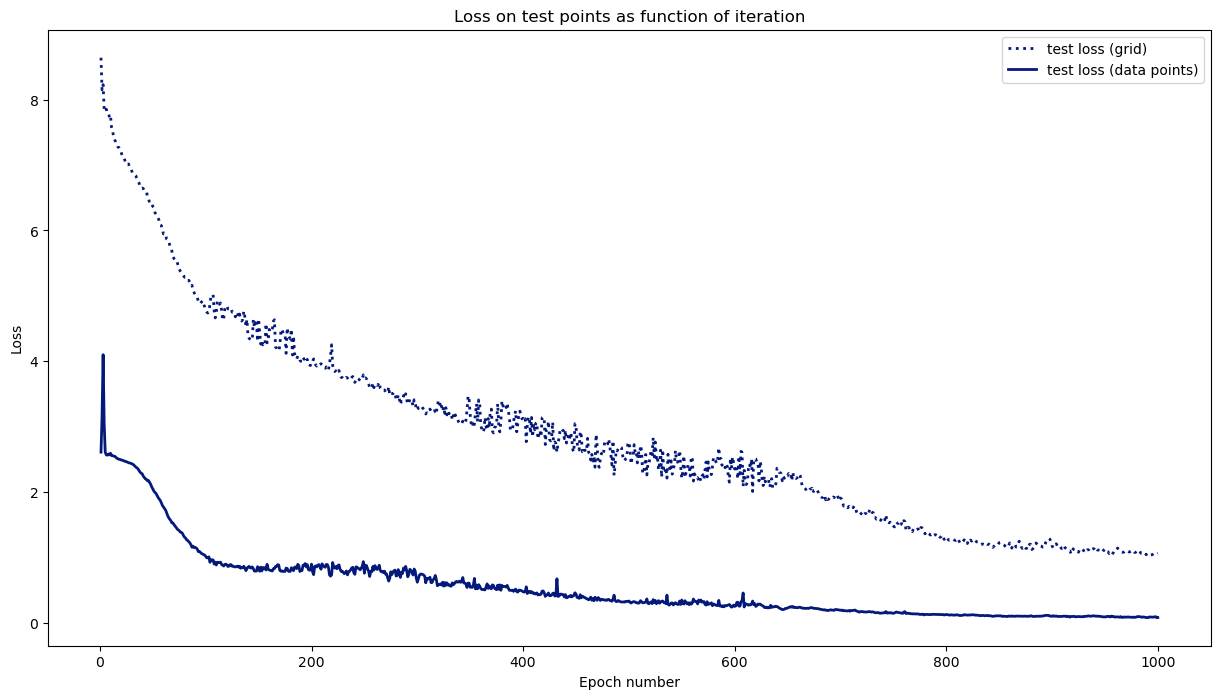

In [21]:
f, ax = plt.subplots(figsize=(15,8))

x = np.arange(len(test_loss_grid_all)) + 1 # 
ax.plot(x, test_loss_grid_all, ":", label="test loss (grid)", color='#05197a', lw=2)
ax.plot(x, test_loss_dp_all, "-", label="test loss (data points)", color='#05197a', lw=2)
ax.legend()
ax.set_xlabel("Epoch number")
ax.set_ylabel("Loss")

ax.set_title("Loss on test points as function of iteration")

We can also use that fucntion we defined earlier to see how quickly the NN can now train on a small dataset given the meta-learned initial parameters.

/var/folders/6m/22vtqxhx77zbj5qrzf7l8xrw0000gn/T/ipykernel_33459/3358481633.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = matplotlib.cm.get_cmap(cmap_nm)
optimizing for seed: 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:13<00:00, 22.64it/s]


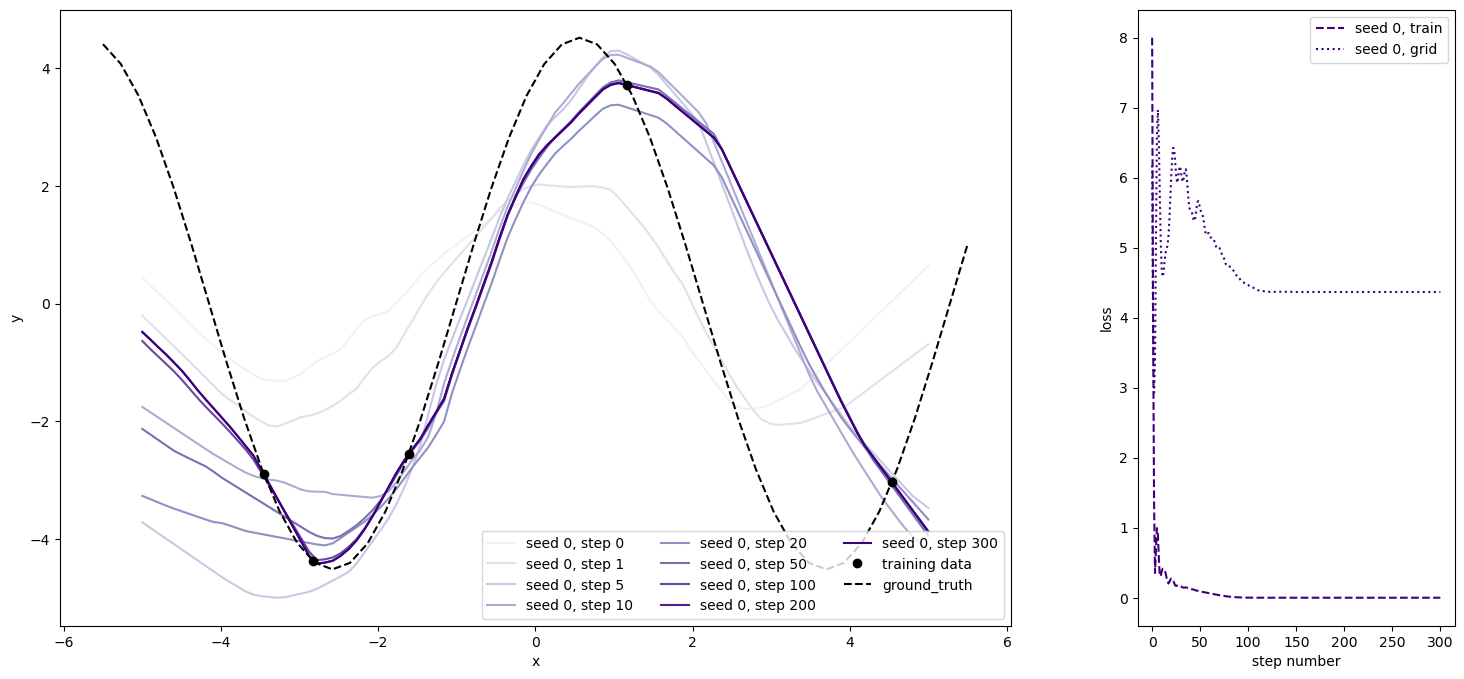

In [22]:
predictions_as_a_func_step(jxkey, test_examples[0], params=outer_ts.params)

So it does much better, starting for a more reasonable initialization, fitting a sinusoid much earlier, and actually going through all the datapoints at the end. However, note that it has  got the period incorrect. 

Just to gain more confidence we will also generate new test tasks and finetune with fewer steps to see what happens.

In [23]:
more_test_examples = [next(data_generator) for _ in range(2)]  # <-- we'll show the method working at the end on 3 examples

### New test function 1, random initial params:

/var/folders/6m/22vtqxhx77zbj5qrzf7l8xrw0000gn/T/ipykernel_33459/3358481633.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = matplotlib.cm.get_cmap(cmap_nm)
optimizing for seed: 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.68it/s]


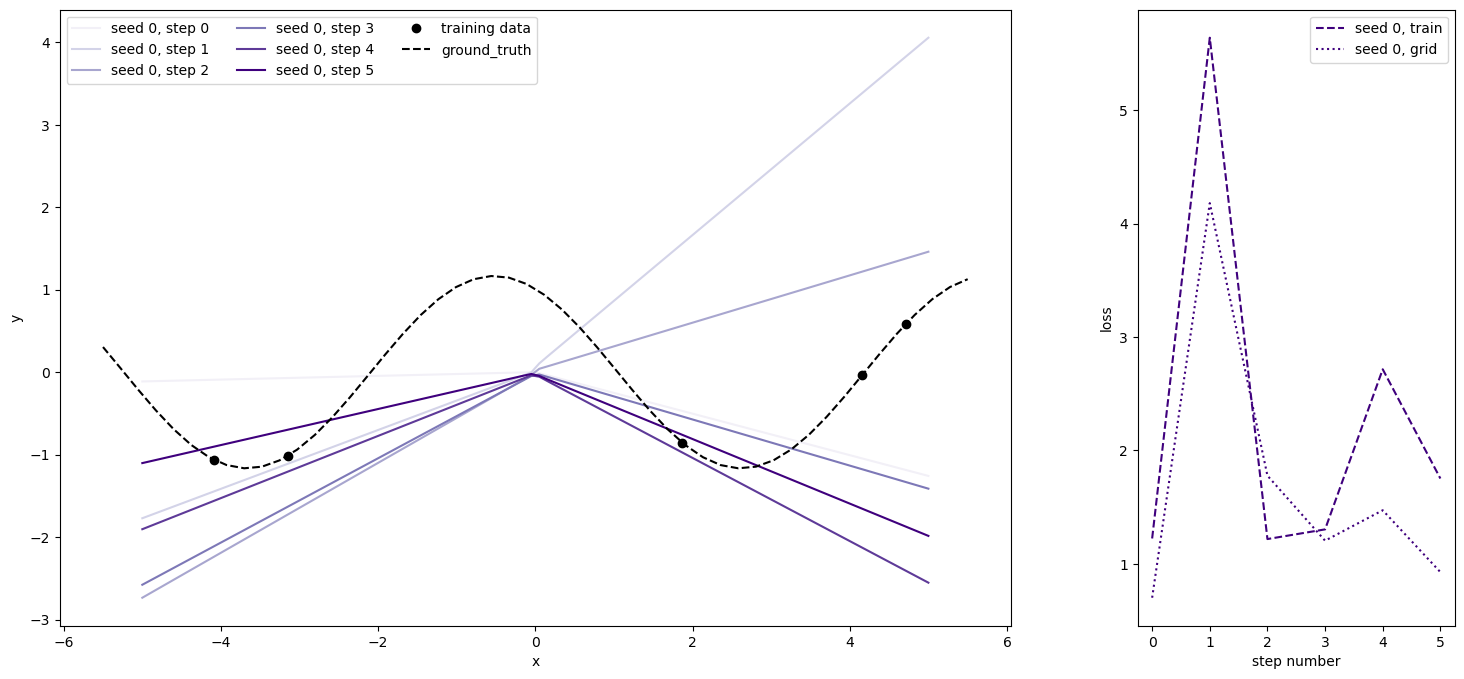

In [24]:
predictions_as_a_func_step(jxkey, more_test_examples[0],  plot_steps=[0,1,2,3,4,5])

### New test function 1, MAML params

/var/folders/6m/22vtqxhx77zbj5qrzf7l8xrw0000gn/T/ipykernel_33459/3358481633.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = matplotlib.cm.get_cmap(cmap_nm)
optimizing for seed: 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 24.80it/s]


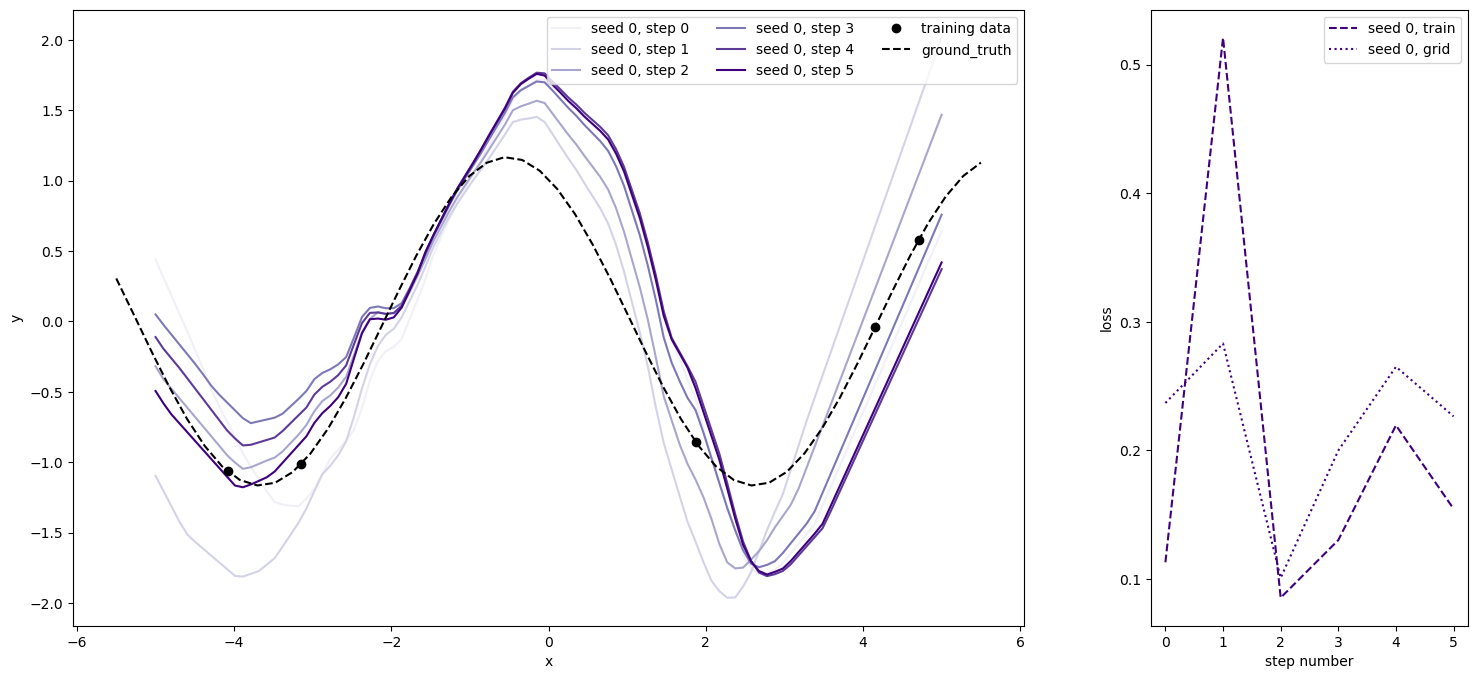

In [25]:
predictions_as_a_func_step(jxkey, more_test_examples[0], params=outer_ts.params, plot_steps=[0,1,2,3,4,5])

### New test function 2, random initial params:

/var/folders/6m/22vtqxhx77zbj5qrzf7l8xrw0000gn/T/ipykernel_33459/3358481633.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = matplotlib.cm.get_cmap(cmap_nm)
optimizing for seed: 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 18.57it/s]


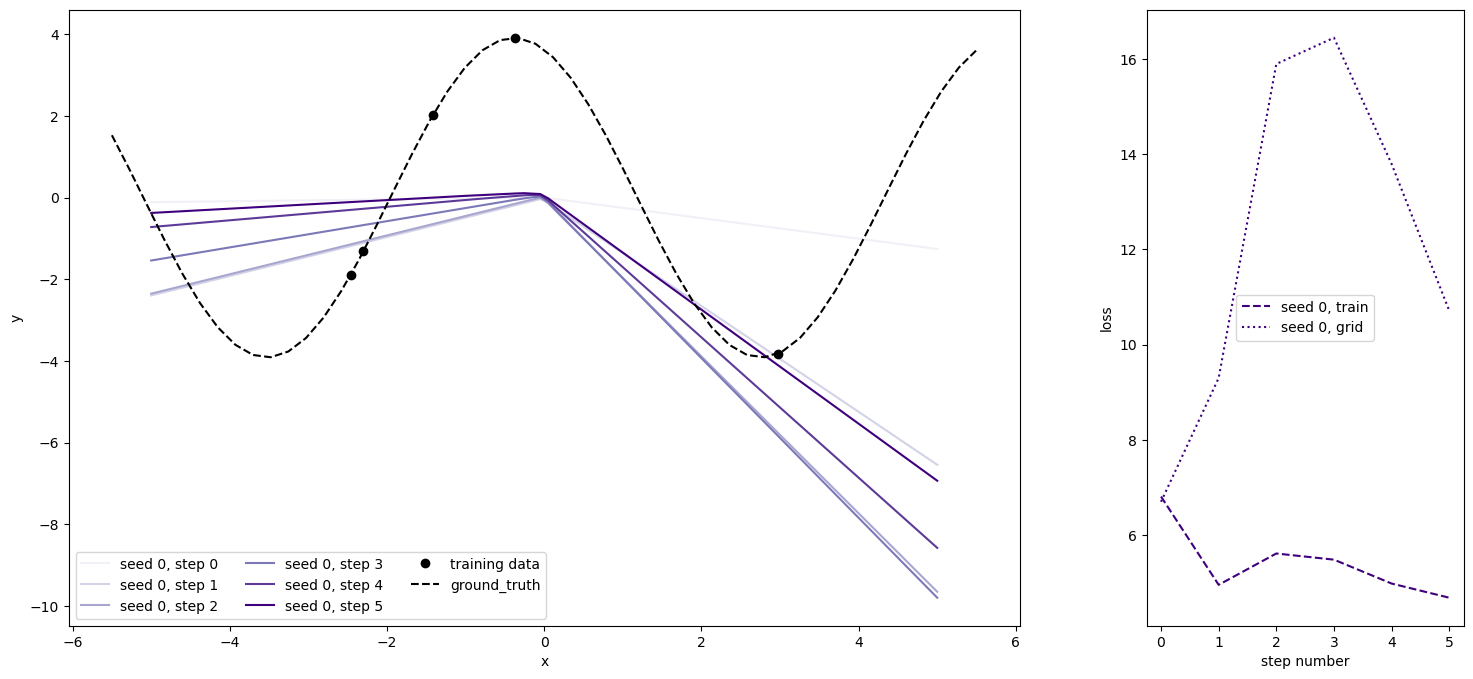

In [26]:
predictions_as_a_func_step(jxkey, more_test_examples[1],  plot_steps=[0,1,2,3,4,5])

### New test function 2, MAML initial params:


/var/folders/6m/22vtqxhx77zbj5qrzf7l8xrw0000gn/T/ipykernel_33459/3358481633.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = matplotlib.cm.get_cmap(cmap_nm)
optimizing for seed: 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 24.32it/s]


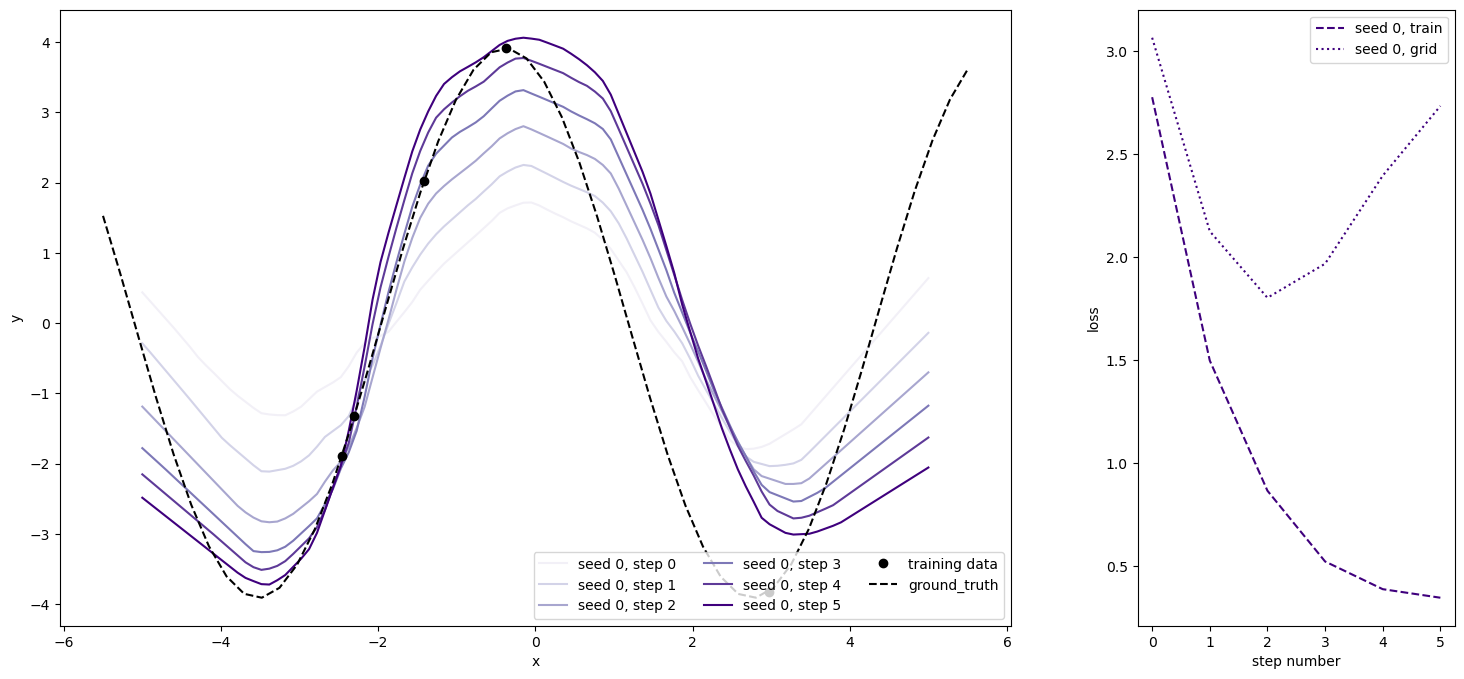

In [27]:
predictions_as_a_func_step(jxkey, more_test_examples[1], params=outer_ts.params, plot_steps=[0,1,2,3,4,5])

So now we can reasonably well fit sinusiods drawn from the same initial distribution in only five steps! 